#### To use the Random Forest Survival analysis you will need to use the Pysurvival package.
To install this package please follow the instructions from this site https://square.github.io/pysurvival/installation.html
##### For MacOS users:
You will need to add two more lines besides the recommended 2 as shown below:
###### Note: please check which version of gcc do you have as it might be different from 9.3.0.



### To use the Random Forest Survival analysis we need to load the data and remove the colinear features

In [1]:
import numpy as np
import pandas as pd
import math
import statistics
import os
import pysurvival
import subprocess
import scipy.io

from pysurvival.utils.display import correlation_matrix
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index, integrated_brier_score
from pysurvival.utils.display import compare_to_actual, KaplanMeierModel 


from sklearn.model_selection import StratifiedKFold
from statistics import mean 
from lifelines import CoxPHFitter

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


#path to c-index R script
command ='Rscript'
path2script ='cindex.R'
cmd = [command, path2script]
ciFileName = 'ci.csv'

In [2]:
def cox_feature_select(data):    
    time_column='time column'
    event_column='event column'
    features=np.setdiff1d(data.columns, [time_column, event_column]).tolist()

    #computing max numer of samples 
    num_samples = data.shape[0]
    max_num_features = math.ceil(num_samples/10)
    print("max =" + str(max_num_features))
    print(data)
    cph = CoxPHFitter()
    cph.fit(data, duration_col = time_column, event_col=event_column)  

    #getting coefficients
    hr = abs(cph.params_)

    filtered_hr = hr.nlargest(n=max_num_features, keep='first')
    index_names = filtered_hr.index

    col_names = []
    for x in range(1,len(index_names)):
        col_names.append(index_names[x])

    col_names.append(time_column)
    col_names.append(event_column)

    filtered_data = data.filter(items=col_names, axis=1)
    print('Final dataset: \n', filtered_data)
    
    return filtered_data

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=10):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True
            
    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [21]:
# feature selection function by VIF and removing low variance features

def feature_select(file_name, feature_select = 1):
    data = pd.read_csv(file_name)

    if 'FFLP' in data.columns:
        data['time column']= data['FFLP_in_months']
        data['event column']= data['FFLP']
        data = data.drop(columns = ['FFLP','FFLP_in_months'])

    elif 'AnyHepaticProgression' in data.columns:
        data['time column']= data['TimeToAnyHepaticProgression']
        data['event column']= data['AnyHepaticProgression']
        data = data.drop(columns = ['AnyHepaticProgression','TimeToAnyHepaticProgression'])

    data1=data.drop(columns=['filename'])
    lola=data1.iloc[:,0:255]

    # no feature selection selected, just retured formatted dataframe
    if (feature_select == 0):
        return data1
    
    time_column='time column'
    event_column='event column'
    features=np.setdiff1d(data1.columns, [time_column, event_column]).tolist()

    #VIF of 10 means that all the features with R^2 above 0.9 will removed
    X = lola
    data2 = calculate_vif_(X, 10)
    data2[['time column']] = lola[['time column']]


    #removing low variance features
    data_temp = data2
    for cols in data2.columns:
        if np.var(data2[cols]) == 0:
            print('Dropping: ' + cols)
            data_temp = data_temp.drop(columns=cols)

    data2 = data_temp
    
    #feature selecting by taking high odds variables from Cox regression if not enough samples
    print(data2)
    data_temp = cox_feature_select(data2)
    data2 = data_temp
    
    # saving a copy to not repeat feature selection again
    processedFileName = 'filtered_' + file_name
    data2.to_csv(processedFileName, index=False)

    return data2

In [5]:
# Gridsearch funciton for random survival forest

def gridsearch(data, file_name):
    
    num_tree=(10, 15, 20, 50, 100, 200)
    max_depth=(2, 3, 5, 7, 10, 12)
    min_node=(1, 2, 3, 4, 5, 10)
    num_tree_best = 0
    max_depth_best = 0
    min_node_best = 0
    c_index_best = 0
    
    for a in num_tree:
        for b in max_depth:
            for c in min_node:
                (CIAvg, CIStd, IBSAvg, IBSStd, var_imps_list, predictions) = generate_survival_model(data, a, b, c, 0)
                print(a, b, c, CIAvg)
                if CIAvg > c_index_best:
                    c_index_best = CIAvg
                    num_tree_best = a
                    max_depth_best = b
                    min_node_best = c
                    
    # saving a copy to not repeat grisearch again, invalid for gridsearch within CV
    processedFileName = 'gridsearch_' + file_name           
    toDF = [c_index_best, num_tree_best, max_depth_best, min_node_best]
    gridsearchDF = pd.DataFrame(toDF,columns=['Values'])
    gridsearchDF.to_csv(processedFileName)
    
    return (c_index_best, num_tree_best, max_depth_best, min_node_best)

In [25]:
#set rcorr = 1 to use rcorr C-index and STD
def generate_survival_model(data, num_tree_best, max_depth_best, min_node_best, display = 0, rcorr = 0, s = 42):
    # retraining with best gridsearch hyperparameters, manually entering them as variables, probably can automate this from picking out max acc
    # Creating the X, T and E inputs
    
    var_imp_dict = {}
    CI = []
    IBS = []
    STD = []
    predictions = []
    
    time_column='time column'
    event_column='event column'
    features=np.setdiff1d(data.columns, [time_column, event_column]).tolist()
    #X = data[features]
    newX=np.setdiff1d(data.columns, [event_column]).tolist()
    X=data[newX]
    E=data['event column']

    k_folds = 4
    kf=StratifiedKFold(n_splits=k_folds, random_state=s, shuffle=False)
    
    for train_index, test_index in kf.split(X,E):
        
        # gridsearch within CV loop, takes a long while, comment if doing gridsearch outside of CV
        # gridsearch_data = pd.concat([X,E], axis=1)
        # (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(gridsearch_data, "garbageFile")
        
        X1_train, X1_test=X.loc[train_index], X.loc[test_index]
        X_train, X_test=X1_train[features], X1_test[features]
        T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
        E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
        #fitting survival model
        xst = RandomSurvivalForestModel(num_trees=num_tree_best) 
        
        xst.fit(X_train, T_train, E_train, max_features = 'all', max_depth = max_depth_best,
            min_node_size = min_node_best, num_threads = -1, 
            sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
            seed = s, save_memory=False )
        
        if(rcorr == 0):
            c_index = concordance_index(xst, X_test, T_test, E_test)
            CI.append(c_index)
        else:
            #running R subprocess
            risk = xst.predict_risk(X_test).tolist()
            test_preds = [risk, T_test.tolist(), E_test.tolist()]
            preds_DF = pd.DataFrame(test_preds).transpose()
            preds_DF.to_csv('preds.csv', index=False, header=False)           
            subprocess.run(cmd)
            
            RResults = pd.read_csv('ci.csv')
            c_index = RResults['ci'][0]
            CI.append(c_index)
            STD.append(RResults['std'][0]/2)
        
        ibs = integrated_brier_score(xst, X_test, T_test, E_test, t_max=100)
        IBS.append(ibs)
        
        #displaying curves
        if(display==1):
            results = compare_to_actual(xst, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
                                metrics = ['rmse', 'mean', 'median'])
            pysurvival.utils.display.integrated_brier_score(xst, X_test, T_test, E_test, t_max=100, figure_size=(16,6))
            print('C-index: {:.2f}'.format(c_index))
            print('IBS: {:.2f}'.format(ibs))           
        
        #here we are extracting the actual survival and compared to the predictions for manual analysis
        num_patients = X_test.shape[0]
        preds = np.sum(xst.predict_survival(X_test), 0)/num_patients
        #comparing to actual survival modelled by kaplan meier
        km = KaplanMeierModel()
        km.fit(T_test, E_test, alpha=0.95)
        actuals = km.survival.tolist()
        actual_times = km.times.tolist()

        #the RSF models follows different time buckets, this is rescaling it
        #to follow the original data
        preds_scaled = []
        for t in actual_times:
            min_index = [ abs(a_j_1-t) for (a_j_1, a_j) in xst.time_buckets]
            index = np.argmin(min_index)
            preds_scaled.append( preds[index] )
        
        predictions.append([actuals, preds_scaled, actual_times])
        
        #computing variable importances
        var_imps = xst.variable_importance_table
        var_list = var_imps['feature'].to_list()
        
        if 'imps' in locals():
            garbage=1
            #importance dictionary already made
        else:
            imps = {key:[] for key in var_list}
            pcts = {key:[] for key in var_list}
            
        for var_name in var_list:
            imps[var_name].append(var_imps.loc[var_imps['feature'] == var_name]['importance'].iloc[0])
            pcts[var_name].append(var_imps.loc[var_imps['feature'] == var_name]['pct_importance'].iloc[0])
         
    #computing variable importance statistics
    var_imps_list = []
    for var_name in var_list:
        imp_avg = mean(imps[var_name])
        imp_std = statistics.stdev(imps[var_name])
        pct_avg = mean(pcts[var_name])
        pct_std = statistics.stdev(pcts[var_name])

        var_imps_list.append([var_name, imp_avg, imp_std, pct_avg, pct_std])   
        
    #just printing for now, can use as return value later if you want
    var_imps_df = pd.DataFrame(var_imps_list, columns = ['Variable', 'Imp Avg','Imp Std', 'Pct Avg', 'Pct Std'])
    
    if(display == 1):
        print(var_imps_df)

    CIAvg = mean(CI)
    if(rcorr==0):
        CIStd = statistics.stdev(CI)
    else:
        CIStd = mean(STD)    

    IBSAvg = mean(IBS)
    IBSStd = statistics.stdev(IBS)
    
    return(CIAvg, CIStd, IBSAvg, IBSStd, var_imps_list, predictions)


In [7]:
#merging two dataframes, dropping all except ID column
def df_merge(df1, df2, colName = 'filename'):
    tempDF = df1.merge(df2, left_on=colName, right_on=colName, suffixes=('','_toDelete'))
    cols = [c for c in tempDF.columns if not('_toDelete' in c)]
    merged = tempDF[cols]
    
    return merged

### Main script starts here

In [9]:
#creating subsets of clinical variables
clin_variables_name = 'clin_variables_all.csv'
clin_variables_all = pd.read_csv(clin_variables_name) 
cols_irrelevant = ['P53', 'BRAF', 'MSS/MSI']
cols_imaging = ['filename', 'NumLiverLesionsAtRT', 'OtherSitesAtRT', 'Lesion1Dim1', 'Lesion1Dim2',
                'PTVvolume (cm^3)']
cols_dosimetric = ['filename', 'BED (in Gy)','MinDosePTV (cGy)','Dmax (cGy)', 'D95 (% of intended Rx dose)',
                  'SystemicBeforeRT', 'Lines of chemo','PumpBeforeRT', 'CEAatRT', 'KRASmutation']
cols_imaging_no_file_name = ['NumLiverLesionsAtRT', 'OtherSitesAtRT', 'Lesion1Dim1', 'Lesion1Dim2',
                'PTVvolume (cm^3)']
cols_hp = ['AnyHepaticProgression', 'TimeToAnyHepaticProgression']
cols_fflp = ['FFLP_in_months', 'FFLP']


clin_variables_no_mut = clin_variables_all.drop(columns = cols_irrelevant)

clin_variables_non_imaging = clin_variables_no_mut.drop(columns = cols_imaging_no_file_name)
clin_variables_non_imaging_fflp = clin_variables_non_imaging.drop(columns = cols_hp)
clin_variables_non_imaging_hp = clin_variables_non_imaging.drop(columns = cols_fflp)
clin_variables_non_imaging_fflp.to_csv('clin_variables_non_imaging_fflp.csv', index=False)
clin_variables_non_imaging_hp.to_csv('clin_variables_non_imaging_hp.csv', index=False)

clin_variables_imaging_fflp = clin_variables_no_mut[cols_imaging + cols_fflp]
clin_variables_imaging_hp = clin_variables_no_mut[cols_imaging + cols_hp]
clin_variables_imaging_fflp.to_csv('clin_variables_imaging_fflp.csv', index=False)
clin_variables_imaging_hp.to_csv('clin_variables_imaging_hp.csv', index=False)

clin_variables_dosimetric_fflp = clin_variables_no_mut[cols_dosimetric + cols_fflp ]
clin_variables_dosimetric_hp = clin_variables_no_mut[cols_dosimetric + cols_hp ]
clin_variables_dosimetric_fflp.to_csv('clin_variables_dosimetric_fflp.csv', index=False)
clin_variables_dosimetric_hp.to_csv('clin_variables_dosimetric_hp.csv', index=False)

clin_variables_all_fflp = clin_variables_no_mut.drop(columns=cols_hp)
clin_variables_all_fflp.to_csv('clin_variables_all_fflp.csv', index=False)
clin_variables_all_hp = clin_variables_no_mut.drop(columns=cols_fflp)
clin_variables_all_hp.to_csv('clin_variables_all_hp.csv', index=False)

#merging clinical variables with liver_plus_gtv, dropping duplicate columns from second dataframe
liver_plus_gtv_fflp = pd.read_csv('liver_plus_gtv.csv')
liver_plus_gtv_hp = pd.read_csv('liver_plus_gtv_hp.csv')

rads_plus_non_imaging_fflp = df_merge(liver_plus_gtv_fflp, clin_variables_non_imaging_fflp)
rads_plus_non_imaging_hp = df_merge(liver_plus_gtv_hp, clin_variables_non_imaging_hp)
rads_plus_non_imaging_fflp.to_csv('rads_plus_non_imaging_fflp.csv', index=False)
rads_plus_non_imaging_hp.to_csv('rads_plus_non_imaging_hp.csv', index=False)

rads_plus_imaging_fflp = df_merge(liver_plus_gtv_fflp, clin_variables_imaging_fflp)
rads_plus_imaging_hp = df_merge(liver_plus_gtv_hp, clin_variables_imaging_hp)
rads_plus_imaging_fflp.to_csv('rads_plus_imaging_fflp.csv', index=False)
rads_plus_imaging_hp.to_csv('rads_plus_imaging_hp.csv', index=False)

rads_plus_dosimetric_fflp = df_merge(liver_plus_gtv_fflp, clin_variables_dosimetric_fflp)
rads_plus_dosimetric_hp = df_merge(liver_plus_gtv_hp, clin_variables_dosimetric_hp)
rads_plus_dosimetric_fflp.to_csv('rads_plus_dosimetric_fflp.csv', index=False)
rads_plus_dosimetric_hp.to_csv('rads_plus_dosimetric_hp.csv', index=False)

all_fflp = df_merge(liver_plus_gtv_fflp, clin_variables_all_fflp)
all_fflp.to_csv('all_fflp.csv', index=False)
all_hp = df_merge(liver_plus_gtv_hp, clin_variables_all_hp)
all_hp.to_csv('all_hp.csv', index=False)

In [14]:
# Loading all the data
# Single run of all datasets below, separate single-use code at bottom

#outcome as local progression
gtv_fflp = 'gtv.csv'
liver_sub_gtv_fflp = 'liver_sub_gtv.csv'
liver_plus_gtv_fflp = 'liver_plus_gtv.csv'

#outcome defined as any hepatic progression
gtv_hp = 'gtv_hp.csv'
liver_sub_gtv_hp = 'liver_sub_gtv_hp.csv'
liver_plus_gtv_hp = 'liver_plus_gtv_hp.csv'

#clinical vairables
clin_variables_imaging_fflp = 'clin_variables_imaging_fflp.csv'
clin_variables_non_imaging_fflp = 'clin_variables_non_imaging_fflp.csv'
clin_variables_dosimetric_fflp = 'clin_variables_dosimetric_fflp.csv'
clin_variables_imaging_hp = 'clin_variables_imaging_hp.csv'
clin_variables_non_imaging_hp = 'clin_variables_non_imaging_hp.csv'
clin_variables_dosimetric_hp = 'clin_variables_dosimetric_hp.csv'
clin_variables_non_imaging_hp = 'clin_variables_non_imaging_hp.csv'
clin_variables_all_fflp = 'clin_variables_all_fflp.csv'
clin_variables_all_hp = 'clin_variables_all_hp.csv'

#combination
rads_plus_imaging_fflp = 'rads_plus_imaging_fflp.csv'
rads_plus_non_imaging_fflp = 'rads_plus_non_imaging_fflp.csv'
rads_plus_dosimetric_fflp = 'rads_plus_dosimetric_fflp.csv'
rads_plus_imaging_hp = 'rads_plus_imaging_hp.csv'
rads_plus_non_imaging_hp = 'rads_plus_non_imaging_hp.csv'
rads_plus_dosimetric_hp = 'rads_plus_dosimetric_hp.csv'

#EVERYTHING
all_fflp = 'all_fflp.csv'
all_hp = 'all_hp.csv'

data_list = list()
data_list.extend((gtv_fflp, liver_sub_gtv_fflp, liver_plus_gtv_fflp, gtv_hp, liver_sub_gtv_hp, liver_plus_gtv_hp,
                 clin_variables_imaging_fflp , clin_variables_non_imaging_fflp, clin_variables_dosimetric_fflp,
                 clin_variables_imaging_hp, clin_variables_non_imaging_hp, clin_variables_dosimetric_hp,
                 rads_plus_imaging_fflp, rads_plus_non_imaging_fflp, rads_plus_dosimetric_fflp,
                 rads_plus_imaging_hp, rads_plus_non_imaging_hp, rads_plus_dosimetric_hp,
                 clin_variables_all_fflp, clin_variables_all_hp, all_fflp, all_hp))

In [22]:
# iterating thought each dataset
# all results will be stored in a dataframe with columns "CI, CI STD, IBS, IBS"

results = []
    
for data_name in data_list:

    # Running feature selection on the data
    
    print('Processing: ' + data_name + '\n')
    processed_file_name = 'filtered_' + data_name 
    
    print('Feature Selecting... \n')
    if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
    else:
        filtered_data = pd.read_csv(processed_file_name)
        print('Loading existing selected features...\n')
    print('\n \n')

    # running gridsearch
    
    print('Running gridsearch on: ' + data_name + '\n')
    gridsearch_file_name = 'gridsearch_' + data_name 
    
    if(not(os.path.exists(gridsearch_file_name))):
        print('Computing gridsearch...\n')
        (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
        print((c_index_best, num_tree_best,max_depth_best, min_node_best))
    else:
        gridsearch_df = pd.read_csv(gridsearch_file_name)
        
        c_index_best = gridsearch_df['Values'][0]
        num_tree_best = gridsearch_df['Values'][1]
        max_depth_best = gridsearch_df['Values'][2]
        min_node_best = gridsearch_df['Values'][3]
        
        #print(c_index_best)
        print('Loading existing gridsearch hyperparameters...\n')
        
    # generating model form best gridsearch combination

    print('Evaluating K-folds with best hyperparameter combination...\n')
    (CIAvg, CIStd, IBSAvg, IBSStd, var_imps_list, predictions) = generate_survival_model(filtered_data, 
                                                                                                        num_tree_best, max_depth_best, 
                                                                                                        min_node_best,display=1)
    
    
    
    results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd])
    print('\n \n')

results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD'])

print(results_DF)

Processing: gtv.csv



KeyError: "['filename'] not found in axis"

In [18]:
results_DF.to_csv('results.csv', index=False, header=False)
results_DF

Data  Best Gridsearch CI    CI Avg  \
0                               gtv.csv            0.675486  0.675486   
1                     liver_sub_gtv.csv            0.660133  0.660133   
2                    liver_plus_gtv.csv            0.675743  0.675743   
3                            gtv_hp.csv            0.614537  0.614537   
4                  liver_sub_gtv_hp.csv            0.586293  0.586293   
5                 liver_plus_gtv_hp.csv            0.597319  0.597319   
6       clin_variables_imaging_fflp.csv            0.667342  0.667342   
7   clin_variables_non_imaging_fflp.csv            0.662902  0.662902   
8    clin_variables_dosimetric_fflp.csv            0.717649  0.717649   
9         clin_variables_imaging_hp.csv            0.608929  0.608929   
10    clin_variables_non_imaging_hp.csv            0.603460  0.603460   
11     clin_variables_dosimetric_hp.csv            0.629773  0.629773   
12           rads_plus_imaging_fflp.csv            0.611448  0.611448   
13       rads_plus_non_imaging_fflp.csv            0.605703  0.605703   
14        rads_plus_dosimetric_fflp.csv            0.731730  0.731730   
15             rads_plus_imaging_hp.csv            0.620482  0.620482   
16         rads_plus_non_imaging_hp.csv            0.624740  0.624740   
17          rads_plus_dosimetric_hp.csv            0.652237  0.652237   
18          clin_variables_all_fflp.csv            0.624283  0.624283   
19            clin_variables_all_hp.csv            0.594437  0.594437   
20                         all_fflp.csv            0.594987  0.594987   
21                           all_hp.csv            0.587364  0.587364   

      CI STD   IBS Avg   IBS STD  
0   0.160967  0.197741  0.037357  
1   0.057060  0.197656  0.019231  
2   0.060058  0.202385  0.043448  
3   0.043446  0.191179  0.014612  
4   0.078212  0.163041  0.015114  
5   0.059977  0.165116  0.030022  
6   0.048852  0.168182  0.023489  
7   0.098170  0.185623  0.029469  
8   0.076770  0.178794  0.028256  
9   0.053057  0.151169  0.008499  
10  0.066705  0.161418  0.010733  
11  0.033799  0.134814  0.018464  
12  0.083299  0.202849  0.042012  
13  0.036641  0.205310  0.040815  
14  0.092171  0.177551  0.026196  
15  0.068339  0.150473  0.044144  
16  0.046570  0.133435  0.026193  
17  0.042672  0.140748  0.025380  
18  0.065049  0.190443  0.026766  
19  0.041384  0.153335  0.009528  
20  0.049493  0.234326  0.025885  
21  0.052367  0.137085  0.029412

Processing: gtv.csv


 

Running gridsearch on: gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...



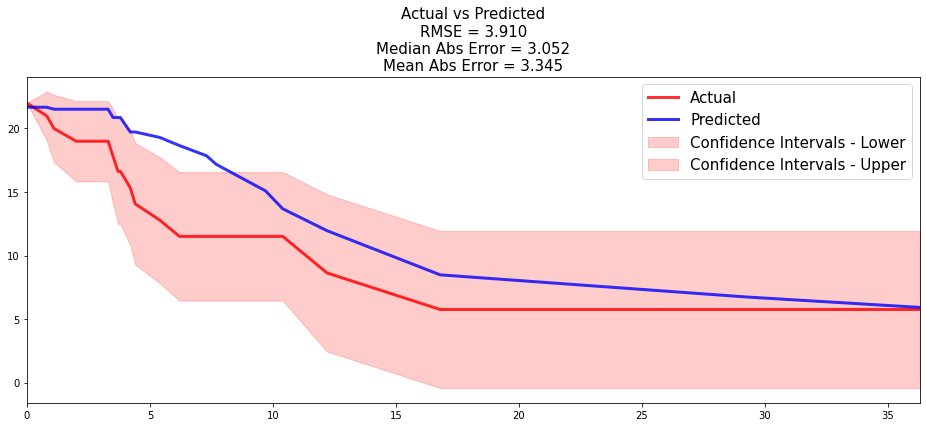

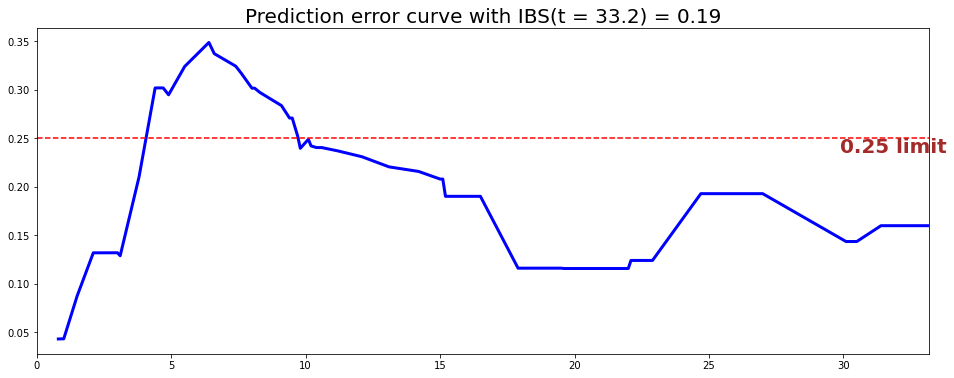

C-index: 0.58
IBS: 0.19


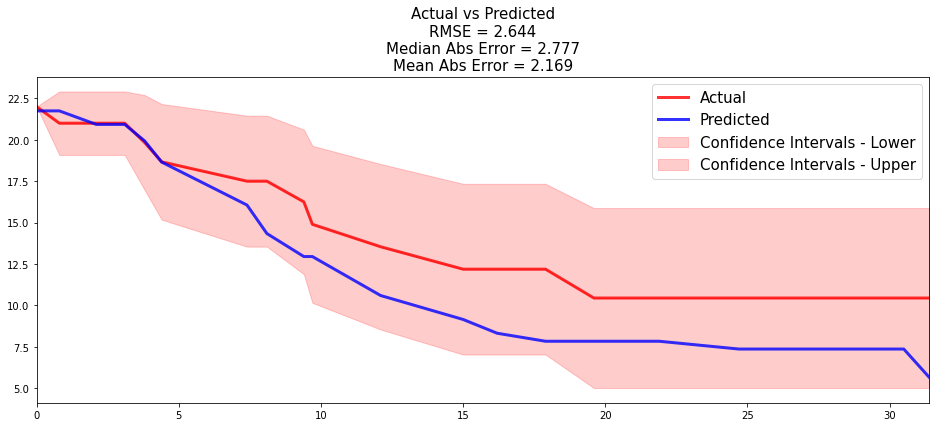

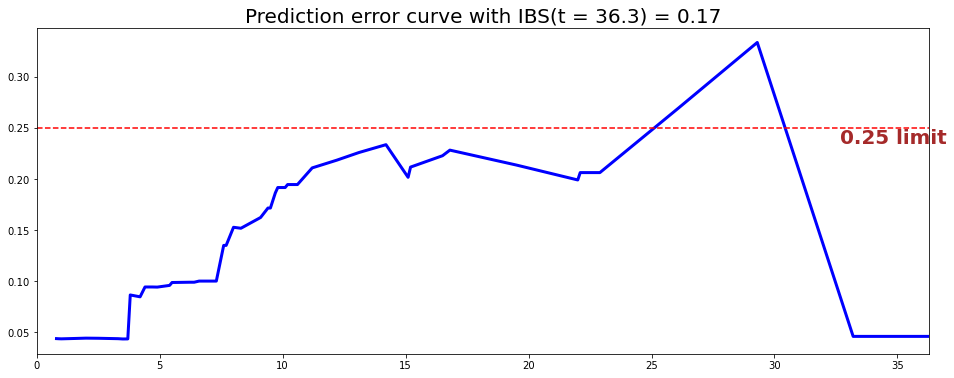

C-index: 0.82
IBS: 0.17


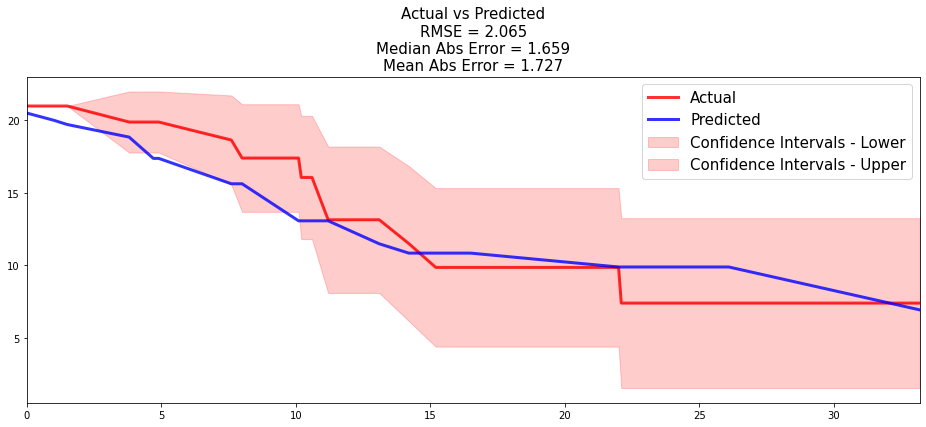

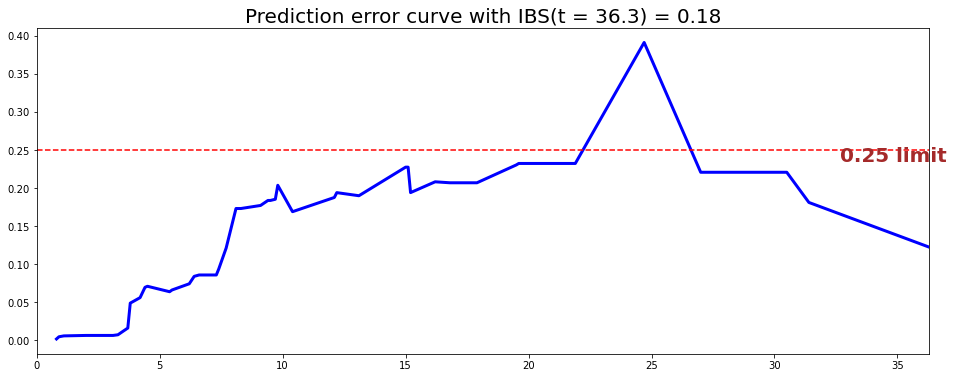

C-index: 0.60
IBS: 0.18


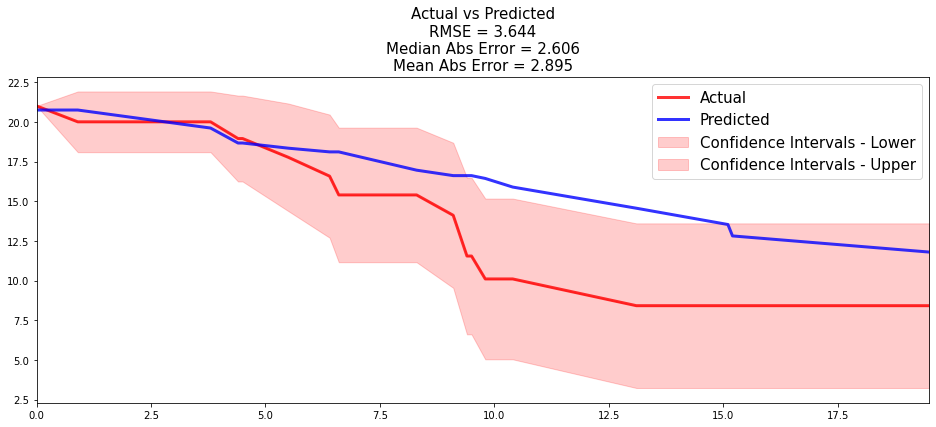

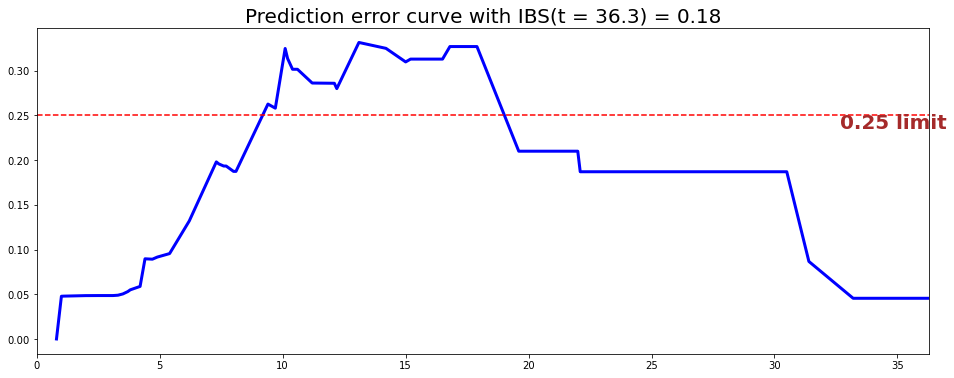

C-index: 0.56
IBS: 0.18
                                              Variable       Imp Avg  \
0      original_glrlm_GrayLevelNonUniformityNormalized  3.951286e-01   
1         original_glszm_LargeAreaLowGrayLevelEmphasis  6.396204e-01   
2                    original_shape_SurfaceVolumeRatio  6.311394e-01   
3                          original_glszm_ZoneVariance -2.635231e-01   
4          original_glrlm_LongRunHighGrayLevelEmphasis  5.270463e-01   
..                                                 ...           ...   
103                                  original_glcm_MCC -2.635231e-01   
104             original_shape_Maximum2DDiameterColumn -2.635231e-01   
105  original_gldm_SmallDependenceLowGrayLevelEmphasis -2.635231e-01   
106                        original_firstorder_Minimum -5.551115e-17   
107                       original_firstorder_Kurtosis -5.270463e-01   

      Imp Std   Pct Avg   Pct Std  
0    1.168438  0.047109  0.056829  
1    0.761105  0.048704  0.057009  
2  

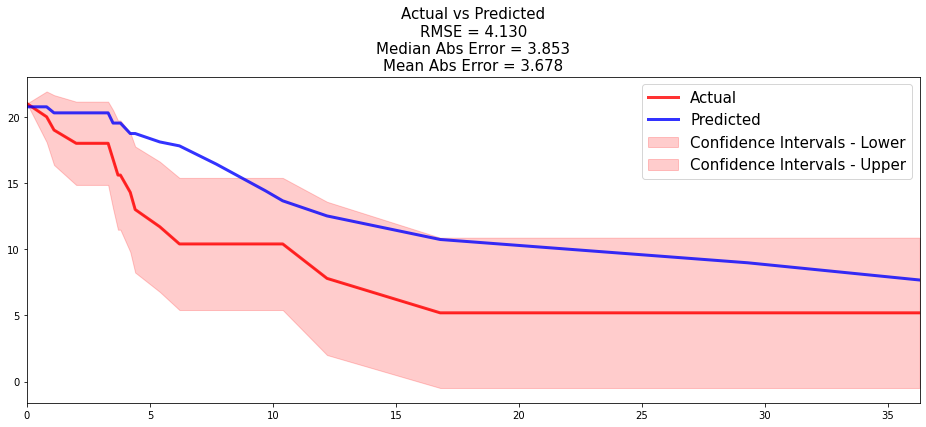

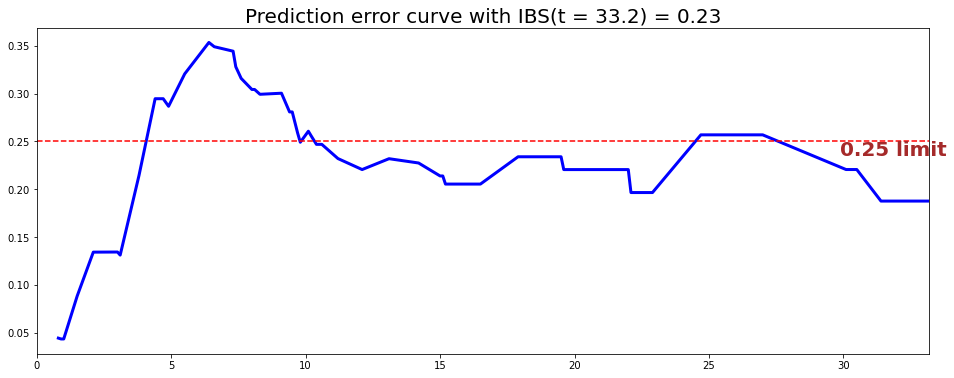

C-index: 0.73
IBS: 0.23


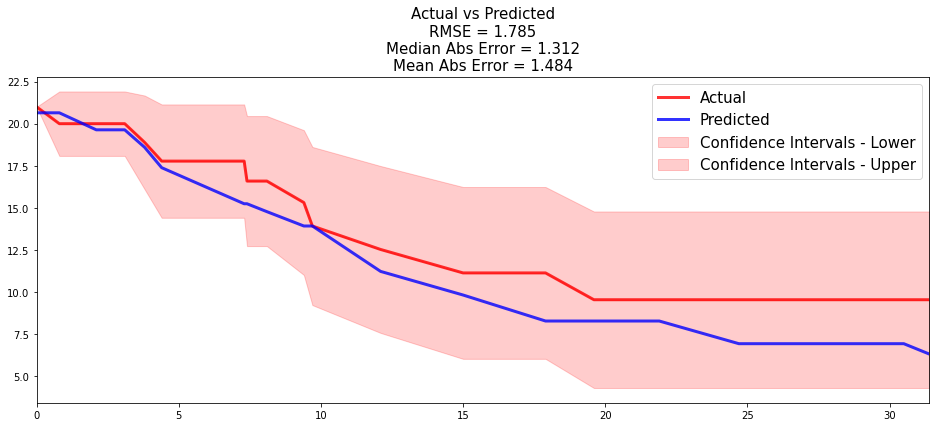

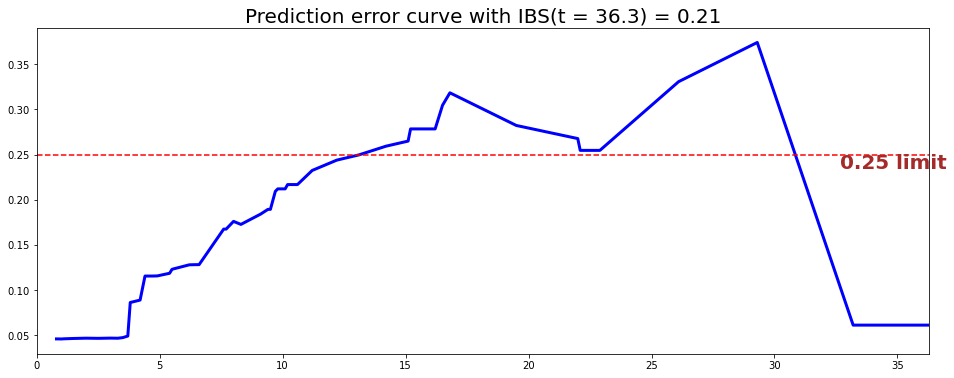

C-index: 0.57
IBS: 0.21


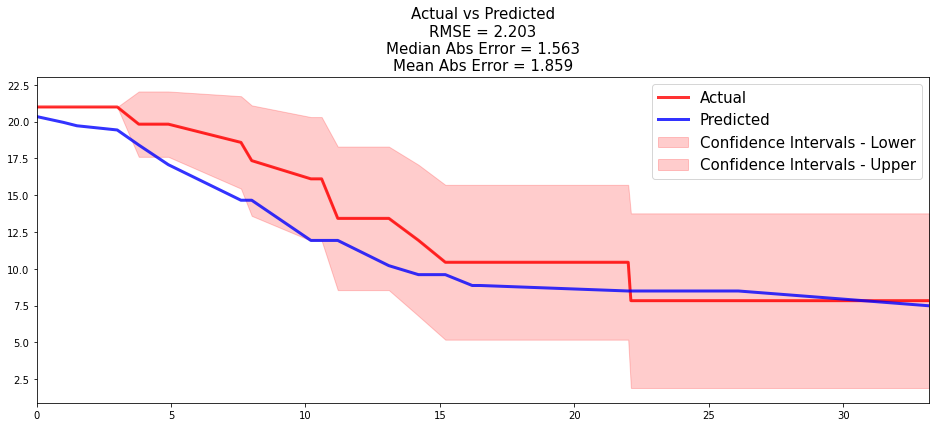

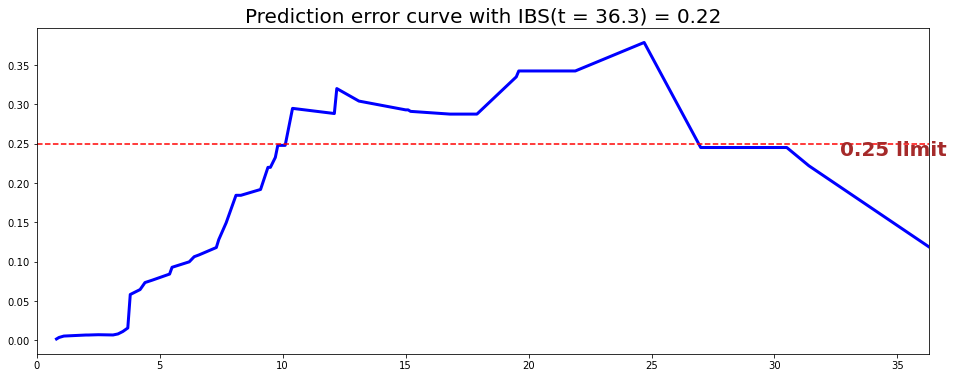

C-index: 0.60
IBS: 0.22


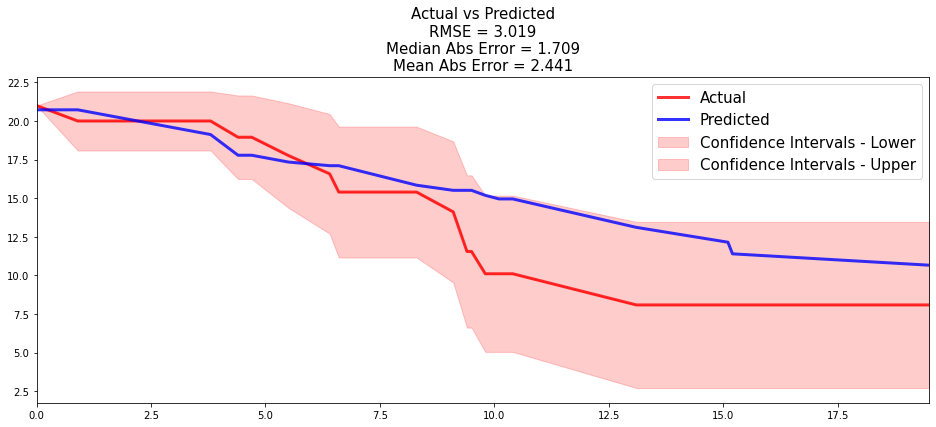

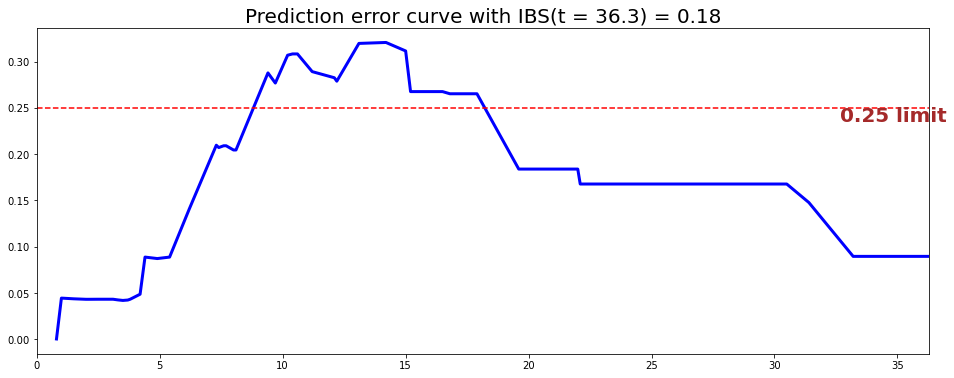

C-index: 0.54
IBS: 0.18
                                              Variable       Imp Avg  \
0                       original_shape_MajorAxisLength  1.004531e-01   
1                                           Unnamed: 0  7.164782e-01   
2                     original_firstorder_90Percentile  2.587746e-01   
3                           original_glcm_ClusterShade  2.587746e-01   
4               original_shape_Maximum2DDiameterColumn  5.175492e-01   
..                                                 ...           ...   
104                                  original_glcm_MCC -5.175492e-01   
105                          original_glcm_JointEnergy -2.587746e-01   
106                    original_glcm_ClusterProminence -5.175492e-01   
107       original_glszm_SmallAreaLowGrayLevelEmphasis -5.551115e-17   
108  original_gldm_SmallDependenceHighGrayLevelEmph... -2.587746e-01   

      Imp Std   Pct Avg   Pct Std  
0    1.015838  0.033293  0.066586  
1    0.828991  0.065096  0.075217  
2  

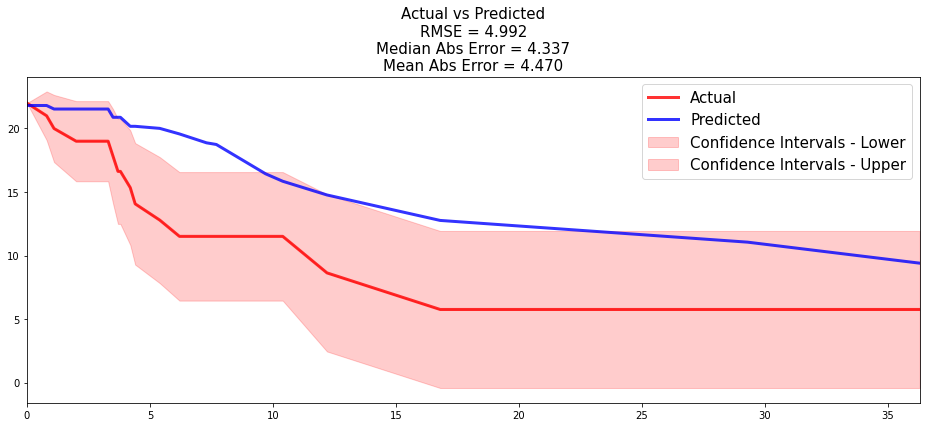

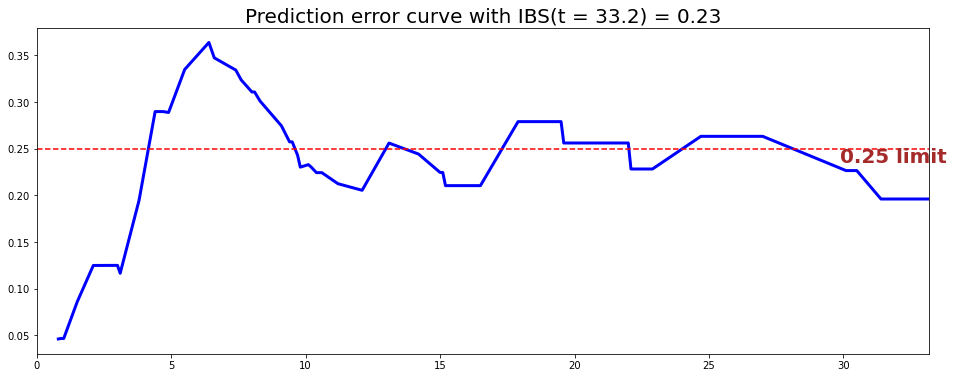

C-index: 0.68
IBS: 0.23


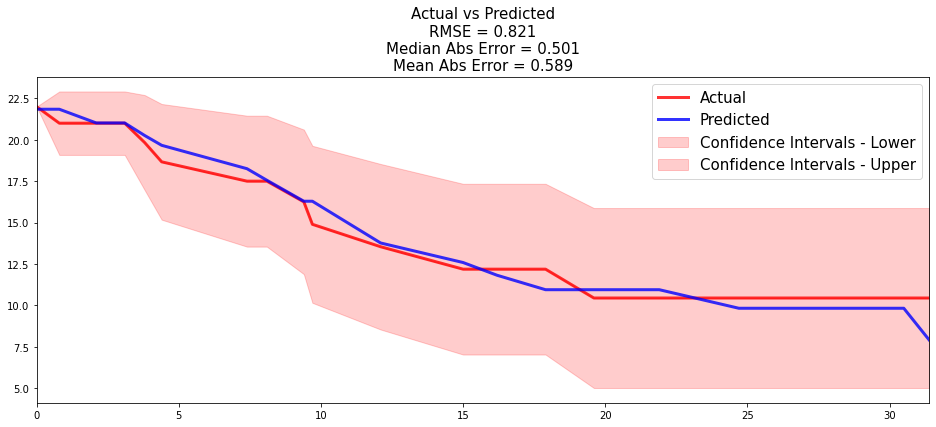

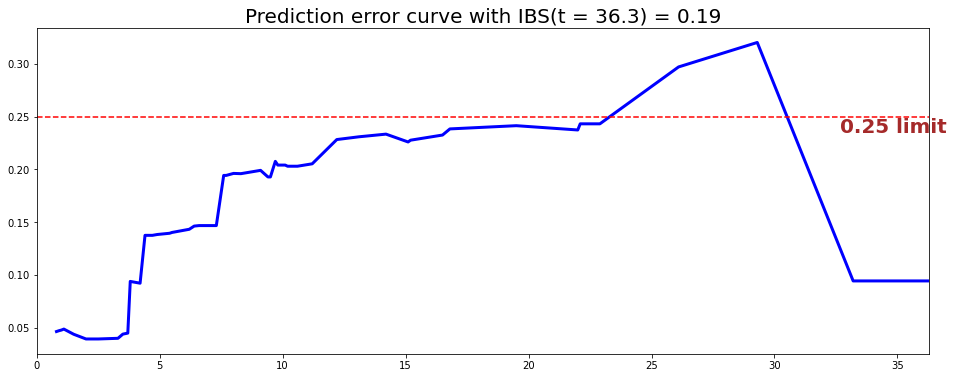

C-index: 0.67
IBS: 0.19


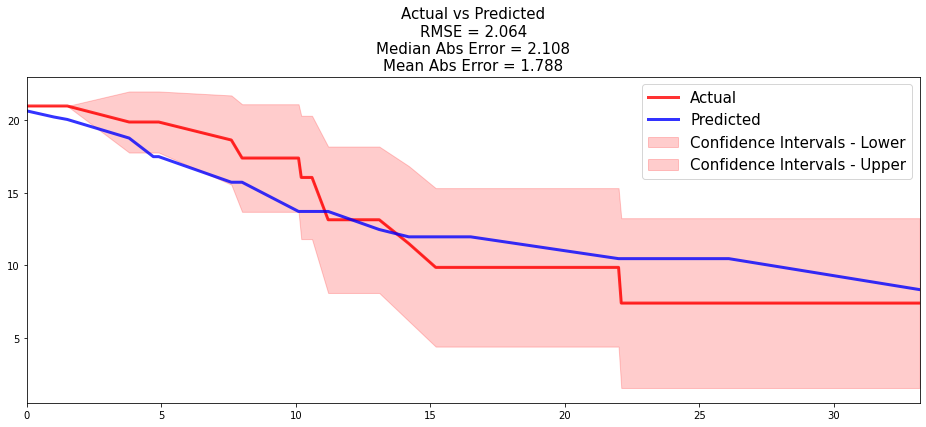

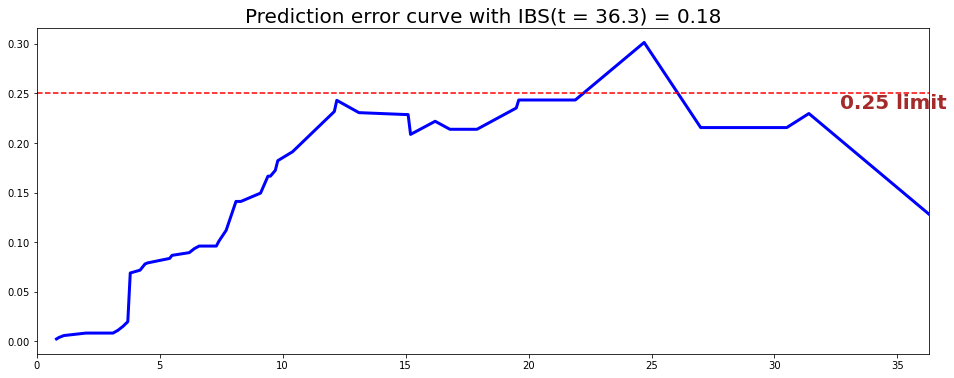

C-index: 0.75
IBS: 0.18


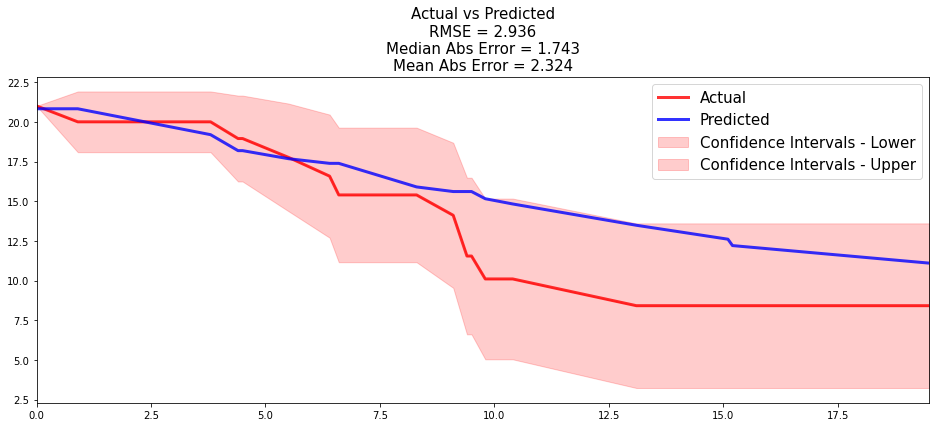

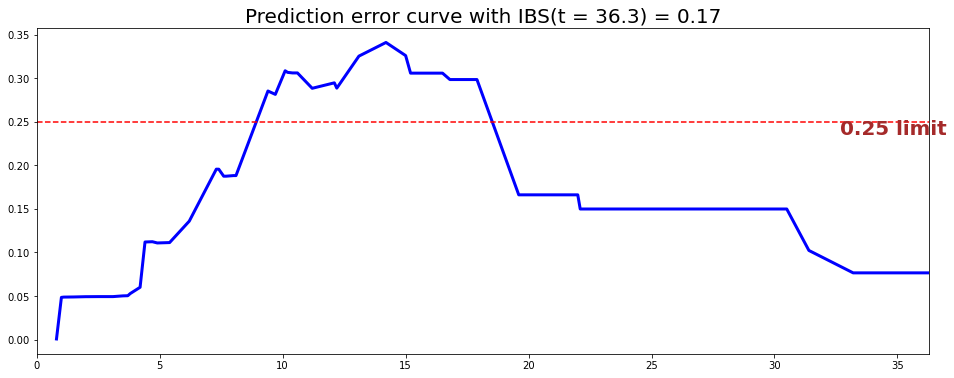

C-index: 0.56
IBS: 0.17
                                       Variable   Imp Avg   Imp Std   Pct Avg  \
0                     original_ngtdm_Coarseness  2.613196  0.950047  0.038910   
1                    original_shape_VoxelVolume  2.049620  1.349156  0.030421   
2               diagnostics_Image-original_Mean  2.437016  1.374875  0.037049   
3               original_gldm_DependenceEntropy  1.021683  1.429167  0.018476   
4         original_glrlm_RunLengthNonUniformity  1.317038  0.662647  0.019389   
..                                          ...       ...       ...       ...   
103    original_glszm_HighGrayLevelZoneEmphasis -0.696904  0.671190  0.000000   
104                original_firstorder_Variance -0.880712  0.558340  0.000000   
105                  original_glcm_ClusterShade -0.010961  1.613952  0.011096   
106  original_glrlm_LongRunLowGrayLevelEmphasis  0.054777  1.527230  0.010662   
107             original_gldm_GrayLevelVariance -0.274548  1.689257  0.009386   

   

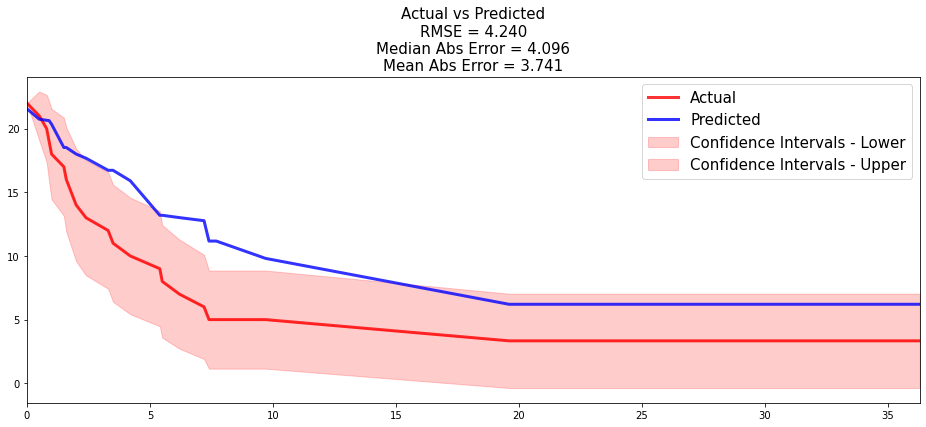

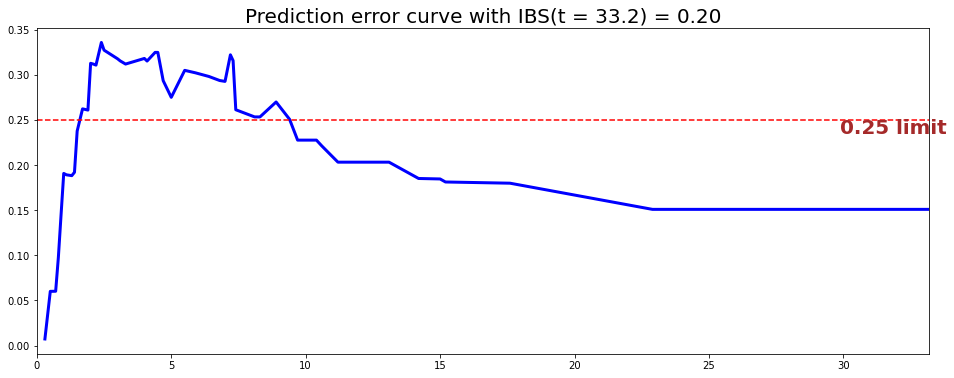

C-index: 0.57
IBS: 0.20


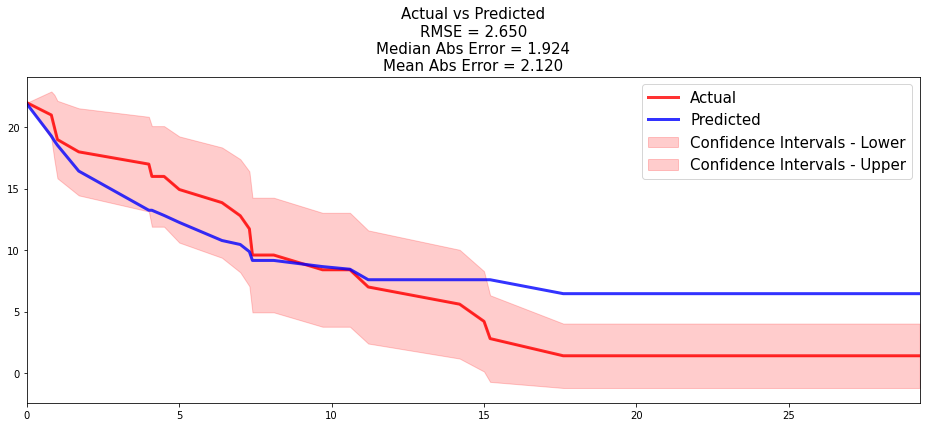

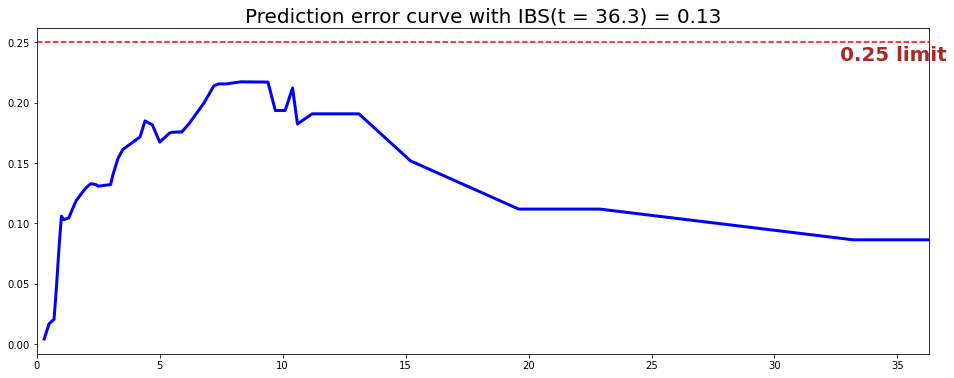

C-index: 0.67
IBS: 0.13


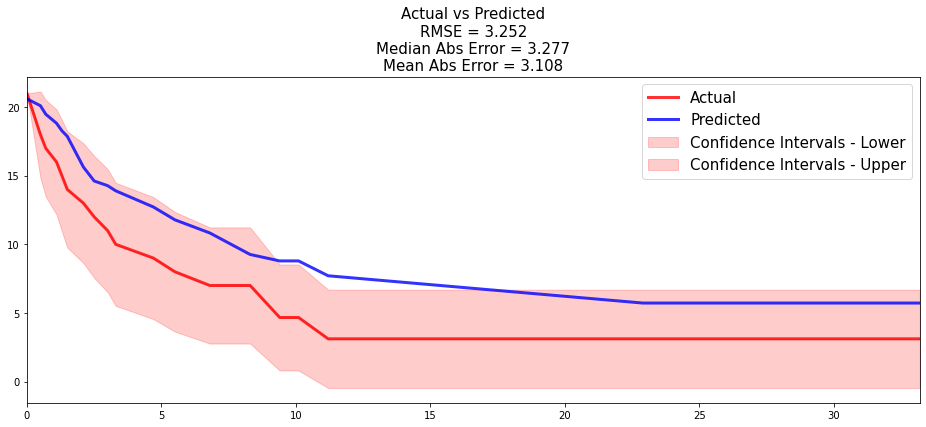

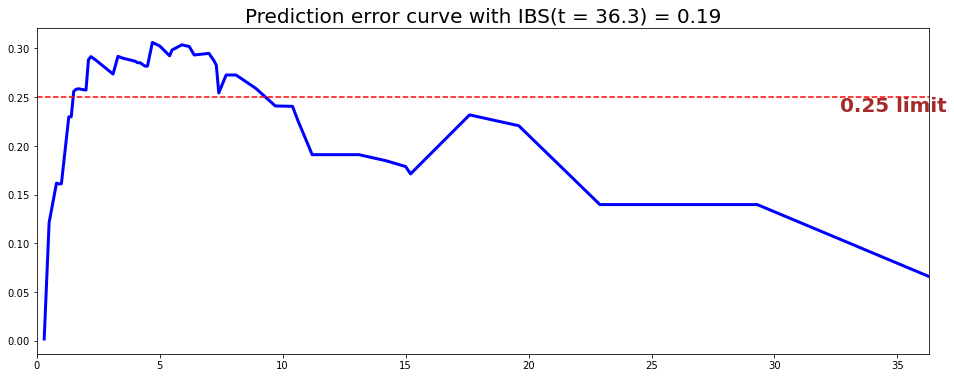

C-index: 0.59
IBS: 0.19


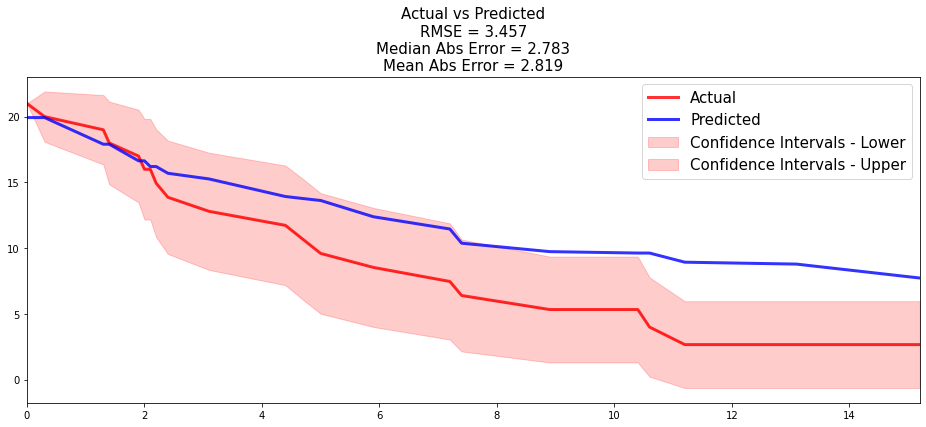

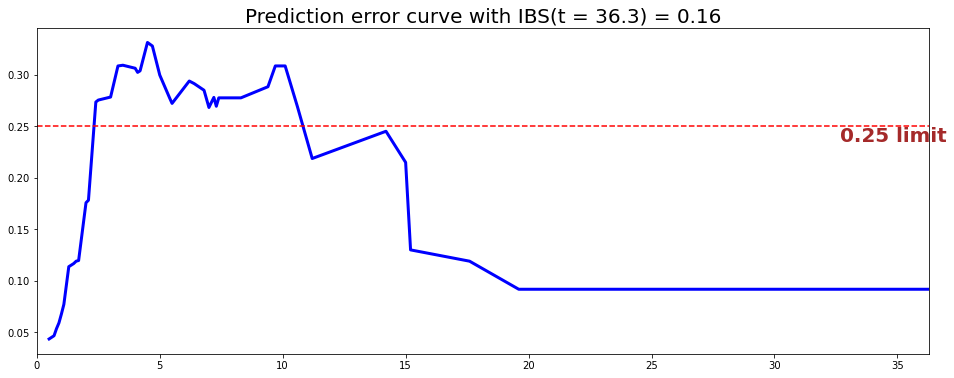

C-index: 0.51
IBS: 0.16
                                   Variable   Imp Avg   Imp Std   Pct Avg  \
0                original_glcm_ClusterShade  0.692042  1.081274  0.041130   
1                        original_glcm_Imc1 -0.032201  1.290730  0.017873   
2           original_firstorder_TotalEnergy  0.384123  0.768247  0.017259   
3           original_glcm_ClusterProminence  0.667850  0.773299  0.029171   
4        original_gldm_LowGrayLevelEmphasis  0.021795  0.896608  0.012820   
..                                      ...       ...       ...       ...   
103        original_glszm_GrayLevelVariance -0.270288  1.016348  0.012976   
104     original_shape_Maximum2DDiameterRow -0.023009  0.898629  0.011484   
105         diagnostics_Image-original_Mean -1.105186  0.498143  0.000000   
106  original_glrlm_LowGrayLevelRunEmphasis -0.354138  0.708275  0.000000   
107               original_shape_Elongation -0.638732  0.961356  0.003390   

      Pct Std  
0    0.031364  
1    0.035341  
2  

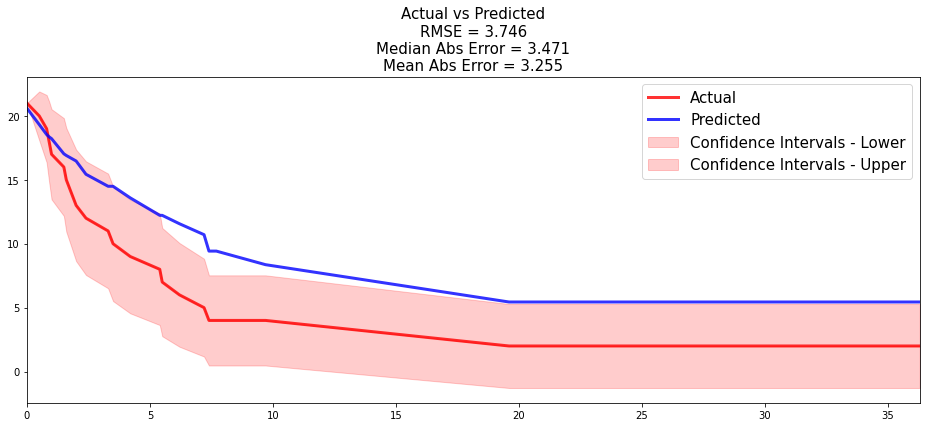

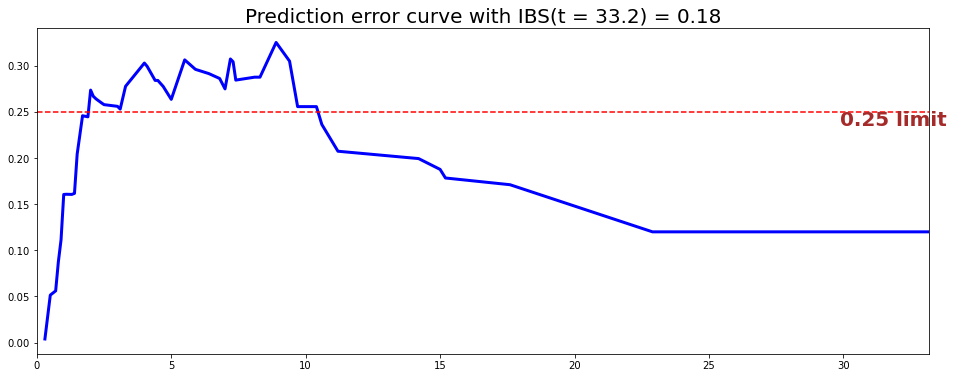

C-index: 0.51
IBS: 0.18


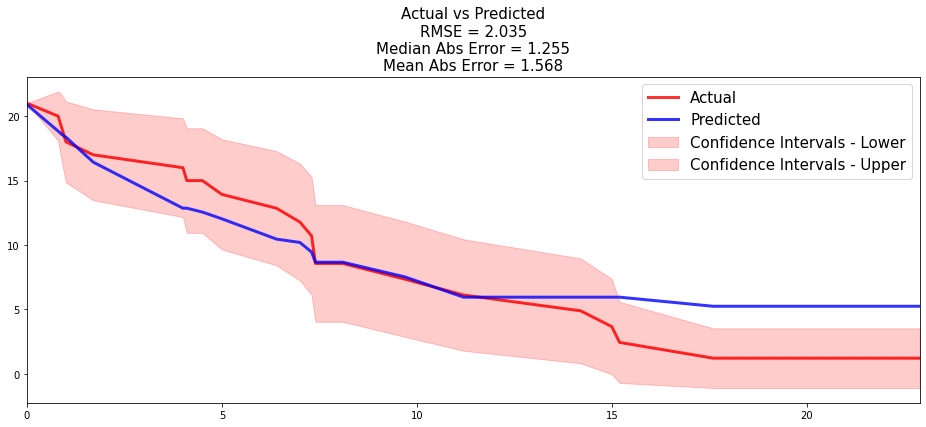

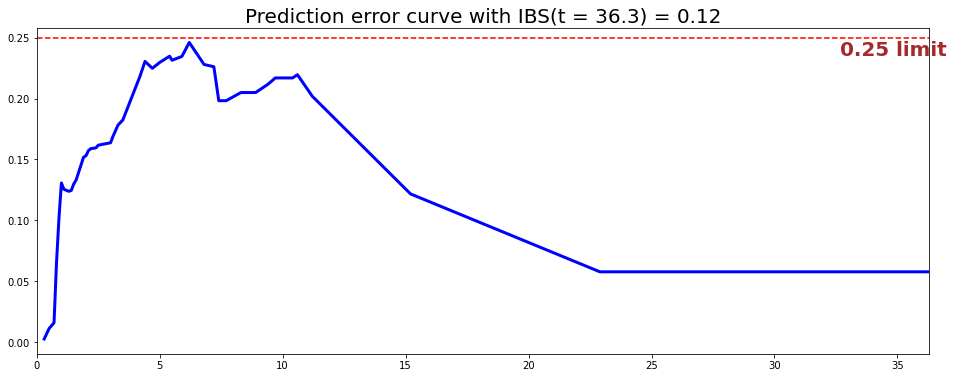

C-index: 0.63
IBS: 0.12


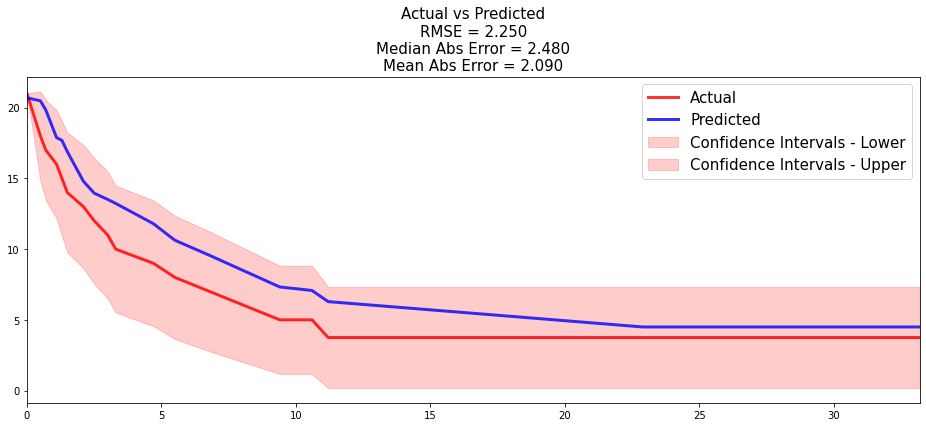

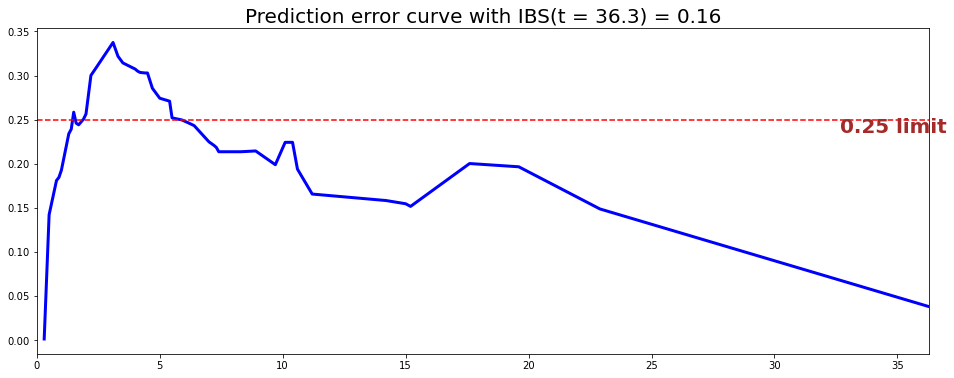

C-index: 0.56
IBS: 0.16


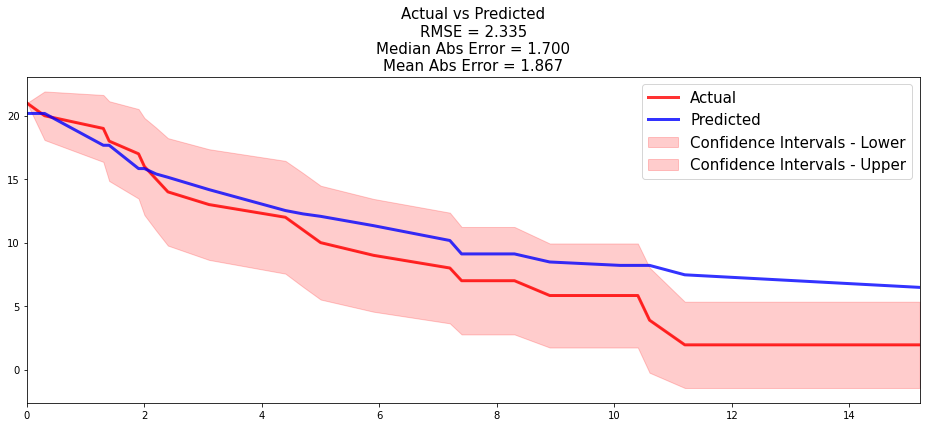

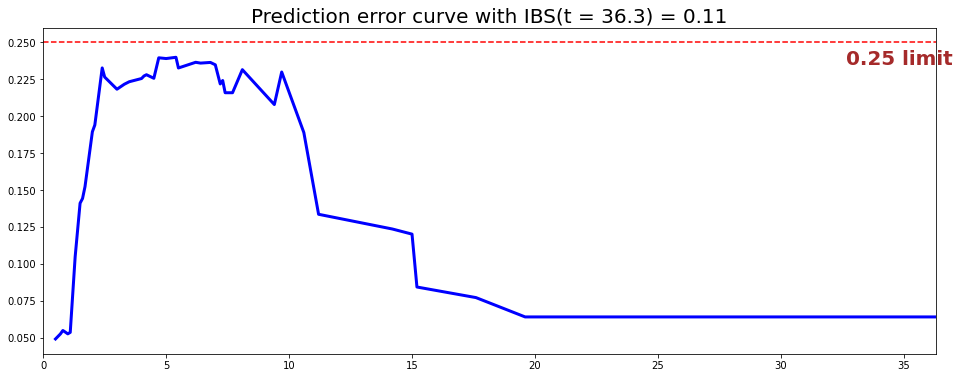

C-index: 0.54
IBS: 0.11
                                              Variable   Imp Avg   Imp Std  \
0                                   original_glcm_Imc1  1.031110  0.848204   
1    original_gldm_SmallDependenceLowGrayLevelEmphasis  0.919453  1.004051   
2    original_gldm_SmallDependenceHighGrayLevelEmph...  0.746297  0.723312   
3                                   original_glcm_Imc2  0.622223  0.740293   
4                      original_gldm_DependenceEntropy  0.663020  1.170510   
..                                                 ...       ...       ...   
103                       original_firstorder_Variance -0.650822  0.758398   
104                original_shape_Maximum2DDiameterRow -0.347277  1.114102   
105                     original_shape_MajorAxisLength  0.343928  1.392091   
106                         original_shape_VoxelVolume -0.567393  1.318299   
107        original_glrlm_LongRunHighGrayLevelEmphasis -0.052653  1.247022   

      Pct Avg   Pct Std  
0    0.028852

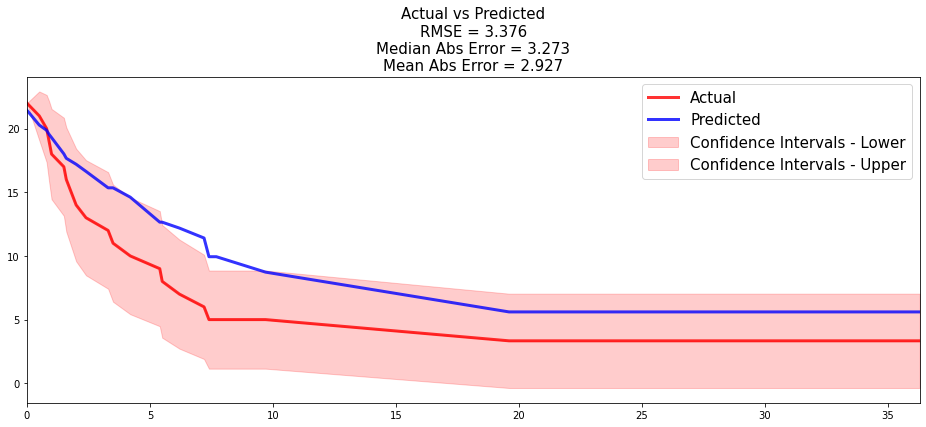

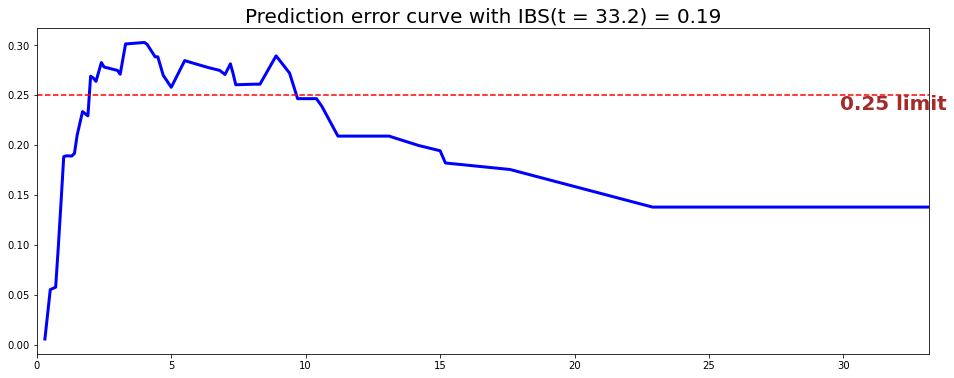

C-index: 0.54
IBS: 0.19


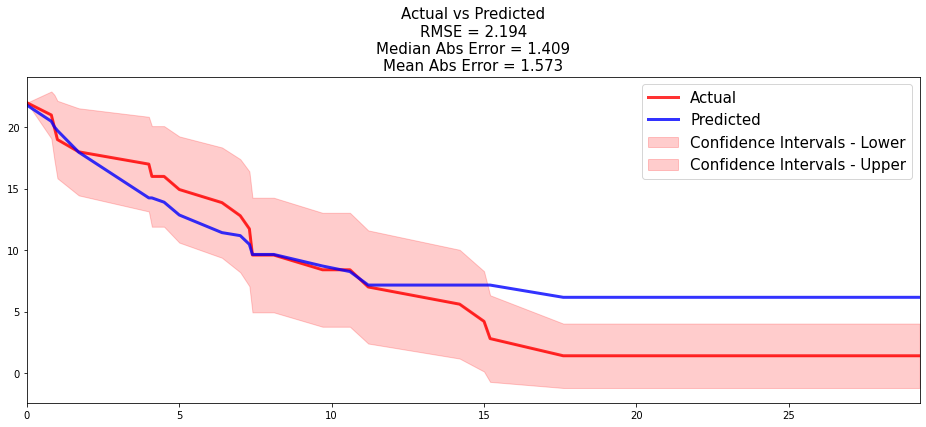

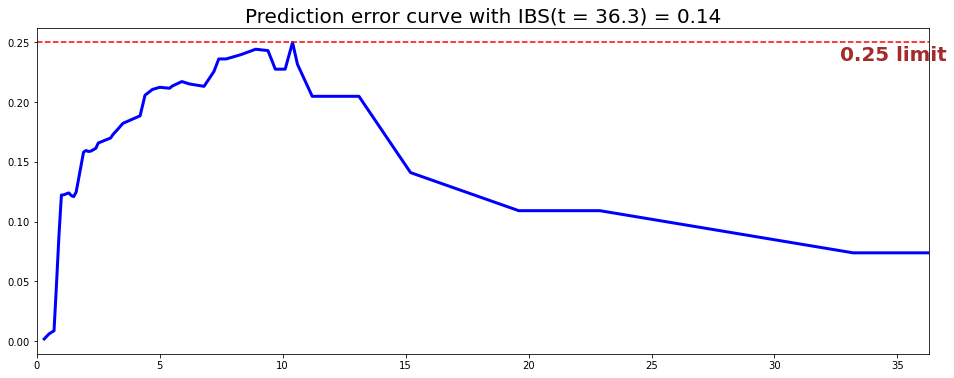

C-index: 0.62
IBS: 0.14


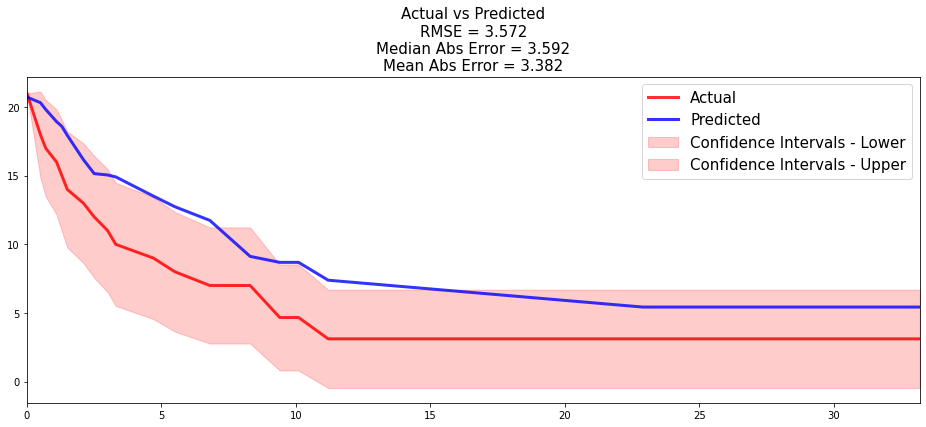

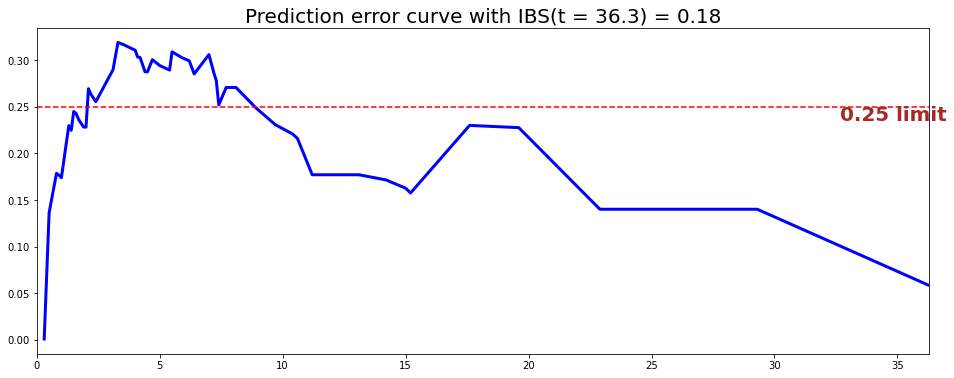

C-index: 0.54
IBS: 0.18


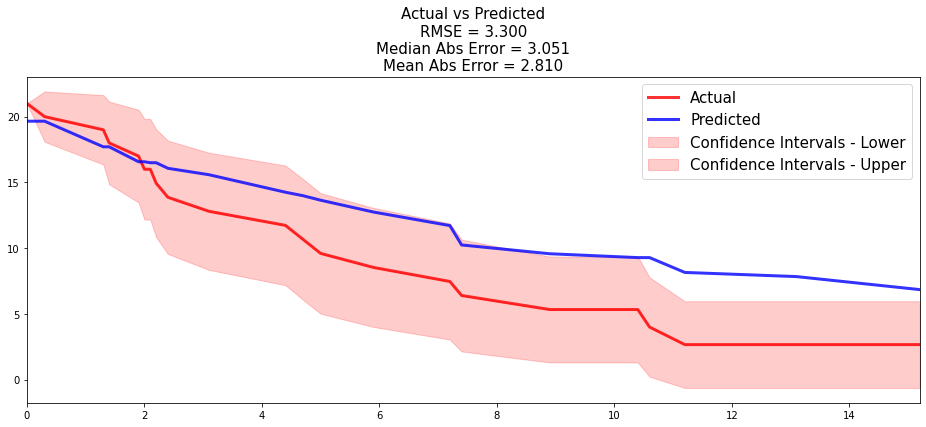

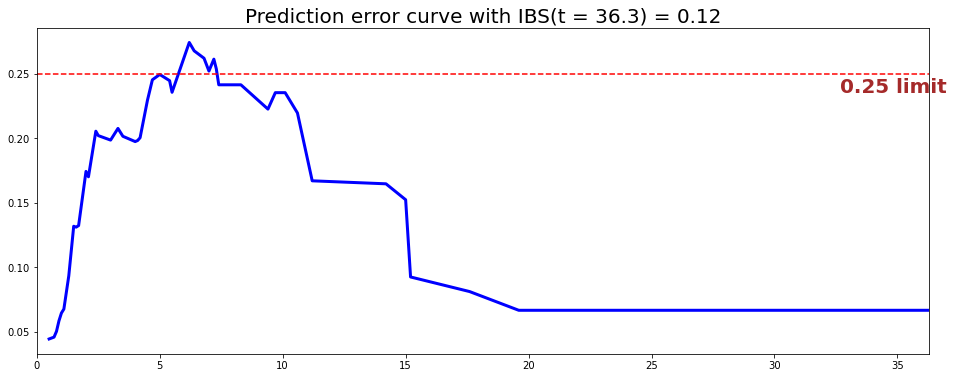

C-index: 0.65
IBS: 0.12
                                              Variable       Imp Avg  \
0           original_glrlm_LongRunLowGrayLevelEmphasis  5.153654e-01   
1                            original_shape_Sphericity  4.370848e-01   
2         original_glszm_SmallAreaLowGrayLevelEmphasis  2.804752e-01   
3                       original_shape_LeastAxisLength  5.122723e-01   
4                    original_shape_SurfaceVolumeRatio  1.124343e-01   
..                                                 ...           ...   
103  original_gldm_LargeDependenceLowGrayLevelEmphasis -5.551115e-17   
104    original_glrlm_RunLengthNonUniformityNormalized -2.587746e-01   
105                          original_shape_Elongation -1.016029e-01   
106                         original_glszm_ZoneEntropy -1.162421e-01   
107                         original_glcm_JointAverage -1.836509e-01   

      Imp Std   Pct Avg   Pct Std  
0    1.055406  0.027444  0.027067  
1    1.168530  0.025202  0.031186  
2  

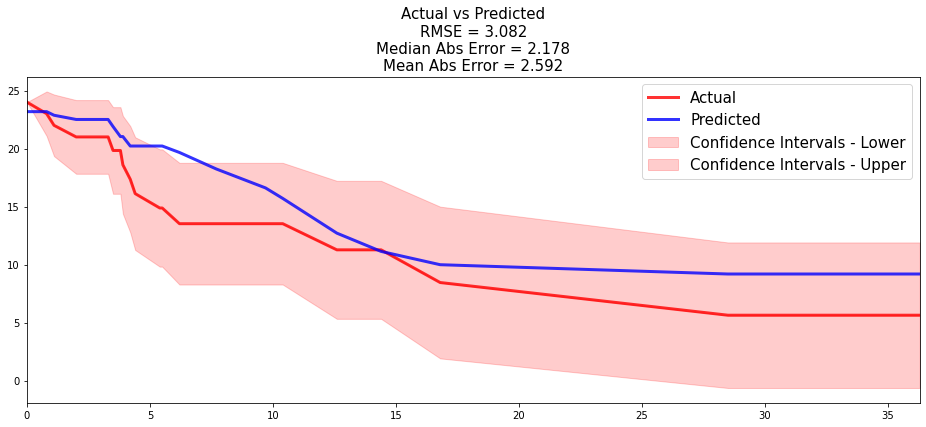

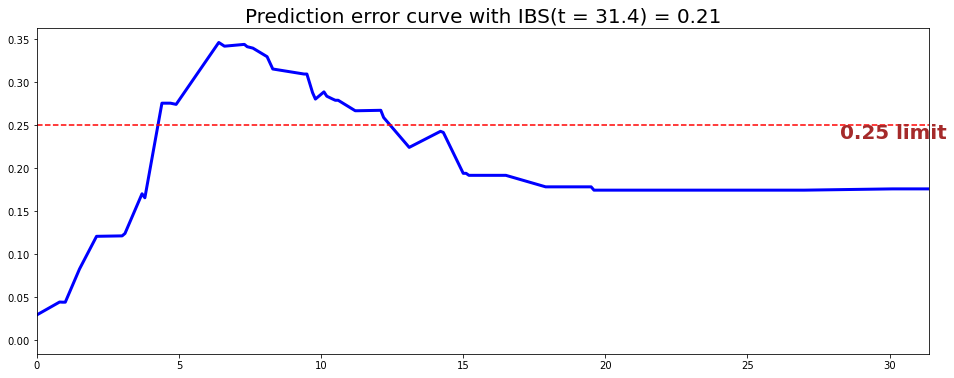

C-index: 0.60
IBS: 0.21


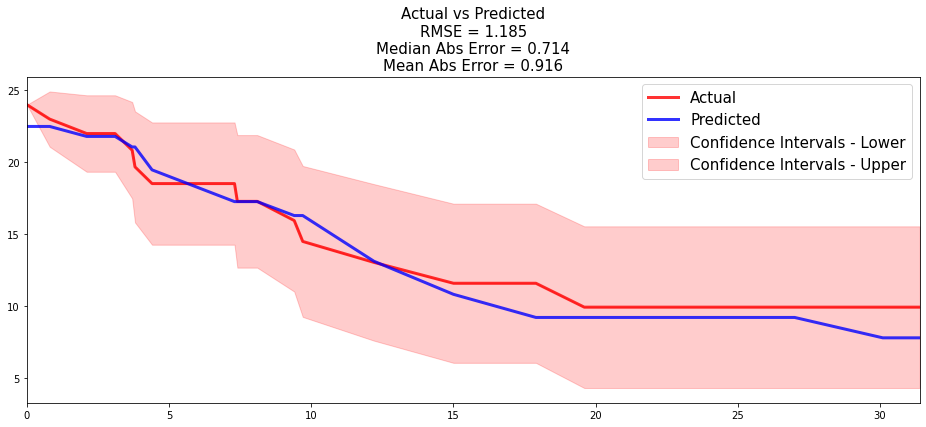

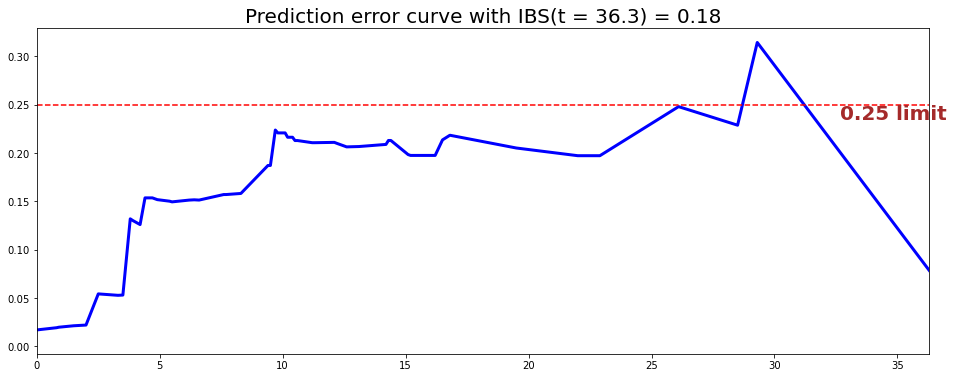

C-index: 0.71
IBS: 0.18


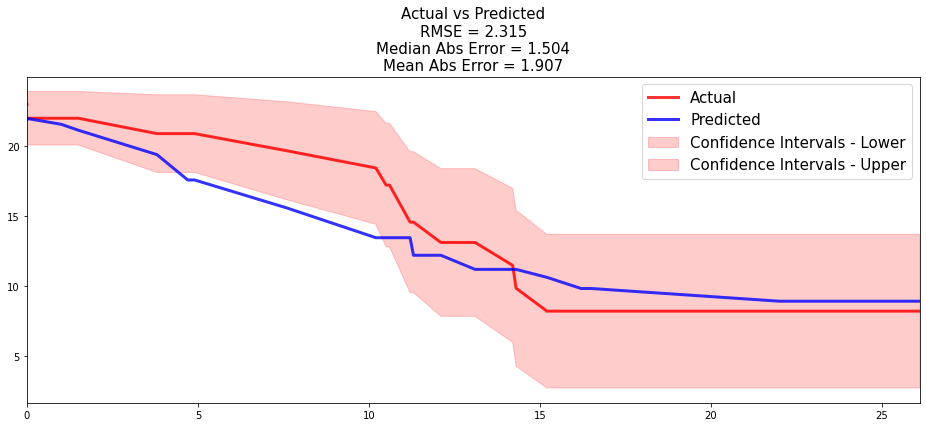

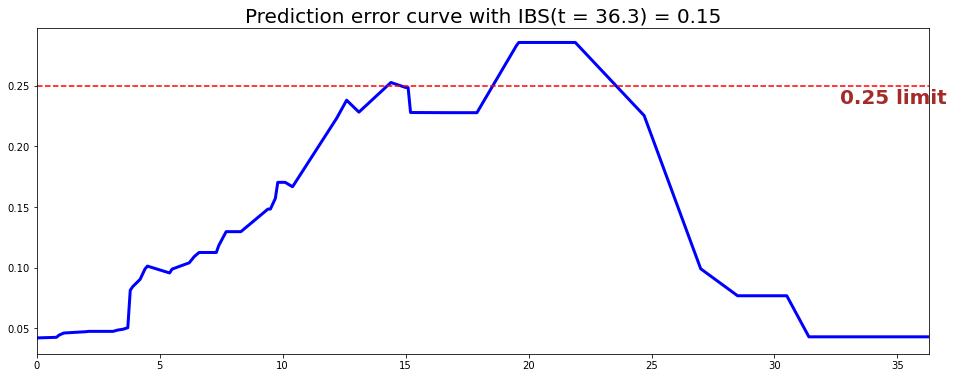

C-index: 0.67
IBS: 0.15


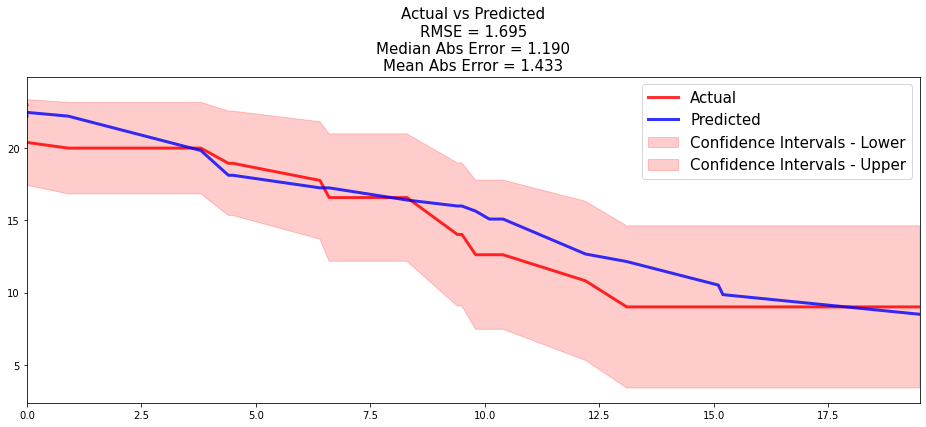

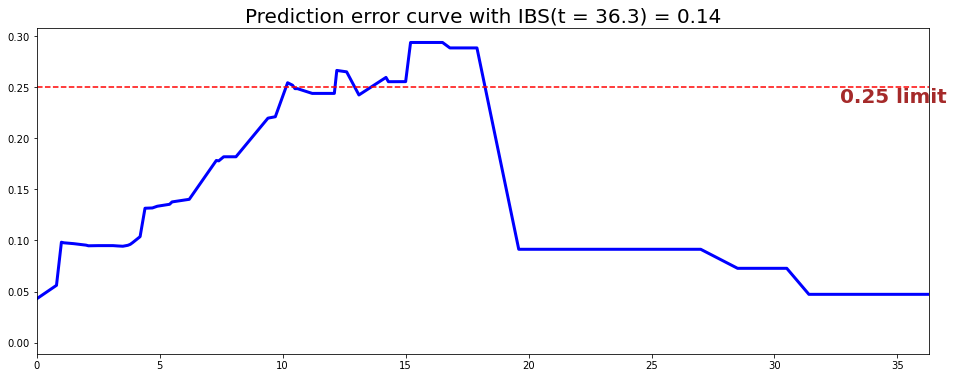

C-index: 0.65
IBS: 0.14
              Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0     PTVvolume (cm^3)  4.553269  2.008231  0.485431  0.157453
1          Lesion1Dim1  1.076420  0.890694  0.113105  0.089341
2          Lesion1Dim2  2.703238  2.832277  0.325968  0.289841
3       OtherSitesAtRT -0.943811  0.240463  0.000000  0.000000
4  NumLiverLesionsAtRT  0.054067  1.747761  0.075496  0.099164

 

Processing: clin_variables_non_imaging_fflp.csv


 

Running gridsearch on: clin_variables_non_imaging_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...



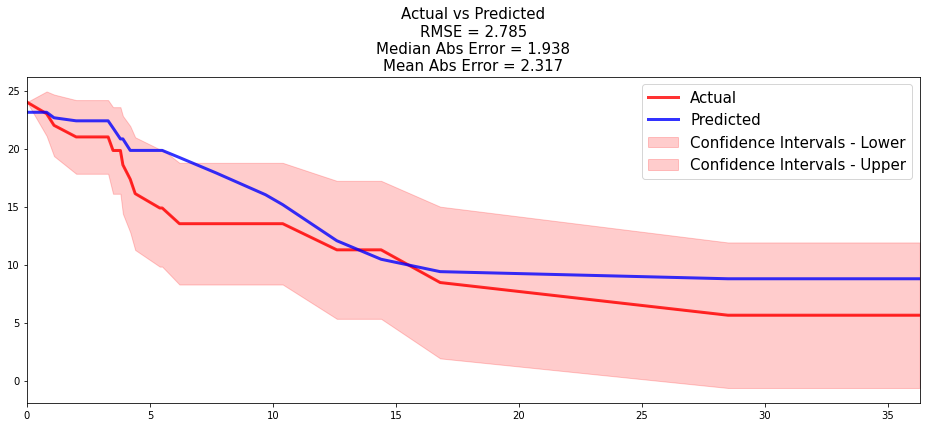

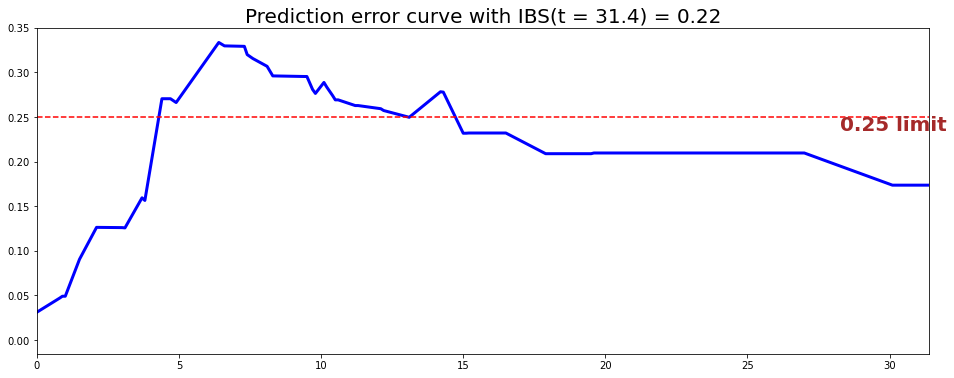

C-index: 0.52
IBS: 0.22


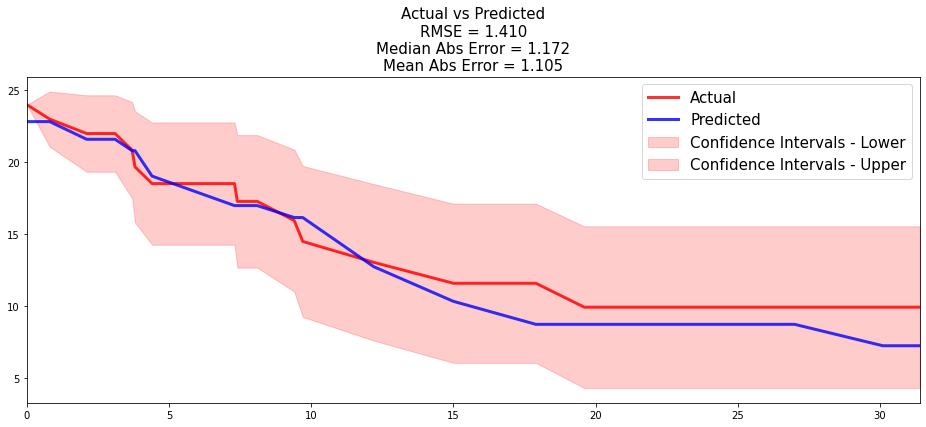

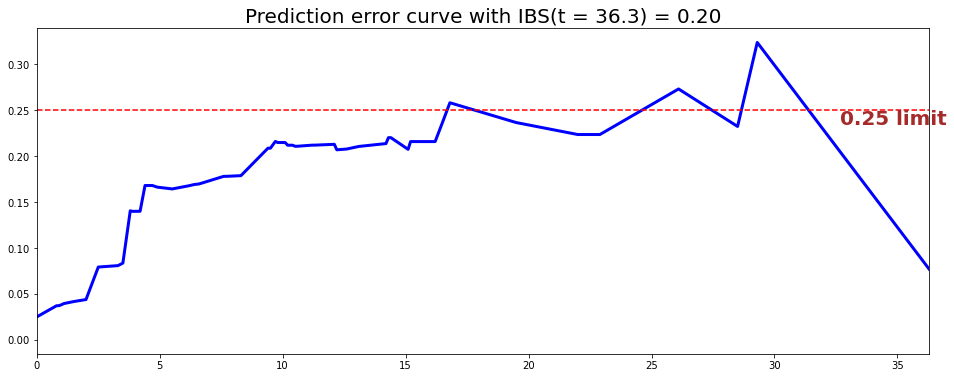

C-index: 0.76
IBS: 0.20


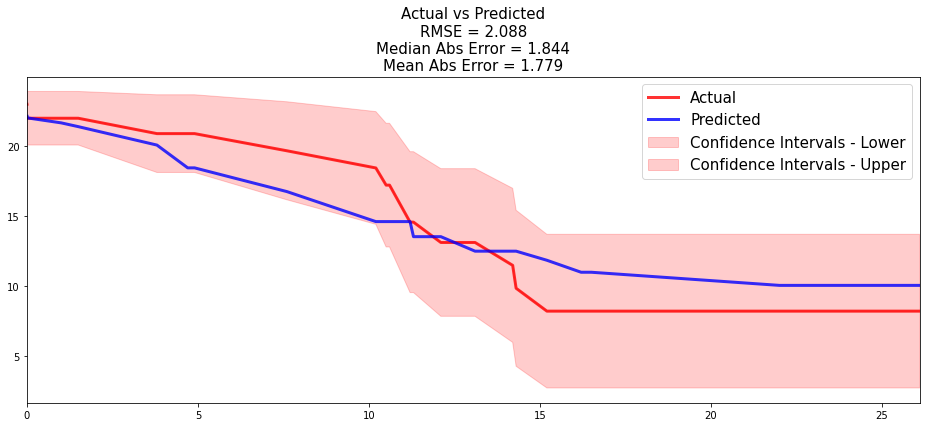

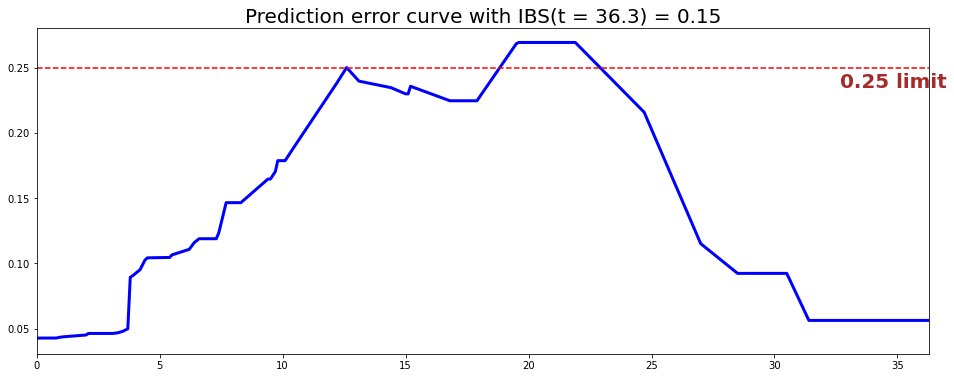

C-index: 0.61
IBS: 0.15


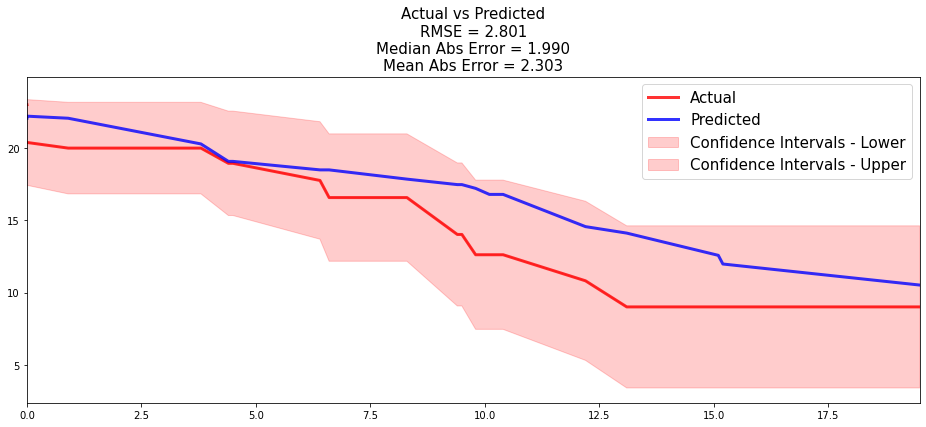

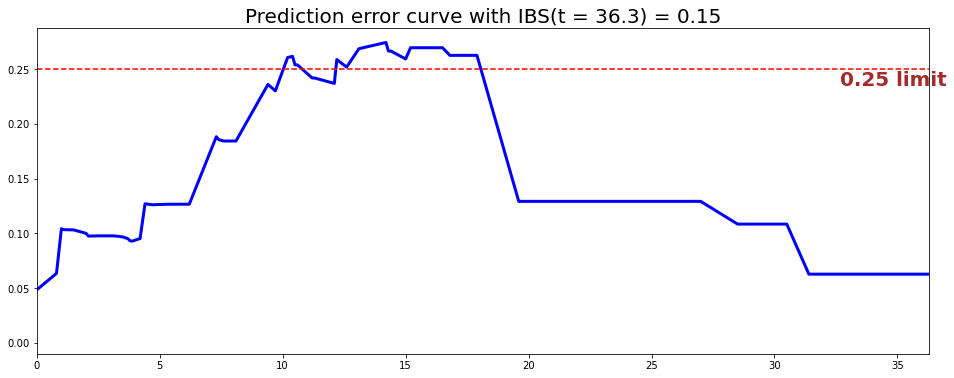

C-index: 0.68
IBS: 0.15
                       Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0              MinDosePTV (cGy)  3.220246  1.462168  0.139776  0.062739
1             D95 (dose in cGy)  2.670987  0.859908  0.120151  0.045919
2                    Dmax (cGy)  3.730317  1.969790  0.153937  0.052981
3                Lines of chemo  0.887233  2.263804  0.071176  0.068004
4              Intended Rx dose  0.059259  1.347235  0.023928  0.031227
5                     RTFxDeliv  0.472483  1.311730  0.035578  0.041032
6                OtherSitesAtDx  0.632948  0.559727  0.030371  0.025443
7                   BED (in Gy)  0.221676  0.831189  0.017845  0.021420
8               cM at diagnosis  0.228704  0.457408  0.010671  0.021342
9                   Dose per fx  2.071054  1.783325  0.103883  0.112700
10                       Gender  0.213386  0.923121  0.021561  0.025042
11                      RTnumFx  0.221691  1.334827  0.033058  0.024601
12                    Histology  0.00000

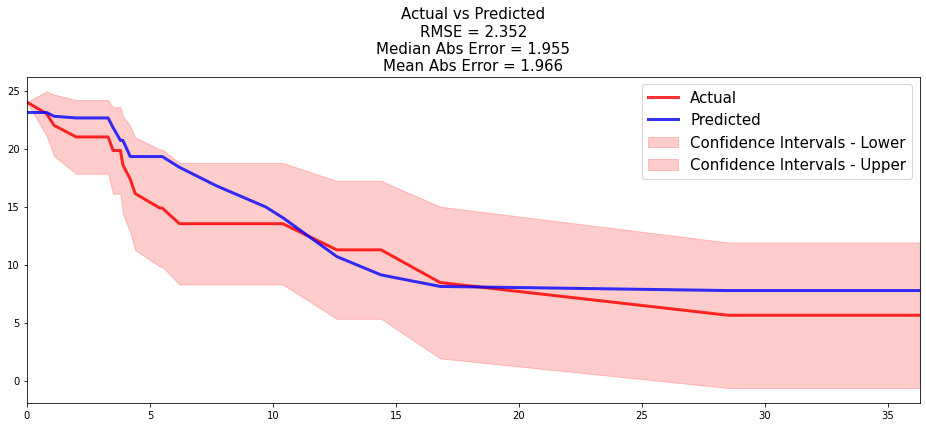

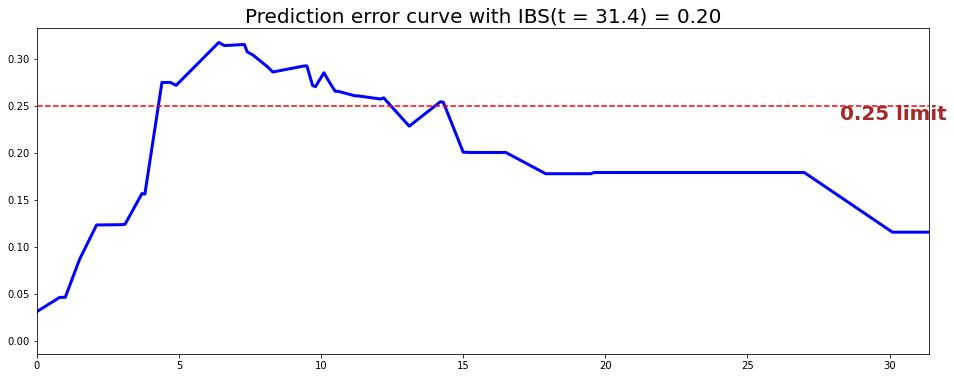

C-index: 0.62
IBS: 0.20


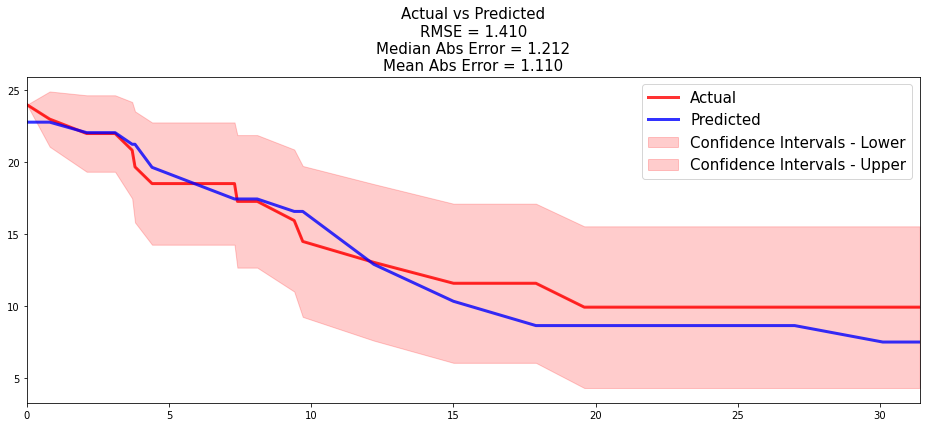

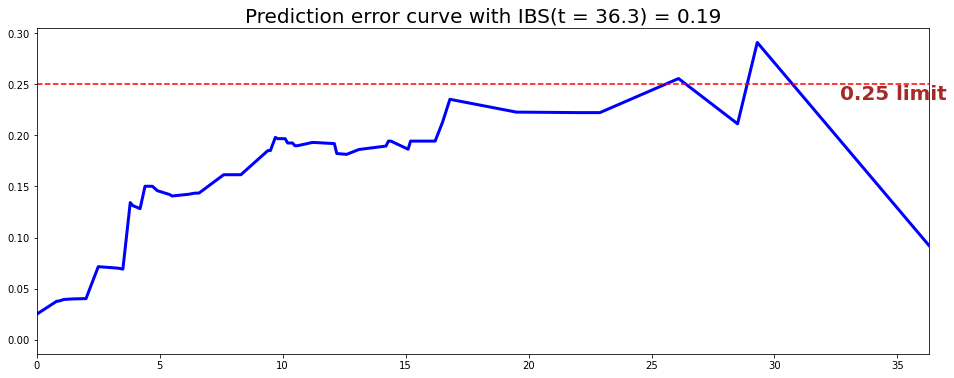

C-index: 0.78
IBS: 0.19


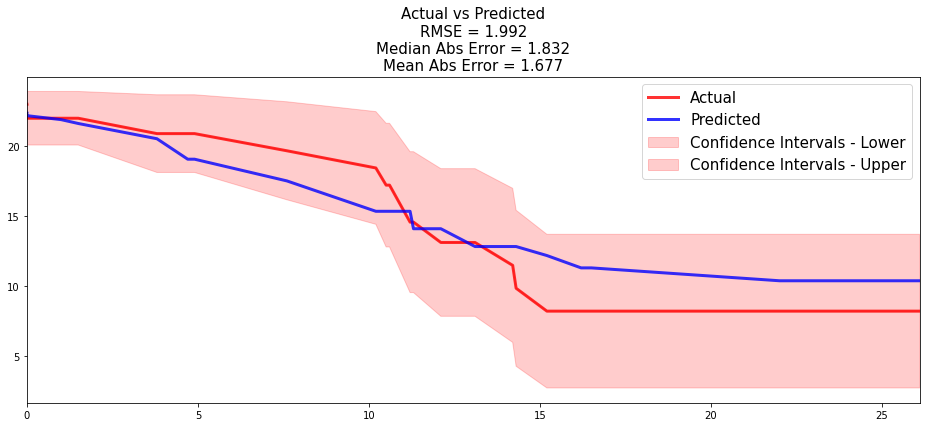

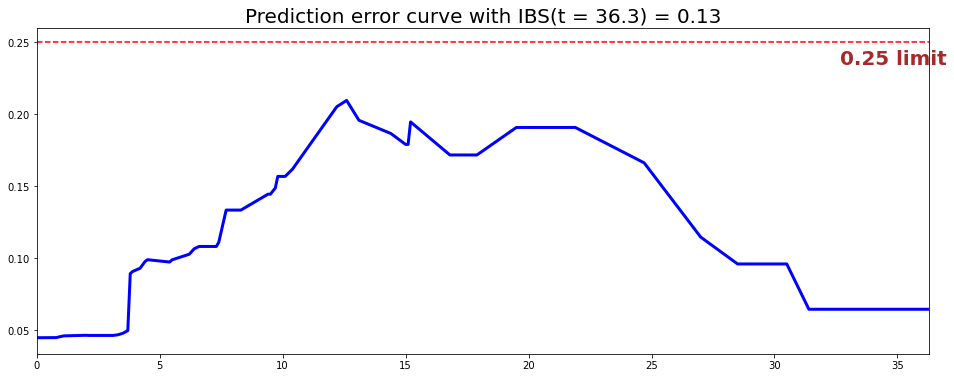

C-index: 0.72
IBS: 0.13


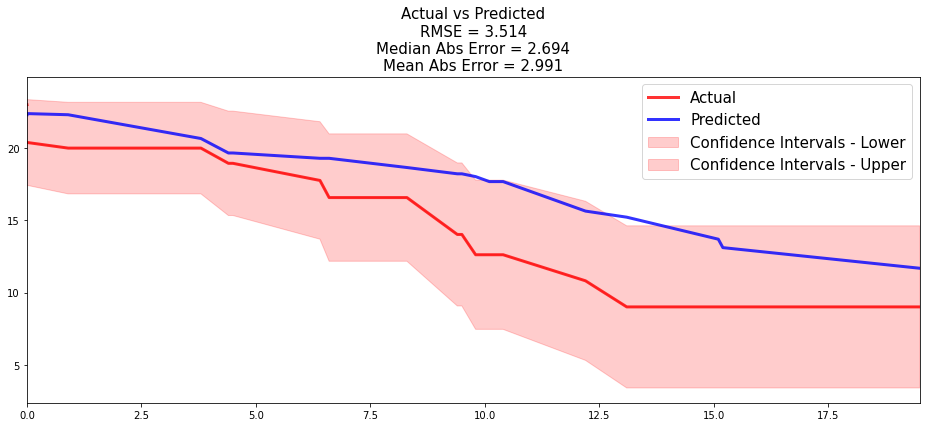

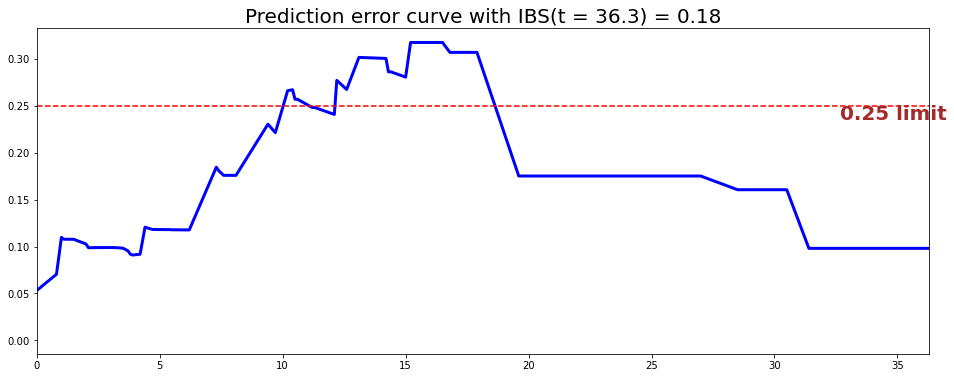

C-index: 0.64
IBS: 0.18
                      Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0             MinDosePTV (cGy)  7.127106  3.367035  0.399774  0.077794
1                   Dmax (cGy)  6.246577  2.560384  0.370646  0.149280
2                      CEAatRT  0.913449  1.200954  0.054178  0.041114
3  D95 (% of intended Rx dose)  0.523534  0.983085  0.041702  0.039748
4               Lines of chemo  0.791038  1.750137  0.076063  0.125573
5                 KRASmutation  0.747702  0.608949  0.046824  0.046784
6                  BED (in Gy) -0.709809  0.913119  0.001771  0.002396
7             SystemicBeforeRT -0.250627  0.501255  0.000000  0.000000
8                 PumpBeforeRT -0.746989  1.114327  0.009042  0.018084

 

Processing: clin_variables_imaging_hp.csv


 

Running gridsearch on: clin_variables_imaging_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...



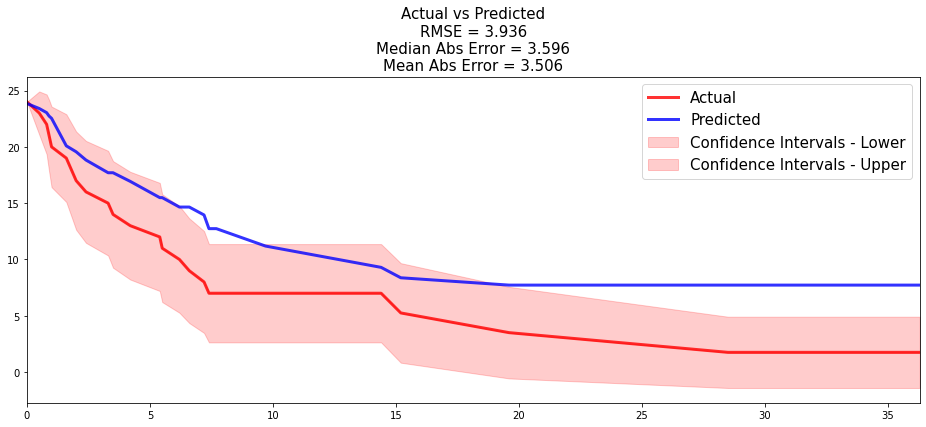

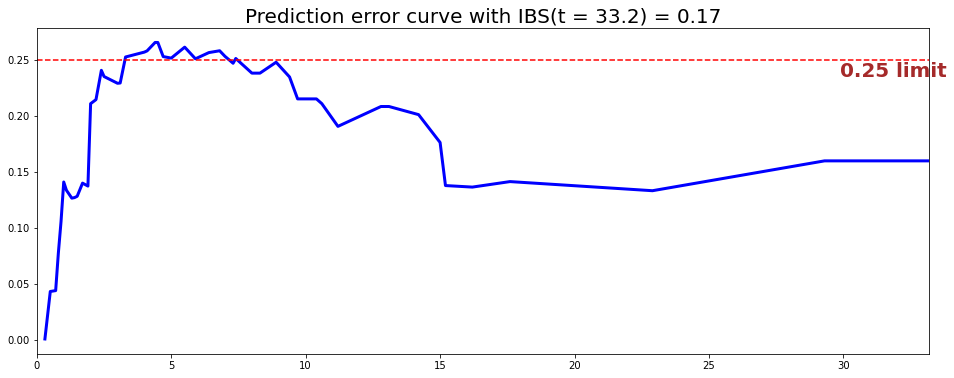

C-index: 0.63
IBS: 0.17


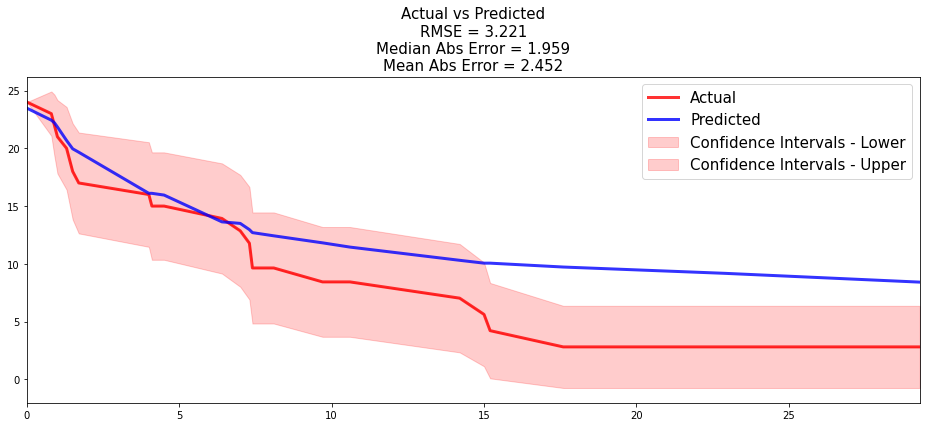

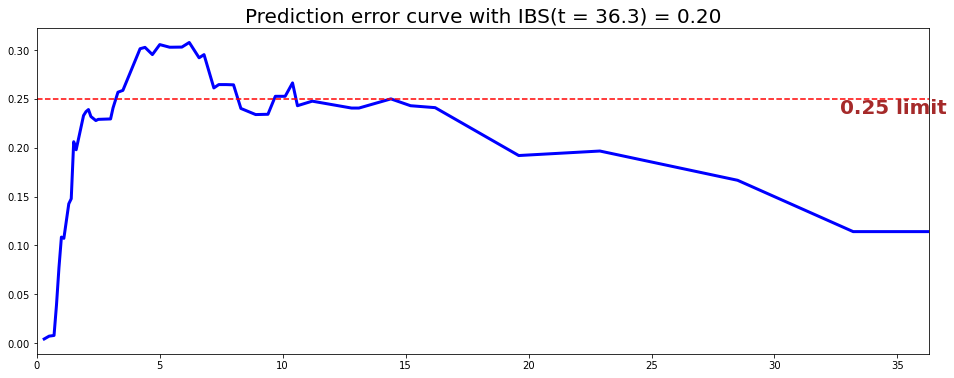

C-index: 0.55
IBS: 0.20


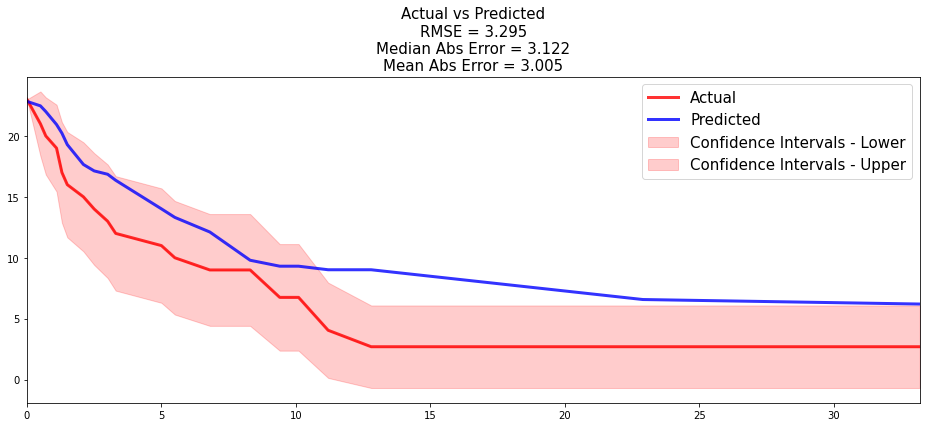

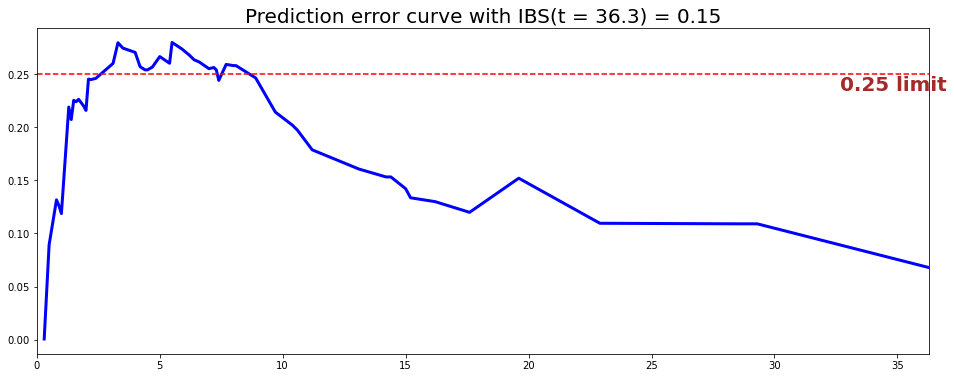

C-index: 0.59
IBS: 0.15


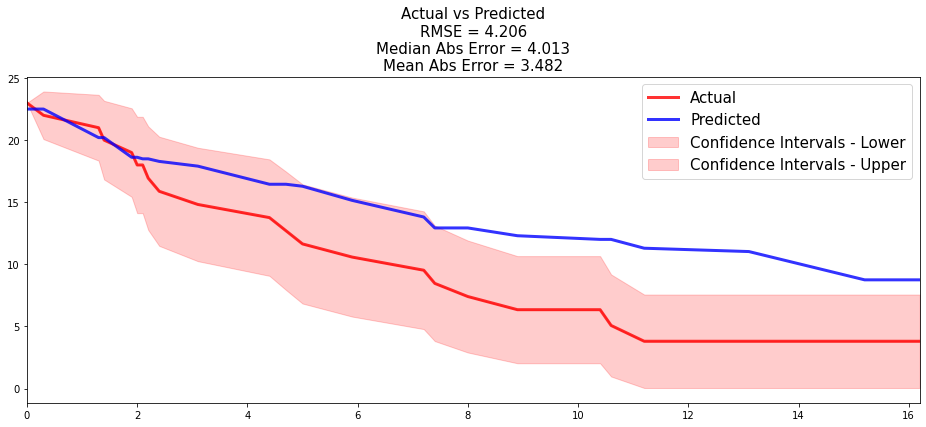

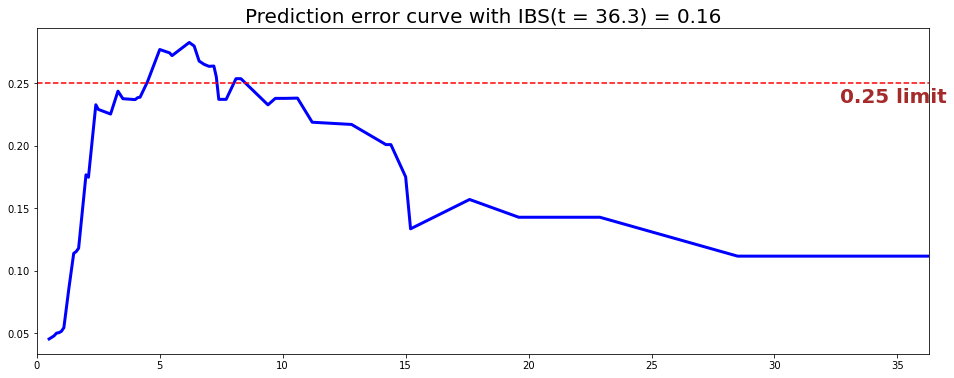

C-index: 0.58
IBS: 0.16
              Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0          Lesion1Dim2  3.253820  0.387923  0.520828  0.141446
1          Lesion1Dim1  0.108884  1.597971  0.103547  0.153348
2     PTVvolume (cm^3)  0.597417  0.817953  0.115917  0.129770
3       OtherSitesAtRT  1.928705  2.827302  0.259708  0.306122
4  NumLiverLesionsAtRT -0.744422  0.222603  0.000000  0.000000

 

Processing: clin_variables_non_imaging_hp.csv


 

Running gridsearch on: clin_variables_non_imaging_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...



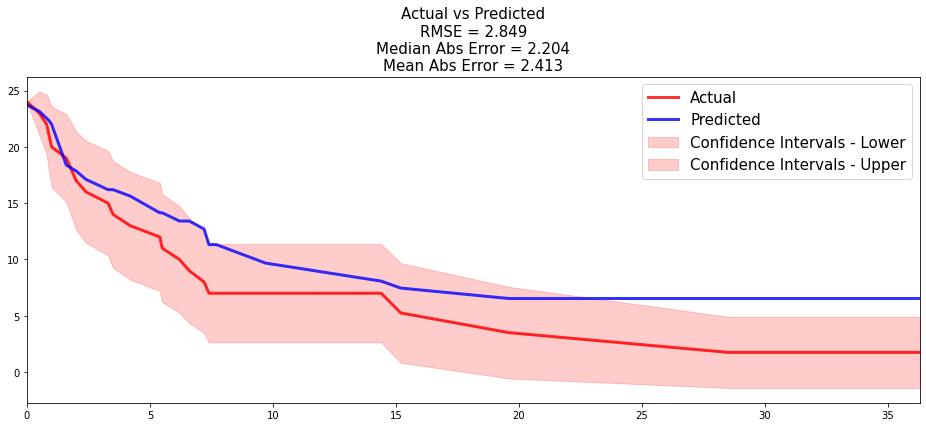

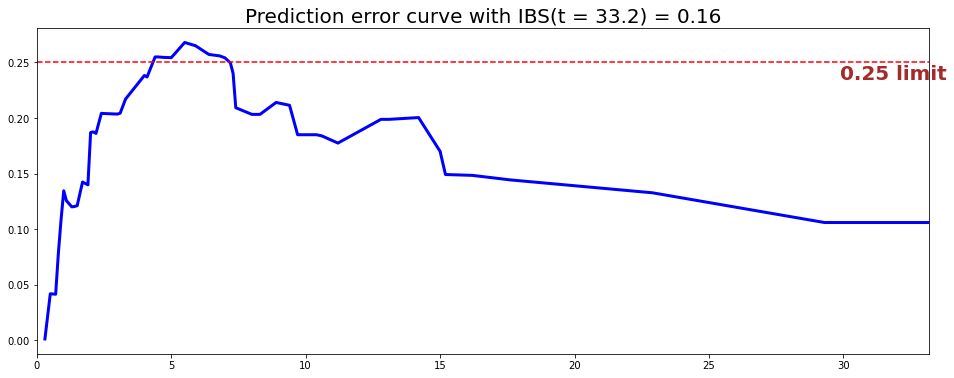

C-index: 0.63
IBS: 0.16


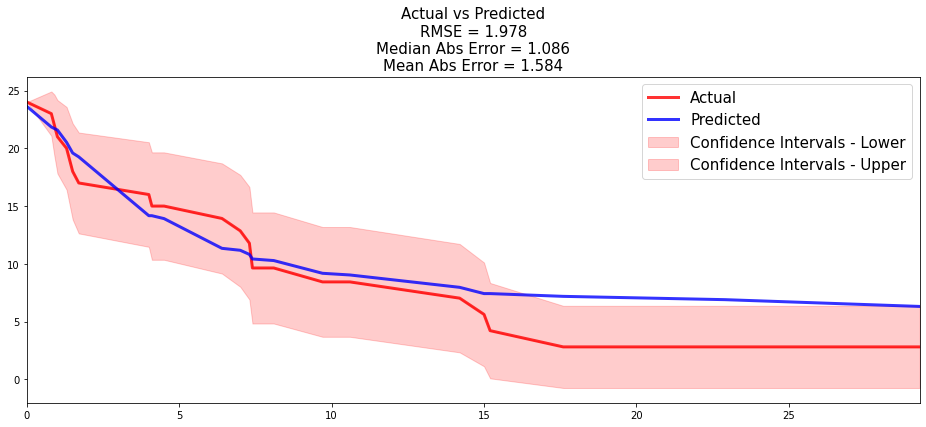

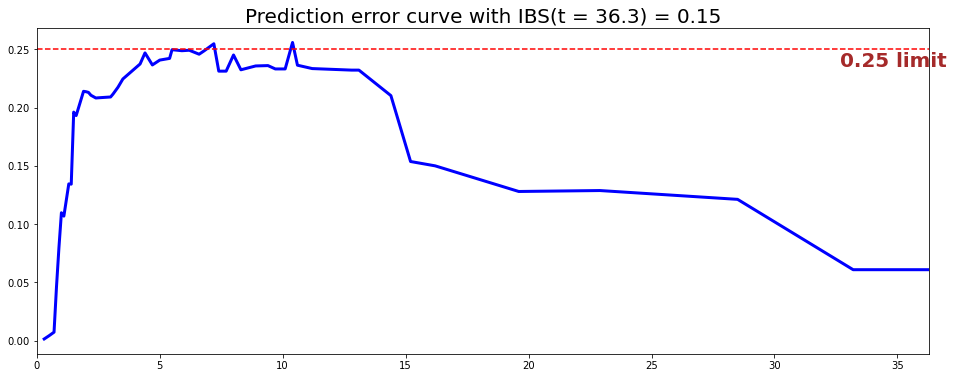

C-index: 0.55
IBS: 0.15


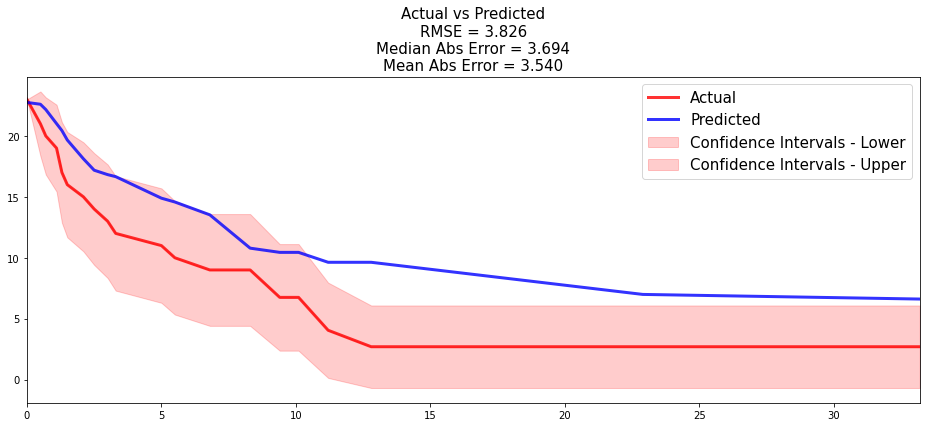

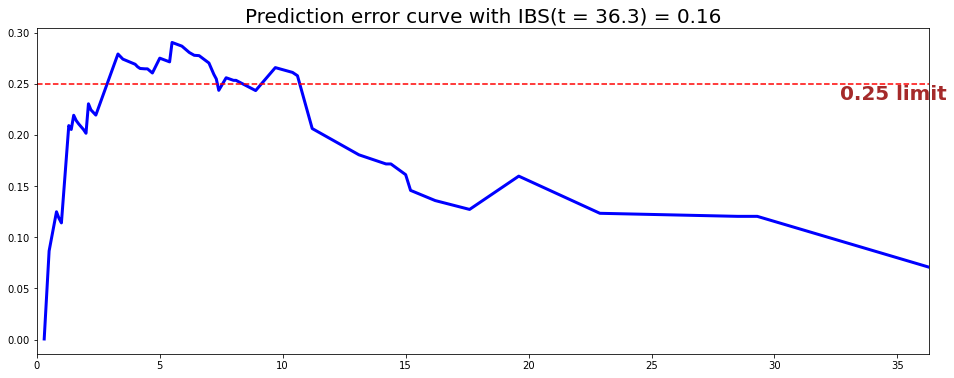

C-index: 0.56
IBS: 0.16


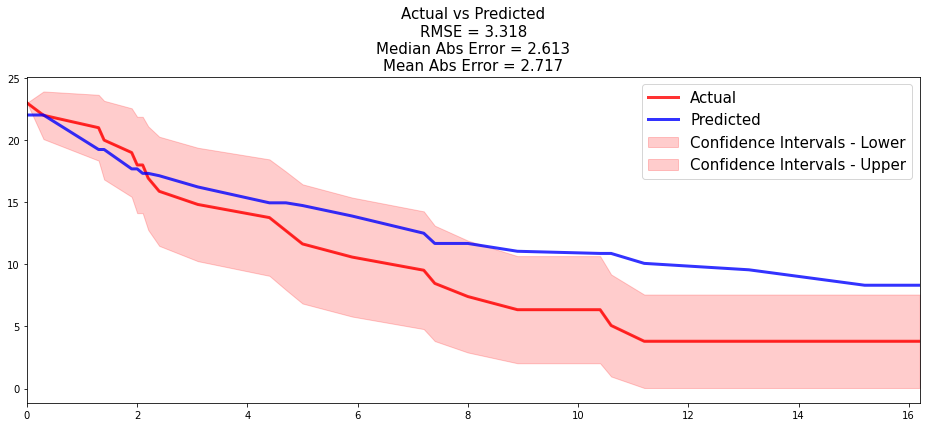

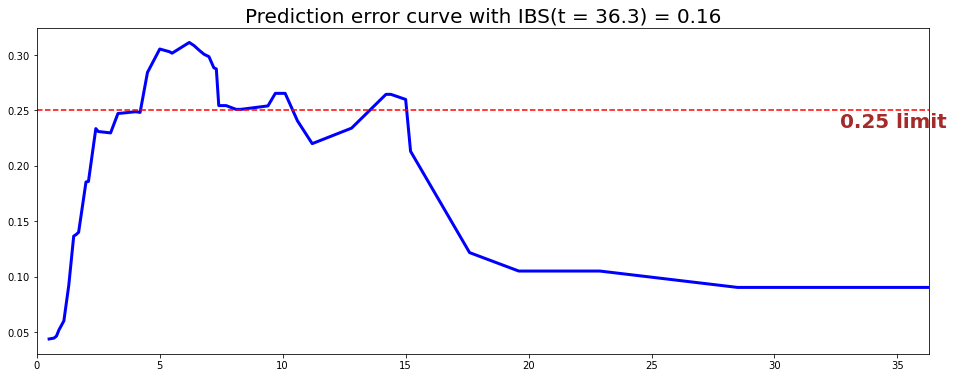

C-index: 0.53
IBS: 0.16
                       Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0                       CEAatDx  2.830201  3.003683  0.173367  0.184085
1                       CEAatRT  5.307317  0.634418  0.275586  0.061045
2                Lines of chemo  2.256057  1.057071  0.115313  0.058273
3                RFAtoRTlesions  0.437412  1.198191  0.036122  0.041893
4              LiverLocation2Tx  1.167341  1.685463  0.068004  0.055497
5                       RTnumFx -0.531746  0.818206  0.009036  0.018073
6                OtherSitesAtDx -0.015242  1.800996  0.027777  0.041851
7                  DosePainting  0.450415  0.482465  0.019551  0.020043
8              SystemicBeforeRT -0.250627  0.501255  0.000000  0.000000
9                     Histology  0.000000  0.000000  0.000000  0.000000
10                  Y90BeforeRT  0.831801  0.994195  0.039386  0.035744
11              cM at diagnosis  0.803792  0.928918  0.050153  0.050730
12                   RTPlanDose -0.67295

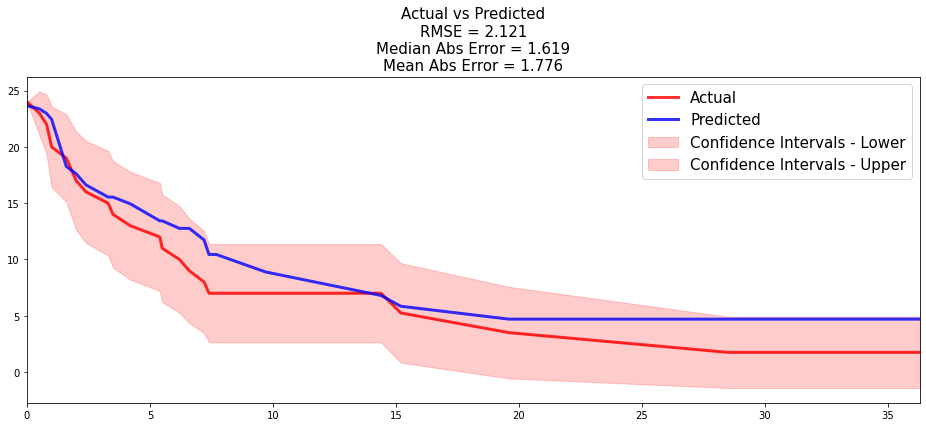

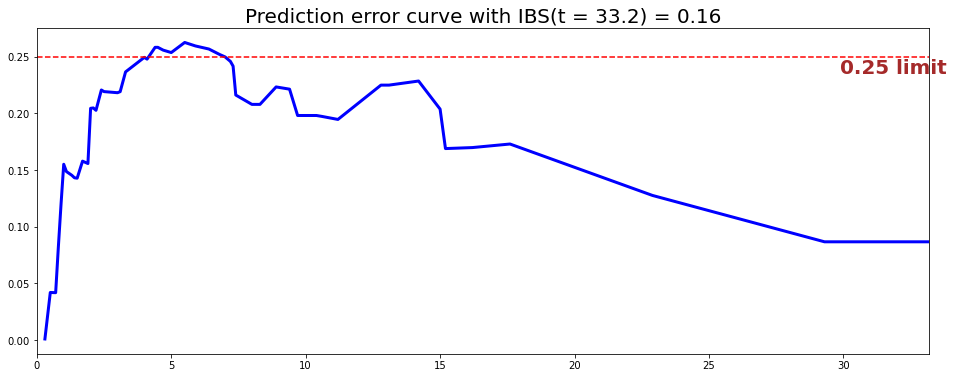

C-index: 0.52
IBS: 0.16


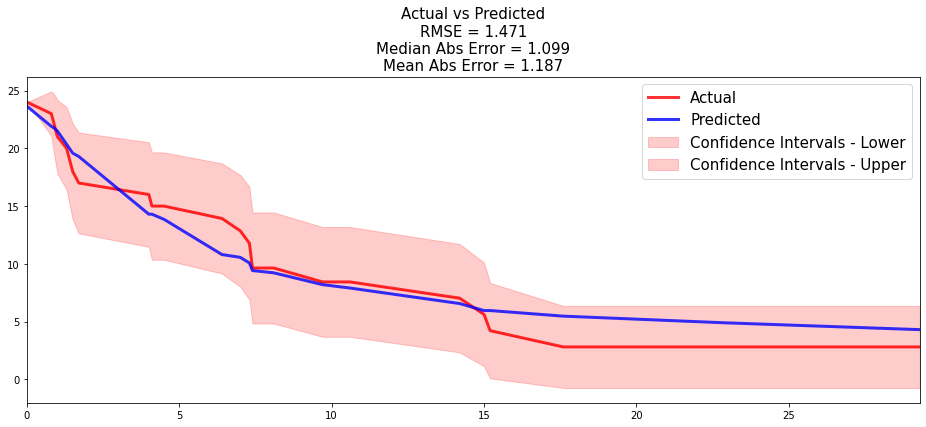

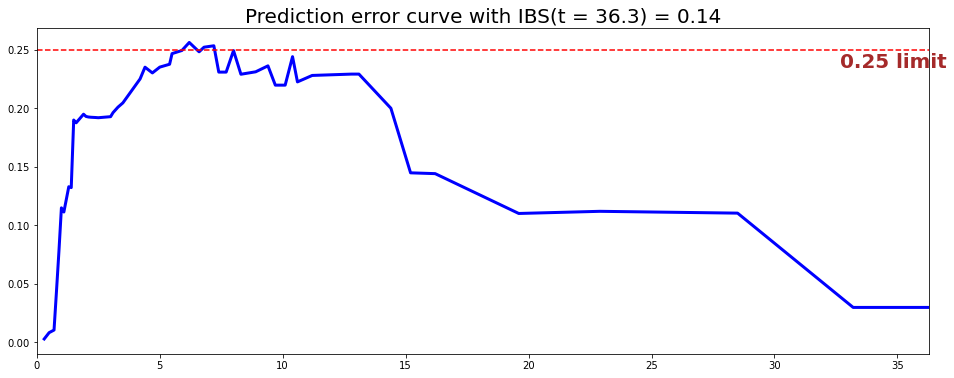

C-index: 0.63
IBS: 0.14


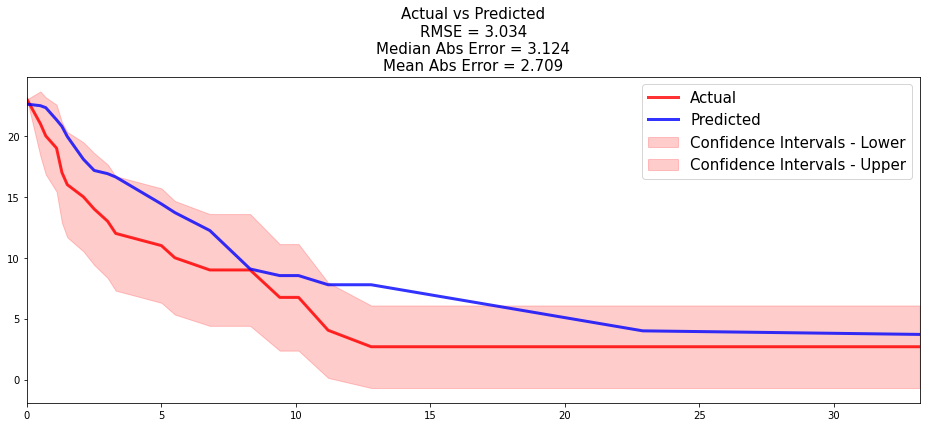

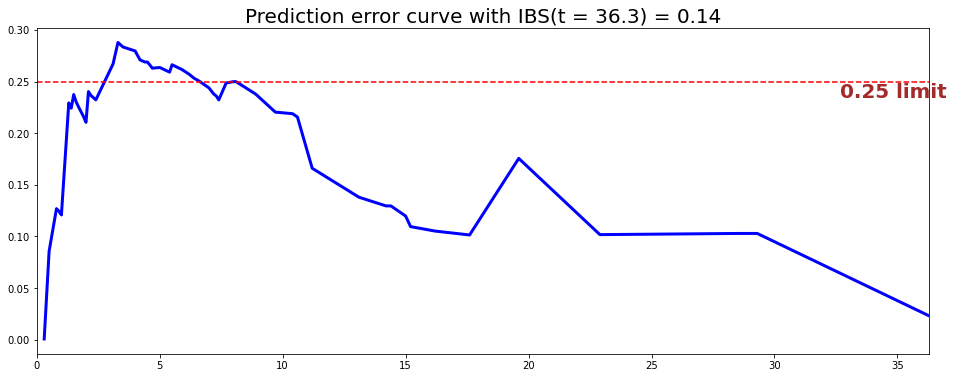

C-index: 0.57
IBS: 0.14


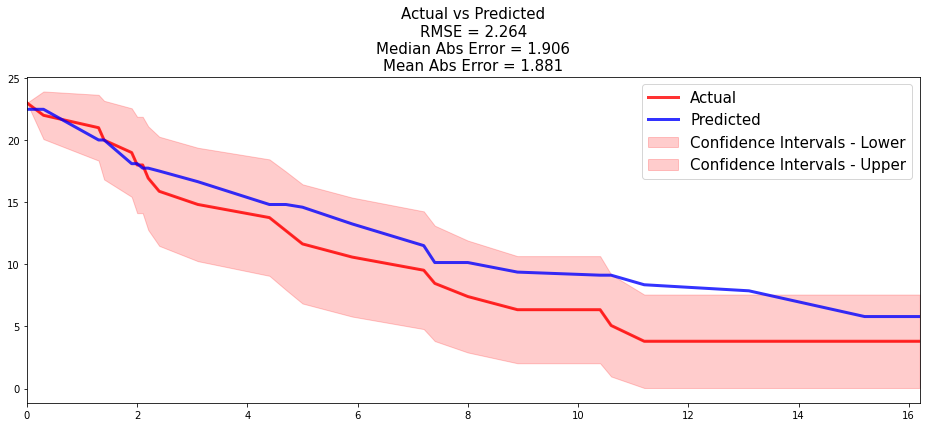

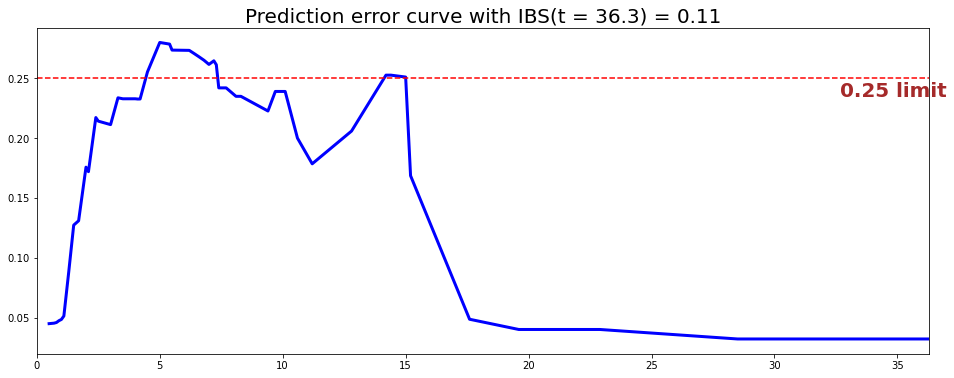

C-index: 0.50
IBS: 0.11
                      Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0               Lines of chemo  2.122740  1.966604  0.302504  0.215827
1                      CEAatRT  2.615146  0.328837  0.491448  0.246943
2                   Dmax (cGy)  0.600919  0.232116  0.110485  0.048359
3             SystemicBeforeRT  0.000000  0.000000  0.000000  0.000000
4                 PumpBeforeRT -0.009715  1.265415  0.065014  0.075297
5                  BED (in Gy) -1.138152  1.117677  0.008818  0.017635
6                 KRASmutation -0.510603  0.808526  0.011996  0.023992
7  D95 (% of intended Rx dose) -0.546419  0.759945  0.009736  0.019471
8             MinDosePTV (cGy) -1.816408  1.094307  0.000000  0.000000

 

Processing: rads_plus_imaging_fflp.csv


 

Running gridsearch on: rads_plus_imaging_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...



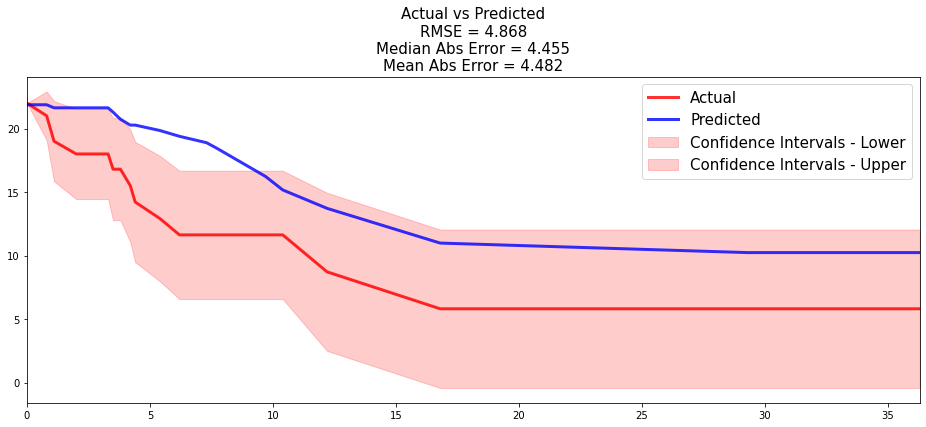

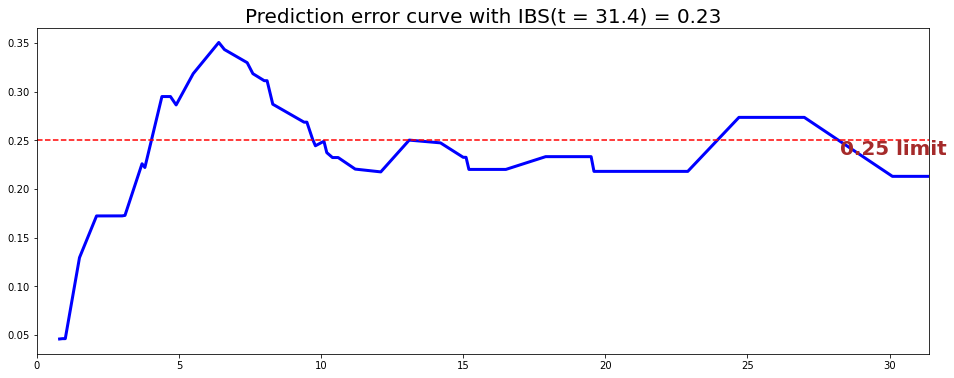

C-index: 0.64
IBS: 0.23


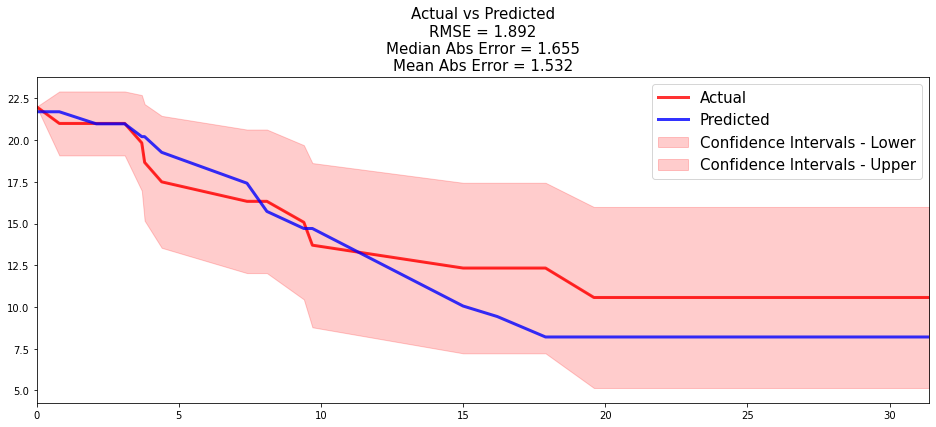

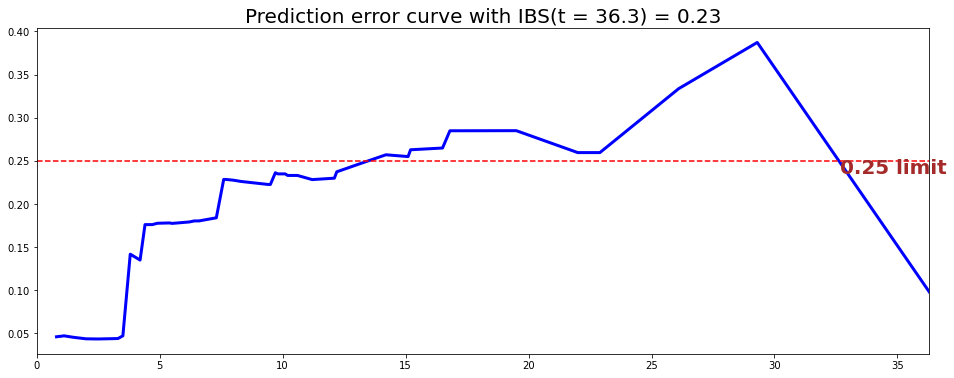

C-index: 0.60
IBS: 0.23


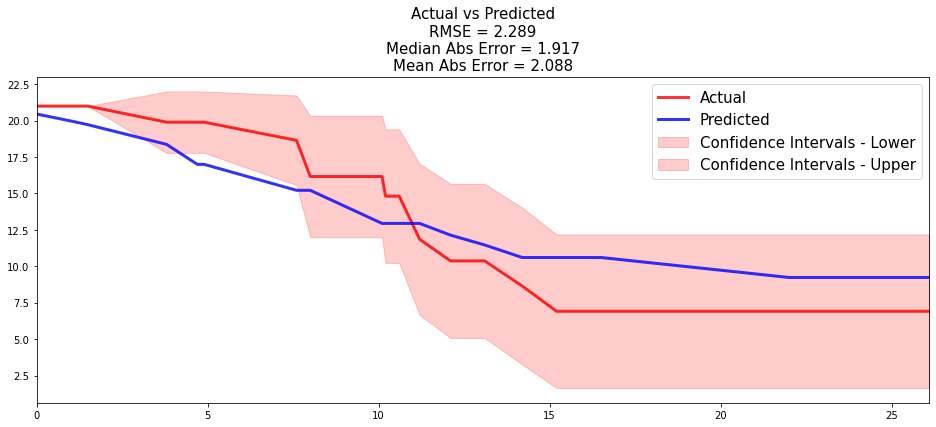

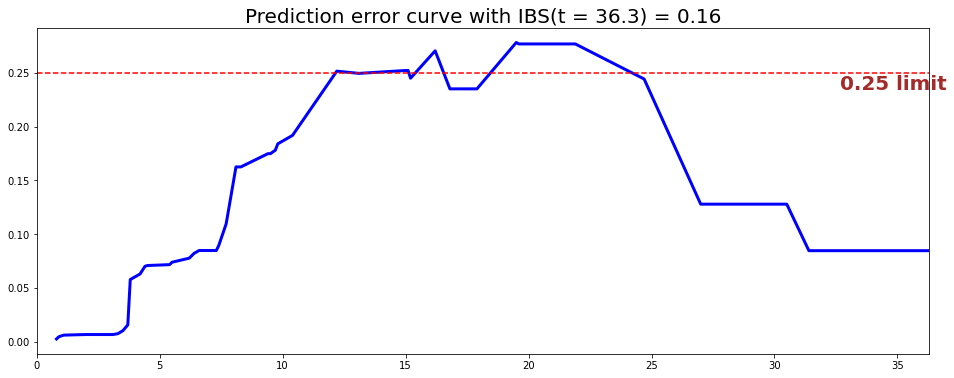

C-index: 0.64
IBS: 0.16


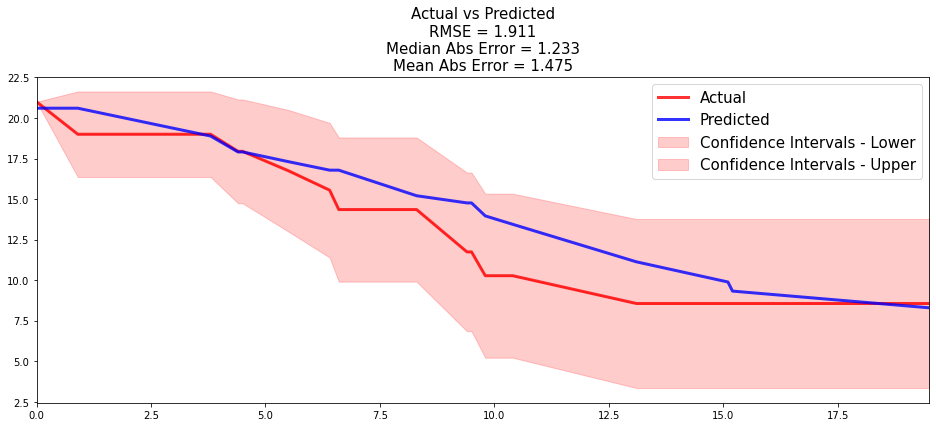

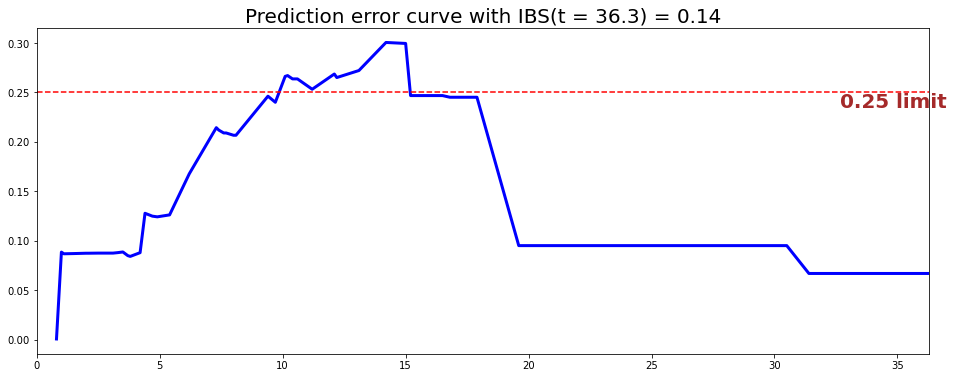

C-index: 0.56
IBS: 0.14
                                            Variable   Imp Avg   Imp Std  \
0                          original_shape_MeshVolume  0.632218  0.753655   
1     original_glszm_SizeZoneNonUniformityNormalized  0.552041  0.639926   
2                                   PTVvolume (cm^3)  0.184541  0.584060   
3        original_glrlm_LongRunHighGrayLevelEmphasis  0.018562  0.815124   
4                           original_glcm_SumEntropy  0.517549  0.597614   
..                                               ...       ...       ...   
108                     original_firstorder_Kurtosis  0.000000  0.845154   
109                   original_shape_MajorAxisLength -0.258775  0.517549   
110  original_firstorder_RobustMeanAbsoluteDeviation -0.258775  0.517549   
111  original_glszm_GrayLevelNonUniformityNormalized  0.000000  0.845154   
112                          original_ngtdm_Strength -0.258775  0.517549   

      Pct Avg   Pct Std  
0    0.040294  0.046821  
1    0.0276

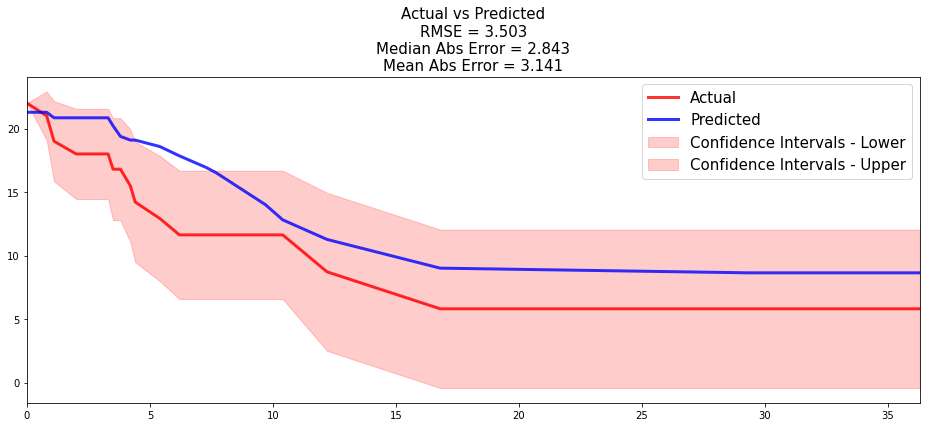

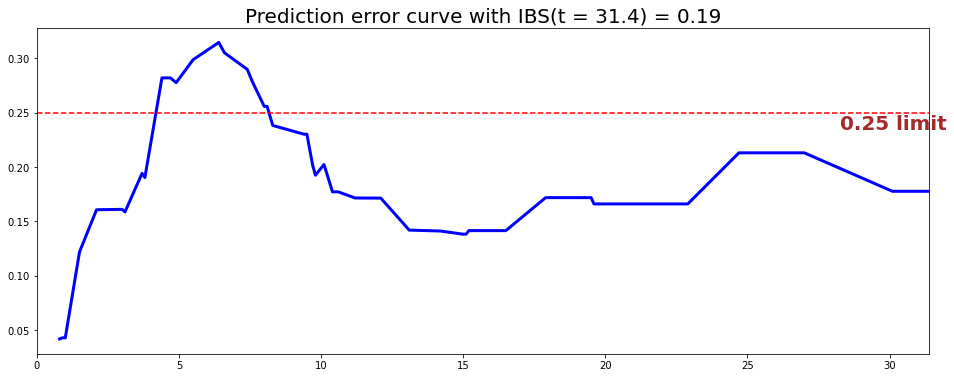

C-index: 0.70
IBS: 0.19


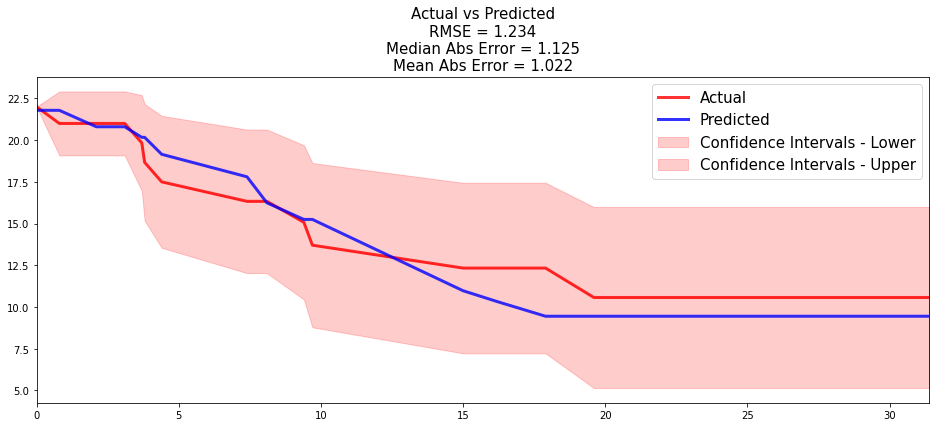

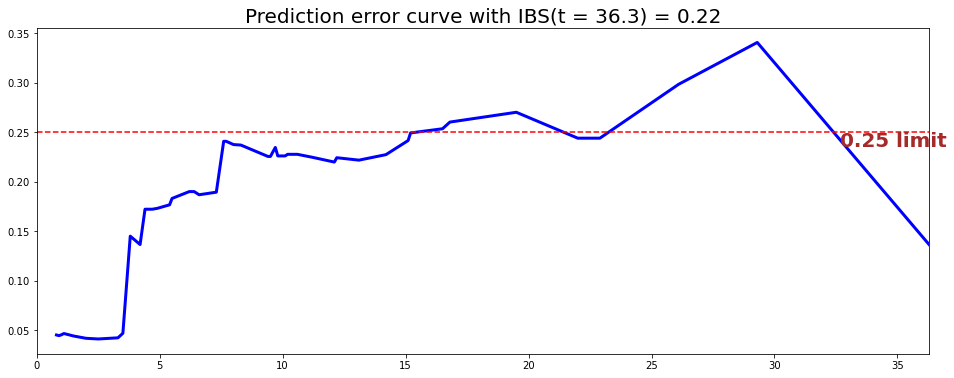

C-index: 0.62
IBS: 0.22


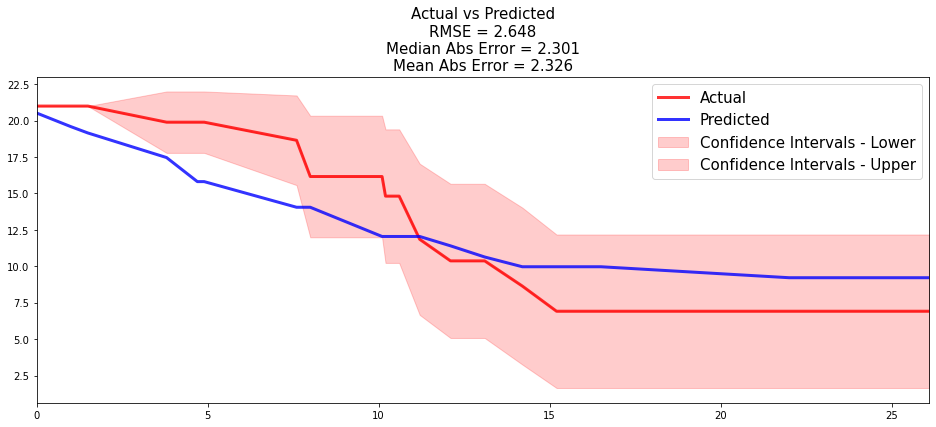

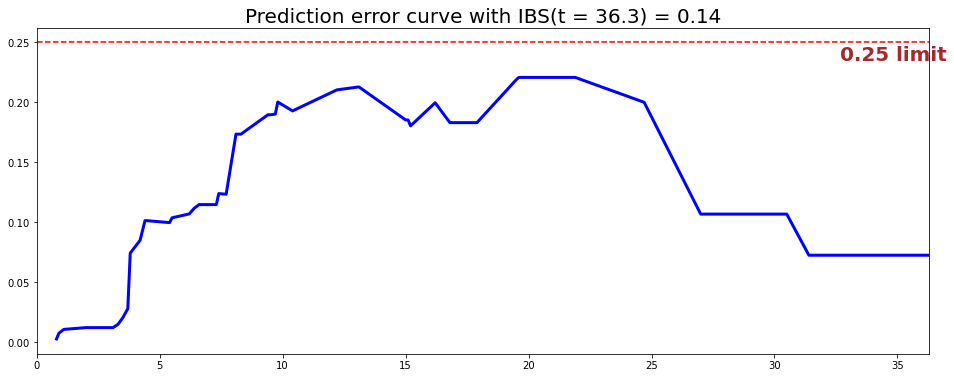

C-index: 0.76
IBS: 0.14


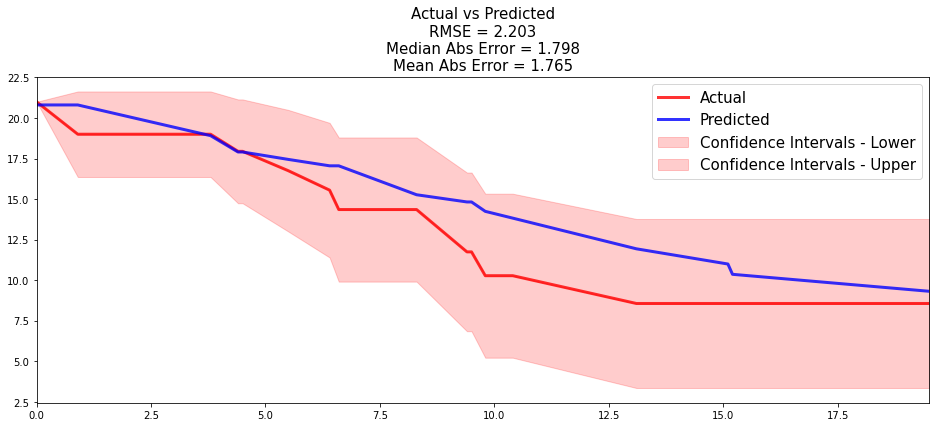

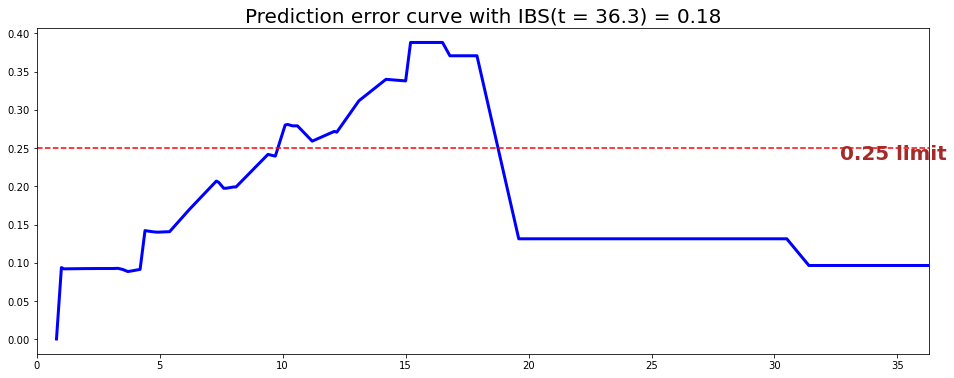

C-index: 0.52
IBS: 0.18
                                        Variable   Imp Avg   Imp Std  \
0                                     Dmax (cGy)  1.289773  0.273228   
1            original_shape_Maximum2DDiameterRow  0.387896  0.775791   
2    original_glrlm_LongRunHighGrayLevelEmphasis  0.359349  0.718698   
3           original_gldm_GrayLevelNonUniformity  1.337617  0.522981   
4          original_glszm_GrayLevelNonUniformity  0.263523  0.527046   
..                                           ...       ...       ...   
136                            D95 (dose in cGy)  0.164479  1.145116   
137                   original_shape_VoxelVolume  0.000000  0.860663   
138                    original_shape_Elongation -0.263523  0.527046   
139                        NumLiverLesionsAtRT.1  0.000000  0.860663   
140                     original_glcm_SumEntropy -0.263523  0.527046   

      Pct Avg   Pct Std  
0    0.097900  0.019014  
1    0.028008  0.056017  
2    0.025947  0.051894  
3    0.

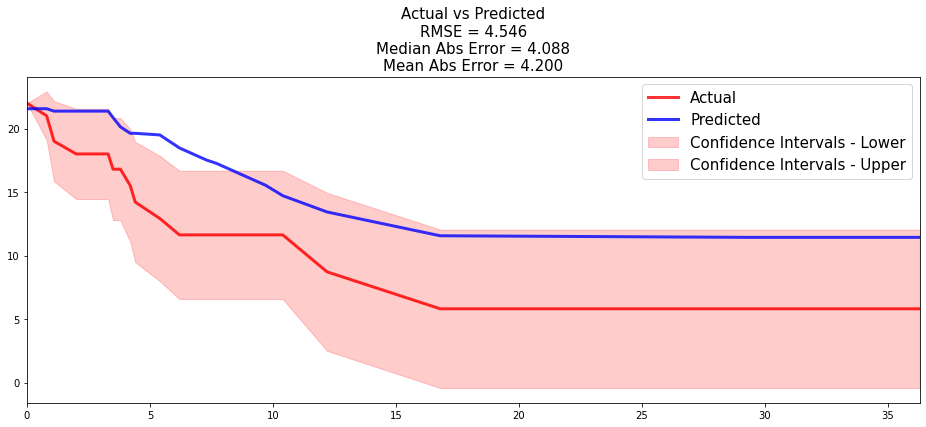

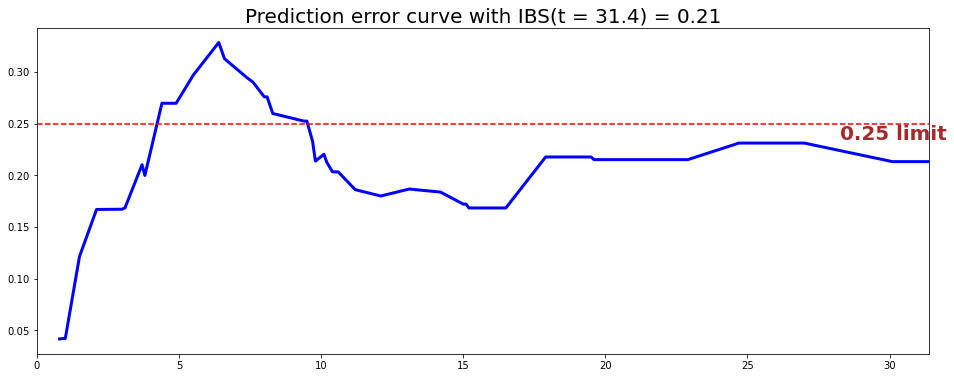

C-index: 0.69
IBS: 0.21


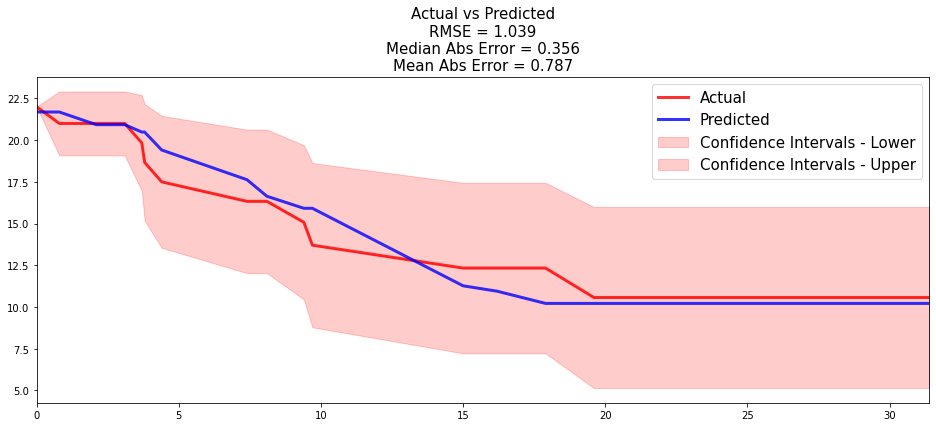

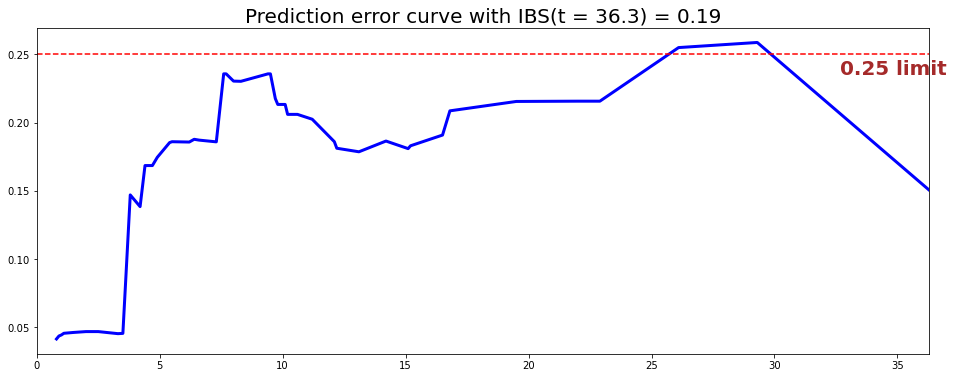

C-index: 0.75
IBS: 0.19


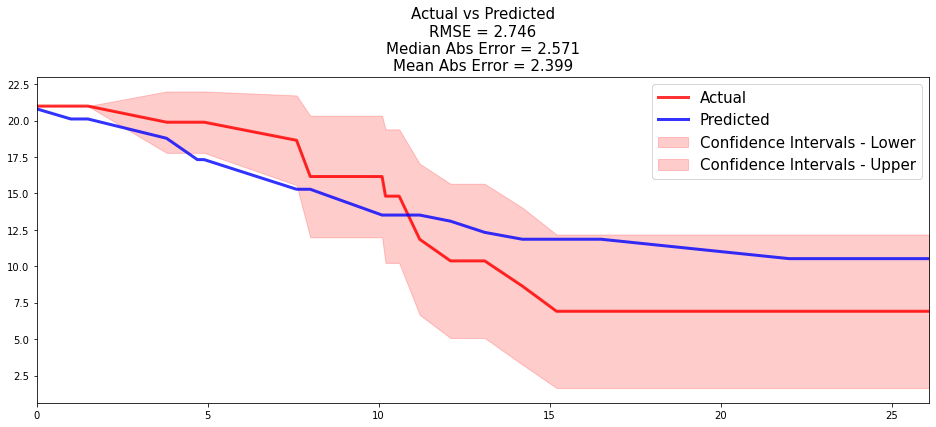

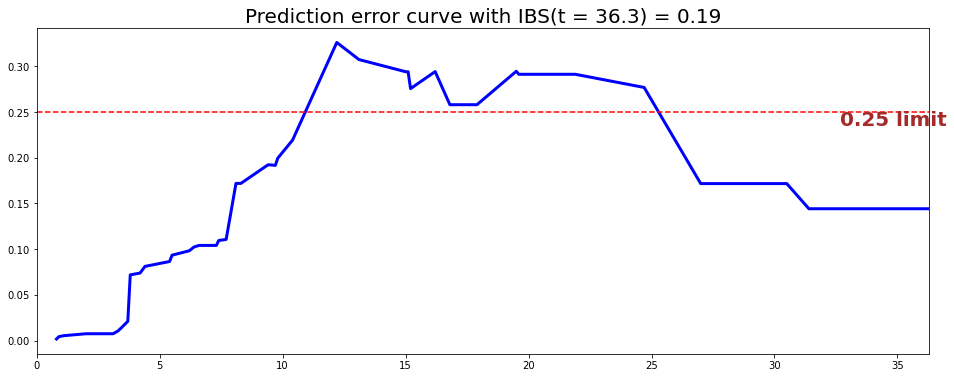

C-index: 0.58
IBS: 0.19


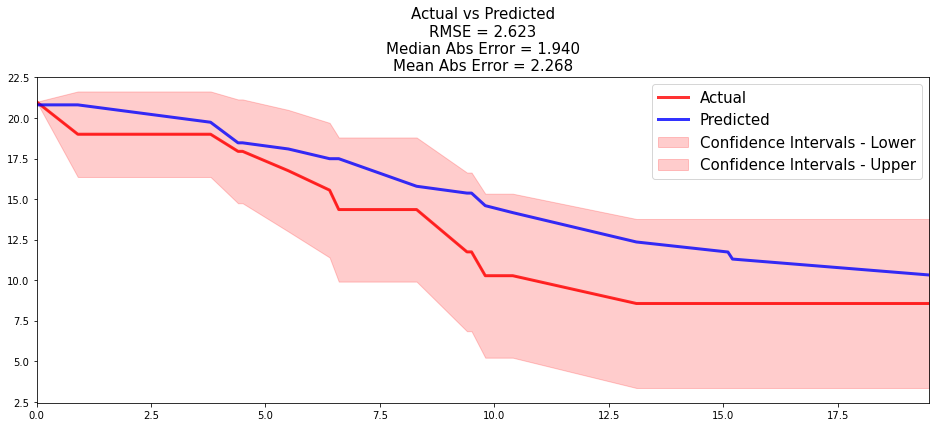

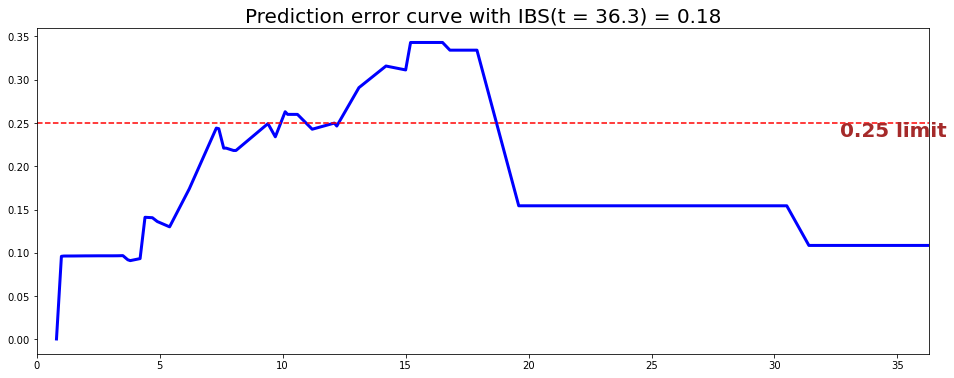

C-index: 0.63
IBS: 0.18
                                              Variable       Imp Avg  \
0                original_glrlm_RunLengthNonUniformity  8.592589e-01   
1                                     MinDosePTV (cGy)  6.738158e-01   
2                           original_glszm_ZoneEntropy  6.036003e-01   
3         original_glrlm_ShortRunHighGrayLevelEmphasis  7.650057e-02   
4      original_glszm_GrayLevelNonUniformityNormalized  2.616671e-02   
..                                                 ...           ...   
112  original_gldm_SmallDependenceHighGrayLevelEmph... -2.635231e-01   
113                         original_shape_SurfaceArea  2.635231e-01   
114                  original_shape_SurfaceVolumeRatio -1.710920e-01   
115             original_glrlm_LowGrayLevelRunEmphasis -7.905694e-01   
116     original_glszm_SizeZoneNonUniformityNormalized -5.551115e-17   

      Imp Std   Pct Avg   Pct Std  
0    1.130815  0.025630  0.033579  
1    0.814134  0.022696  0.026344  
2  

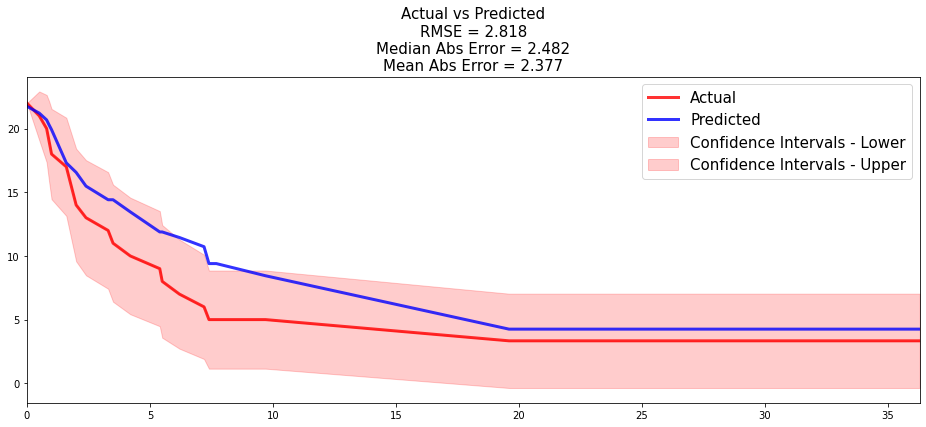

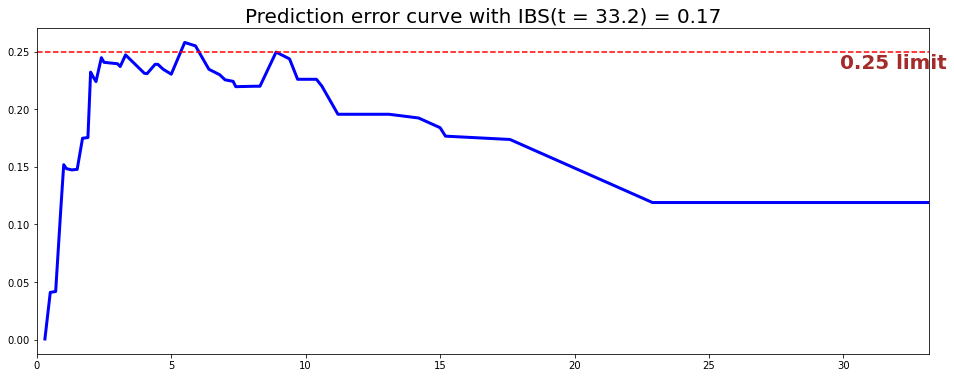

C-index: 0.57
IBS: 0.17


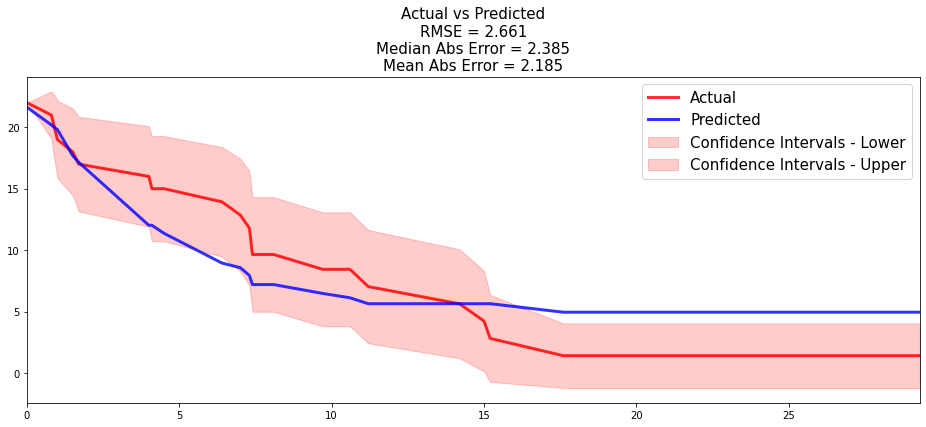

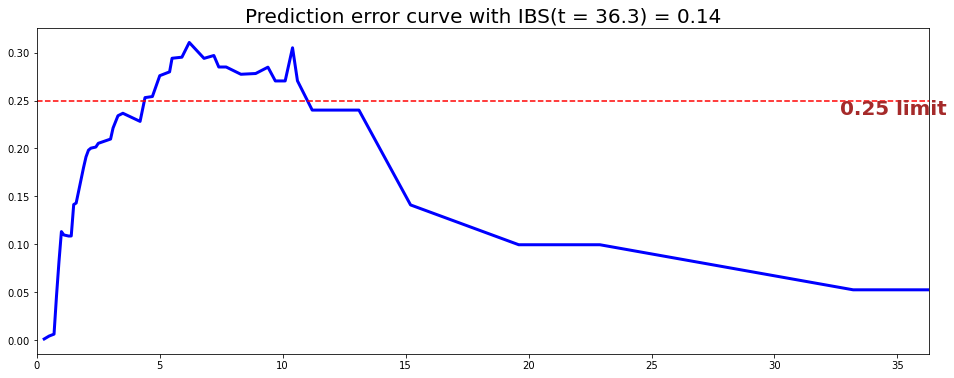

C-index: 0.52
IBS: 0.14


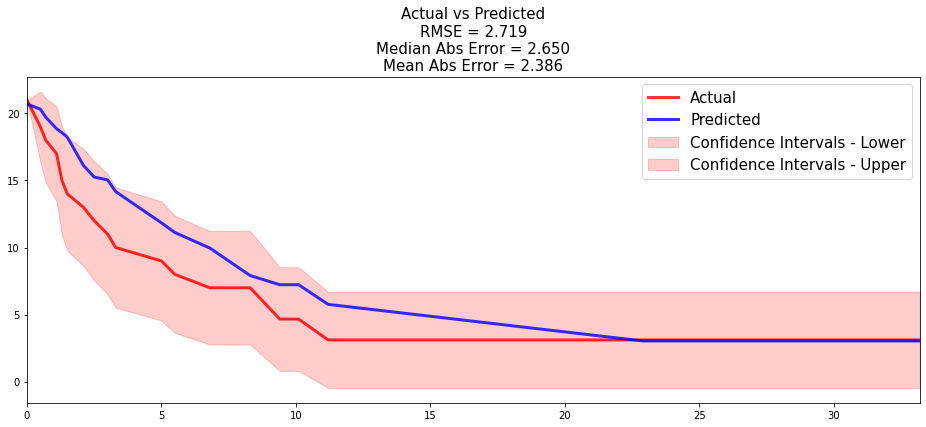

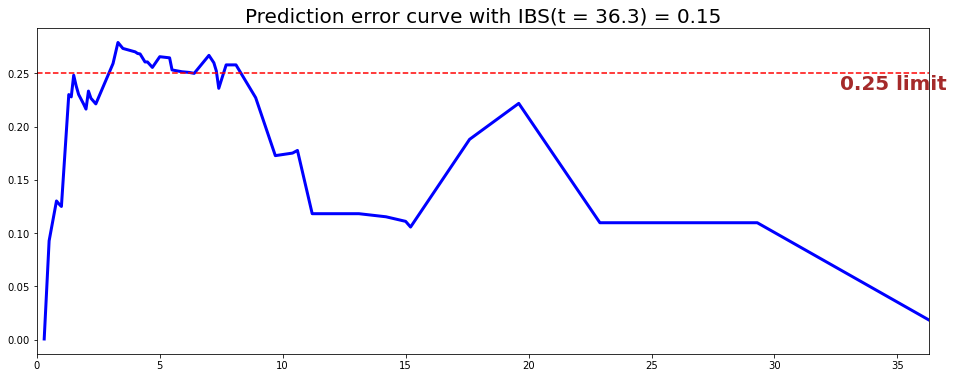

C-index: 0.58
IBS: 0.15


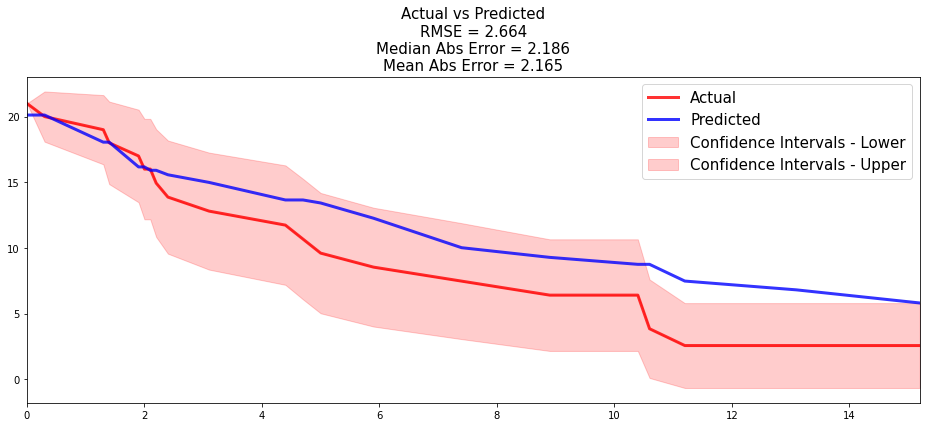

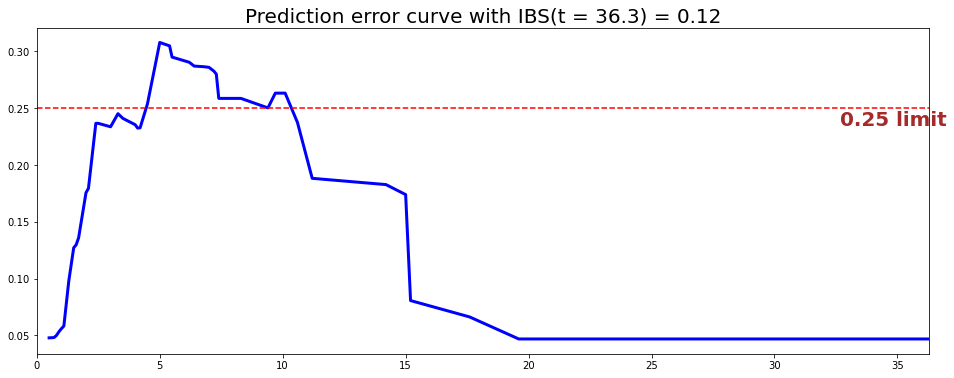

C-index: 0.51
IBS: 0.12
                                              Variable   Imp Avg   Imp Std  \
0                         original_firstorder_Skewness  0.453996  1.213709   
1                    original_shape_SurfaceVolumeRatio  0.263523  0.527046   
2    original_gldm_SmallDependenceHighGrayLevelEmph...  0.263523  0.527046   
3                         original_firstorder_Kurtosis  0.411876  0.910784   
4                           original_glcm_ClusterShade -0.105029  1.349383   
..                                                 ...       ...       ...   
108                   original_glszm_GrayLevelVariance -0.527046  0.608581   
109         original_glrlm_LongRunLowGrayLevelEmphasis -0.099986  0.706879   
110                                     OtherSitesAtRT -0.073207  1.138921   
111                   original_glrlm_GrayLevelVariance -0.263523  0.527046   
112                         original_shape_VoxelVolume -0.527046  0.608581   

      Pct Avg   Pct Std  
0    0.106742

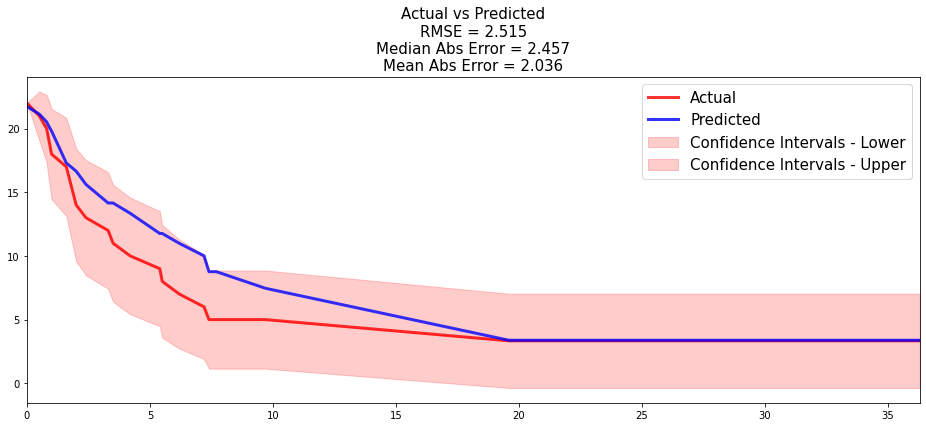

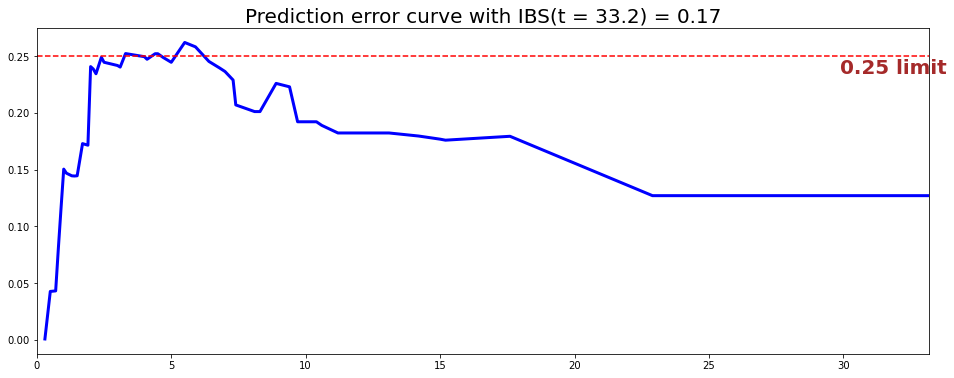

C-index: 0.57
IBS: 0.17


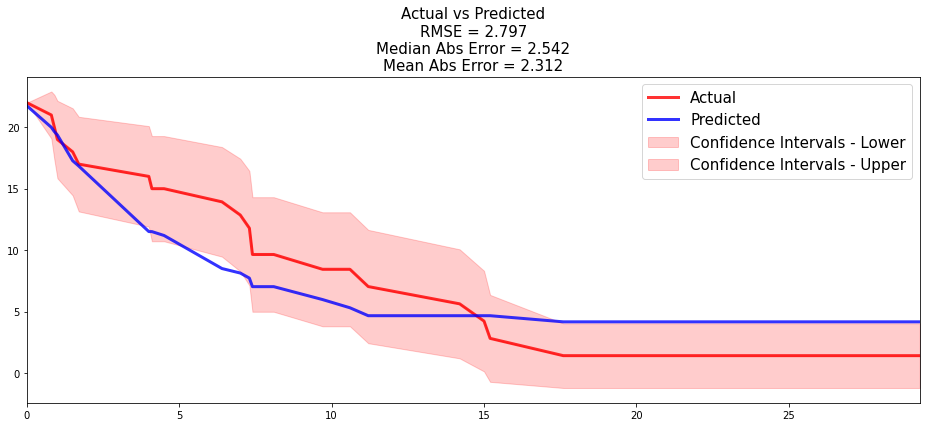

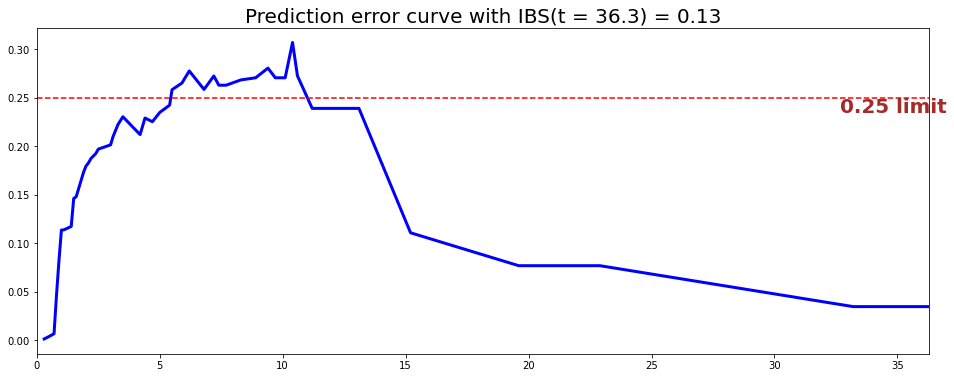

C-index: 0.55
IBS: 0.13


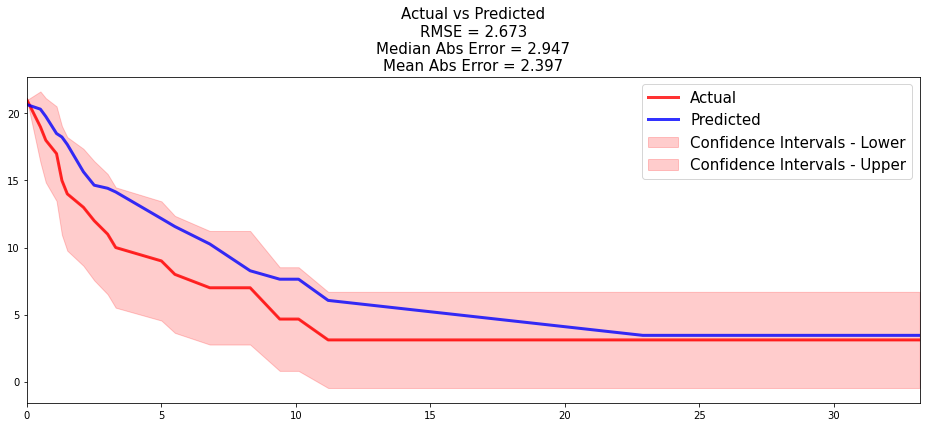

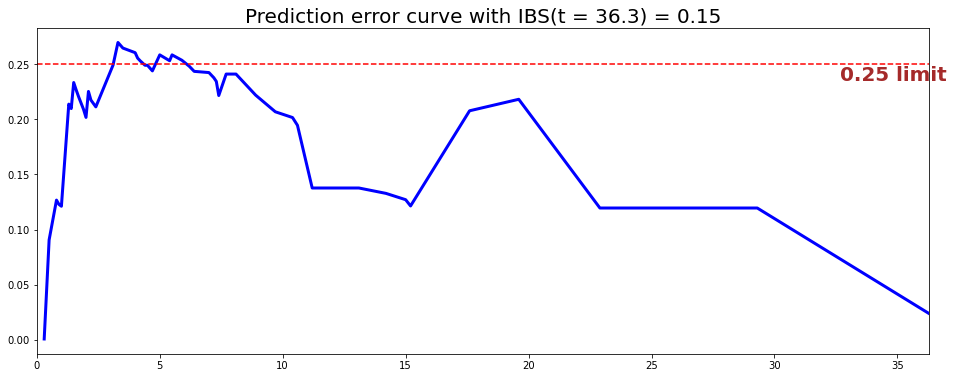

C-index: 0.63
IBS: 0.15


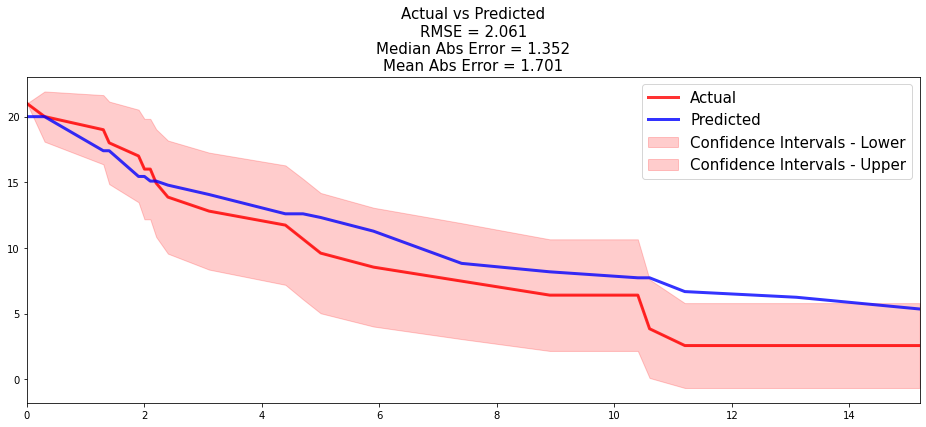

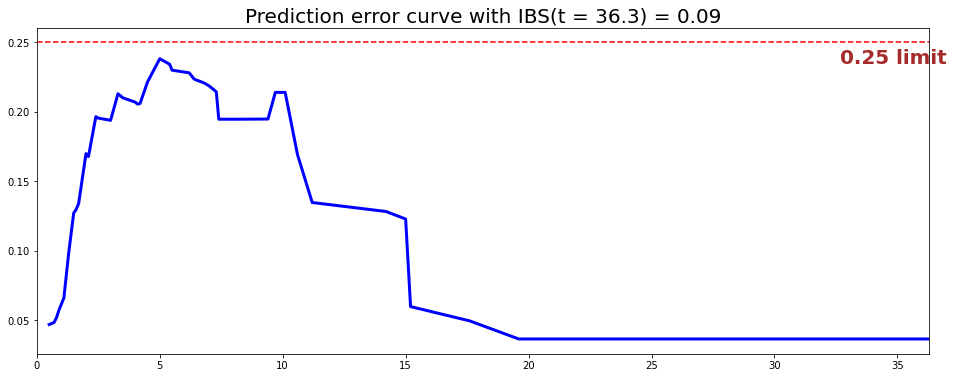

C-index: 0.67
IBS: 0.09
                                  Variable   Imp Avg   Imp Std   Pct Avg  \
0             original_firstorder_Kurtosis  2.522322  0.146757  0.064540   
1                                  CEAatRT  1.494734  1.121514  0.041147   
2             original_firstorder_Skewness  2.208766  0.639926  0.057069   
3               original_glcm_ClusterShade  0.145364  1.197278  0.013341   
4                              BED (in Gy)  0.859060  0.606138  0.023239   
..                                     ...       ...       ...       ...   
136                             Dmax (cGy) -0.889324  0.611344  0.000000   
137  original_glszm_GrayLevelNonUniformity -0.357030  0.714060  0.000000   
138             original_shape_VoxelVolume -0.955086  0.665309  0.000000   
139            D95 (% of intended Rx dose) -0.276716  1.152433  0.008117   
140              original_shape_Sphericity -1.362967  0.471626  0.000000   

      Pct Std  
0    0.010239  
1    0.030691  
2    0.020465  

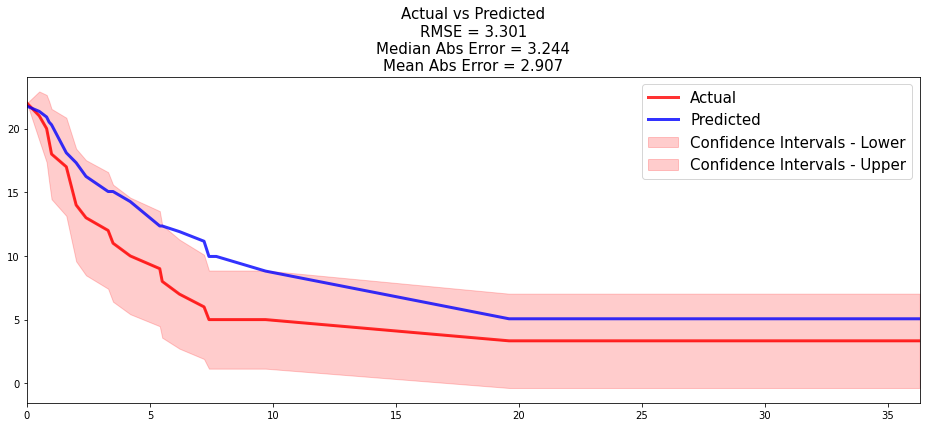

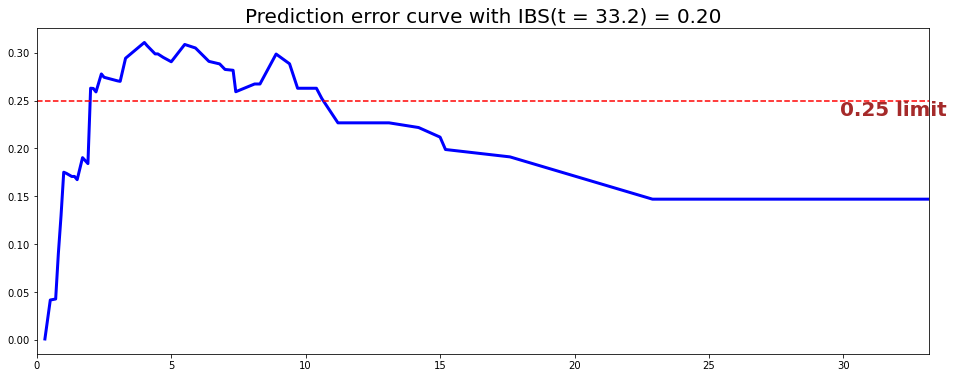

C-index: 0.50
IBS: 0.20


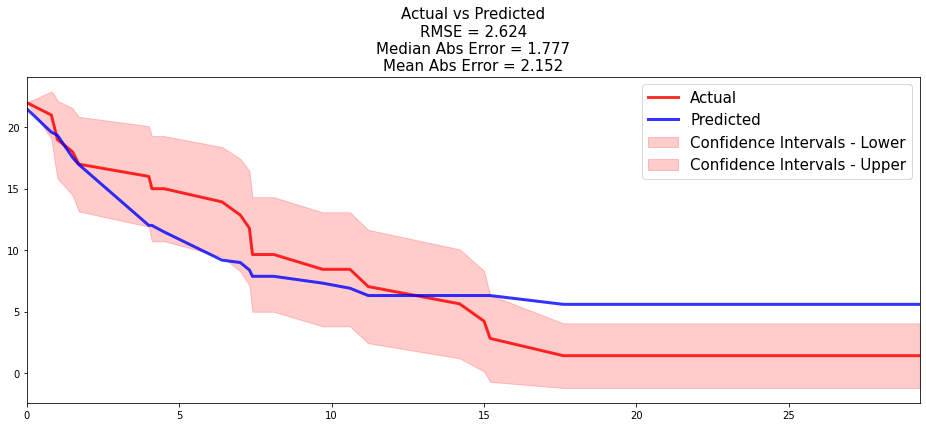

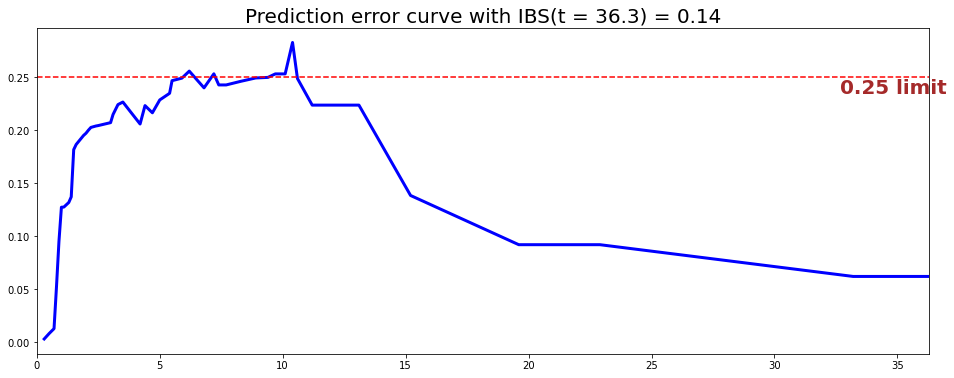

C-index: 0.60
IBS: 0.14


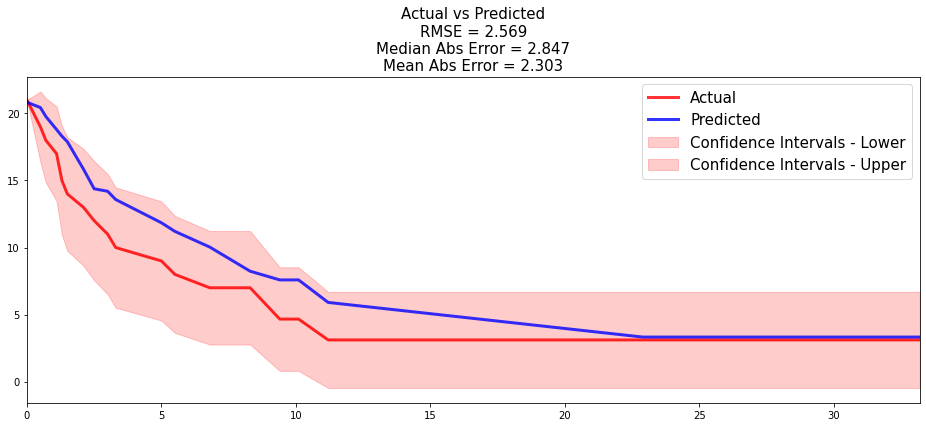

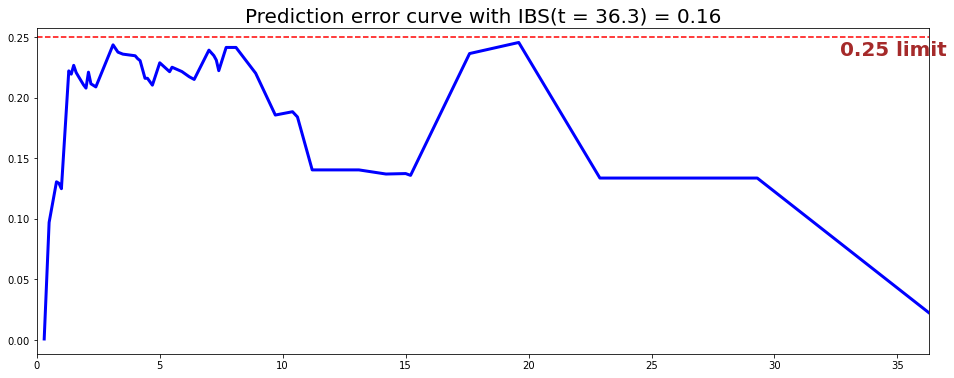

C-index: 0.68
IBS: 0.16


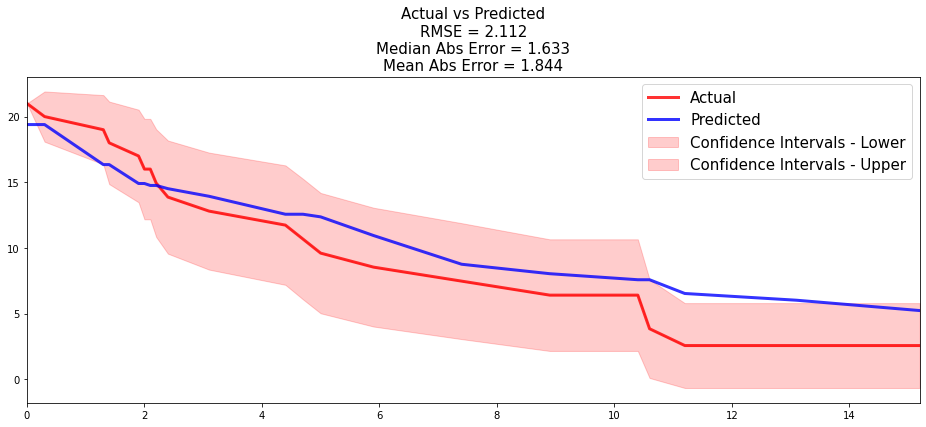

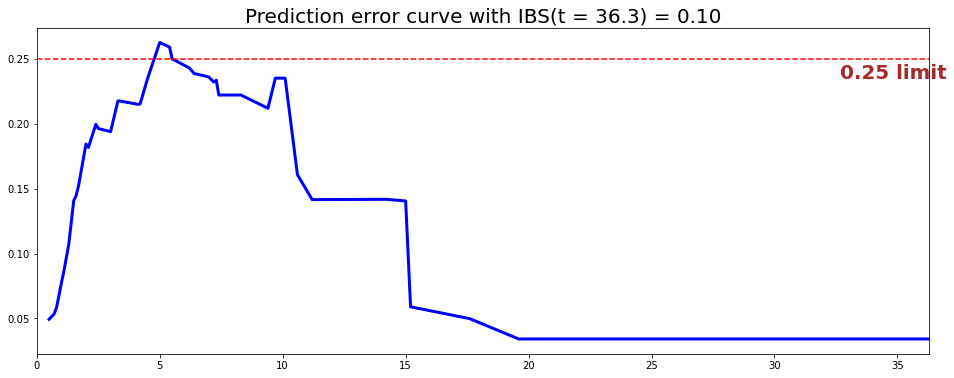

C-index: 0.59
IBS: 0.10
                                         Variable   Imp Avg   Imp Std  \
0                     D95 (% of intended Rx dose)  0.138468  1.293130   
1                  original_shape_LeastAxisLength  0.620978  0.733267   
2                              original_glcm_Idmn  0.333713  0.667426   
3                    original_firstorder_Skewness  0.269899  0.998138   
4        original_glszm_HighGrayLevelZoneEmphasis -0.263523  1.009217   
..                                            ...       ...       ...   
112  original_glszm_LargeAreaLowGrayLevelEmphasis -0.263523  0.527046   
113                    original_glcm_ClusterShade -0.985161  0.691128   
114           original_gldm_HighGrayLevelEmphasis  0.000000  0.860663   
115         original_glrlm_GrayLevelNonUniformity -0.543012  0.627558   
116               diagnostics_Image-original_Mean -0.425594  1.197883   

      Pct Avg   Pct Std  
0    0.045436  0.054334  
1    0.043600  0.052931  
2    0.025023  0.0500

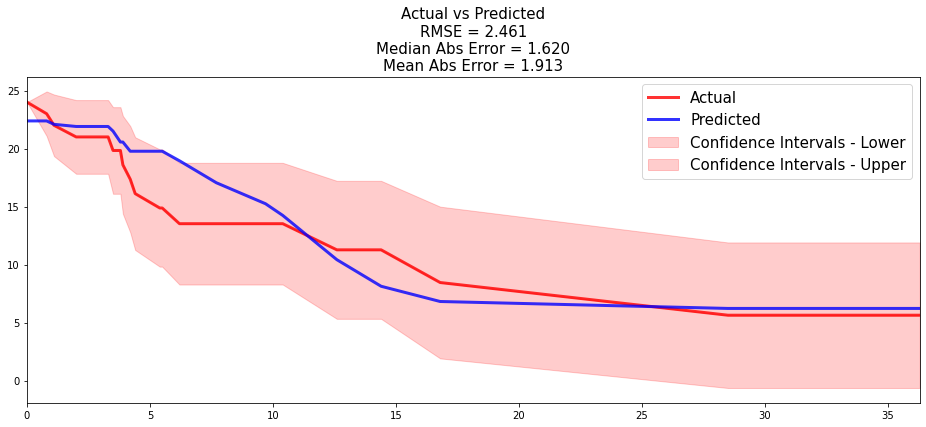

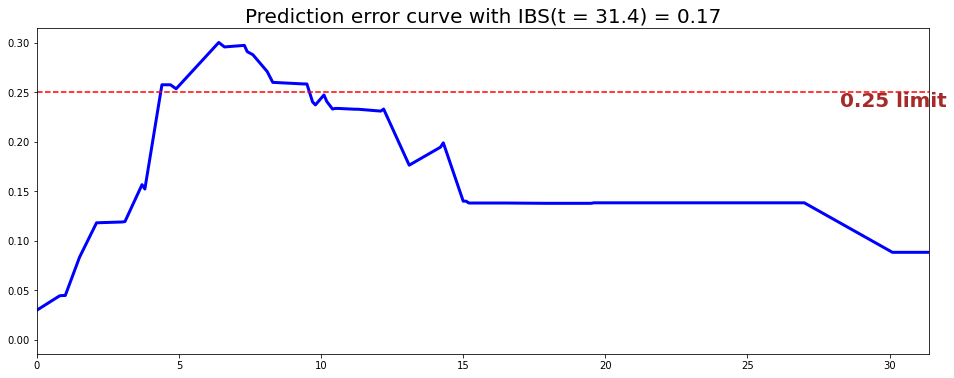

C-index: 0.58
IBS: 0.17


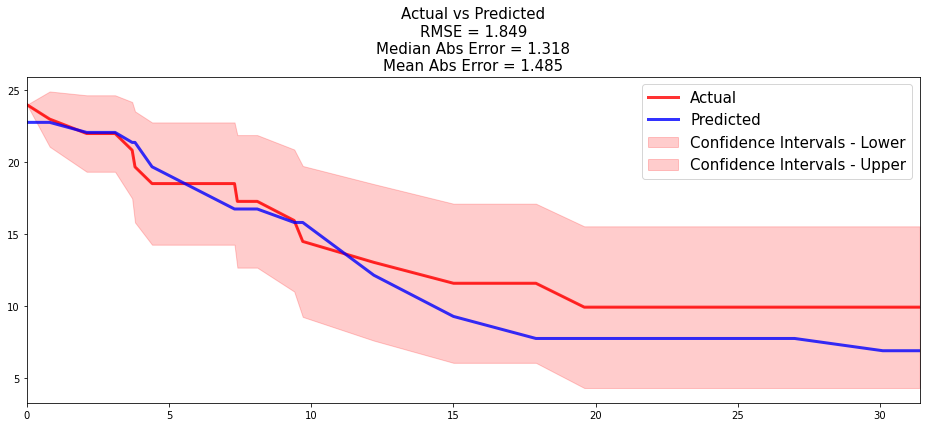

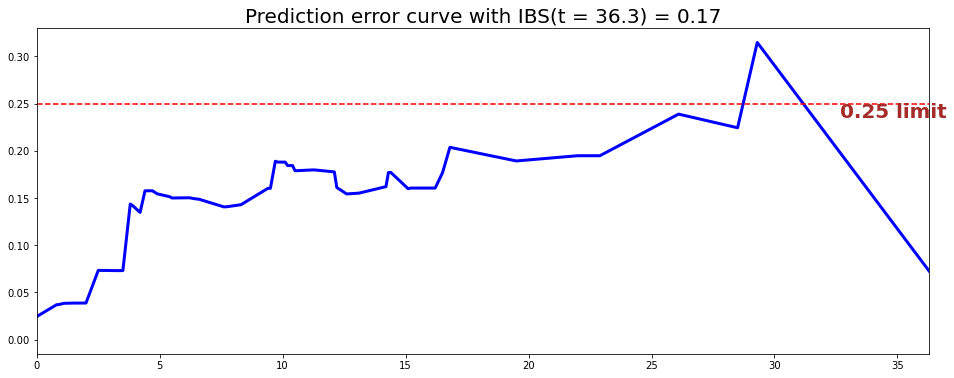

C-index: 0.77
IBS: 0.17


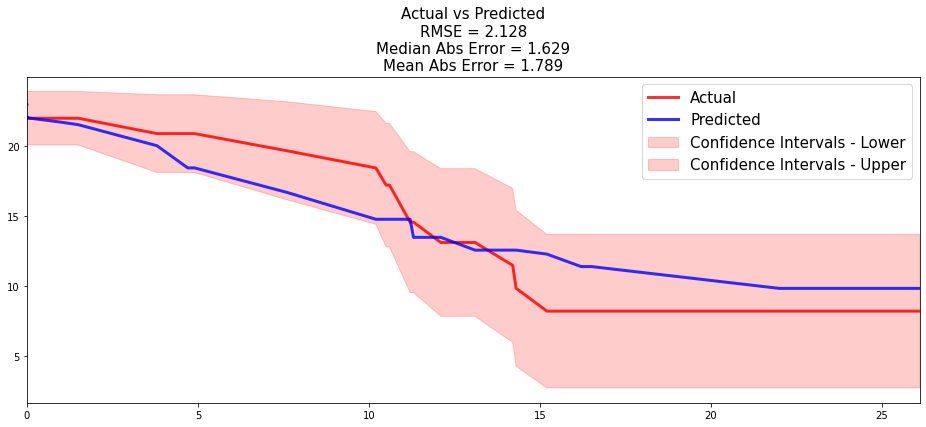

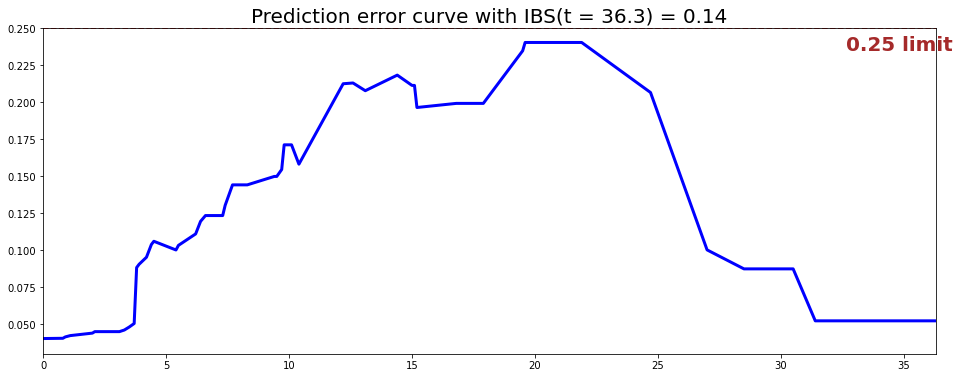

C-index: 0.68
IBS: 0.14


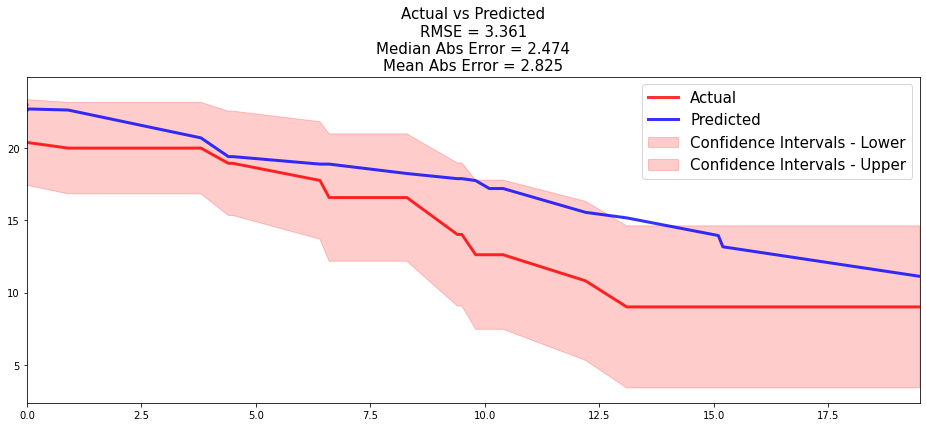

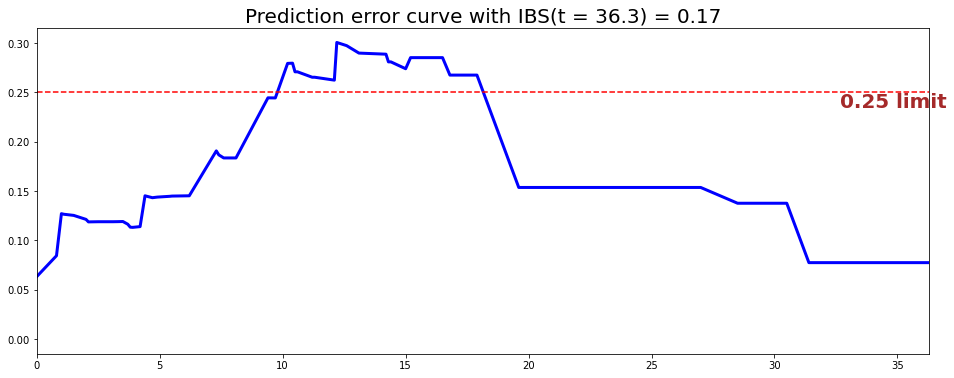

C-index: 0.63
IBS: 0.17
                       Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0             D95 (dose in cGy)  1.571545  0.142315  0.116704  0.024899
1                    Dmax (cGy)  0.700832  0.818255  0.046552  0.057043
2              PTVvolume (cm^3)  2.012615  0.548649  0.148808  0.047167
3              MinDosePTV (cGy)  2.149093  1.147941  0.156588  0.075633
4                   Lesion1Dim1  0.408997  0.840163  0.036529  0.044153
5                    RTPlanDose  0.256495  0.982299  0.036187  0.041964
6                RTtoOtherSites -0.319335  1.091315  0.020824  0.037636
7                   RTDoseDeliv  0.919710  0.570916  0.069706  0.044552
8   D95 (% of intended Rx dose)  0.355700  0.953178  0.041288  0.037052
9                   RFAbeforeRT  0.256495  0.512989  0.019277  0.038554
10                  Lesion1Dim2  1.105304  0.810853  0.076850  0.049274
11          NumLiverLesionsAtDx -0.243802  0.849437  0.009281  0.018561
12                    RTFxDeliv  0.00000

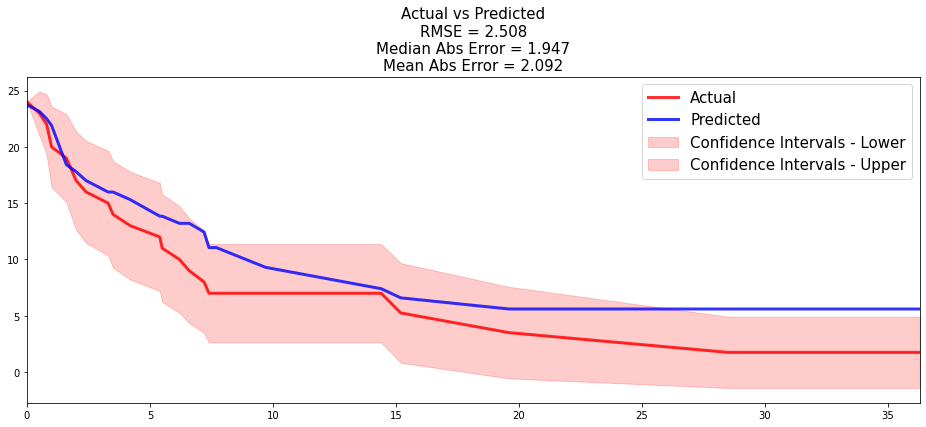

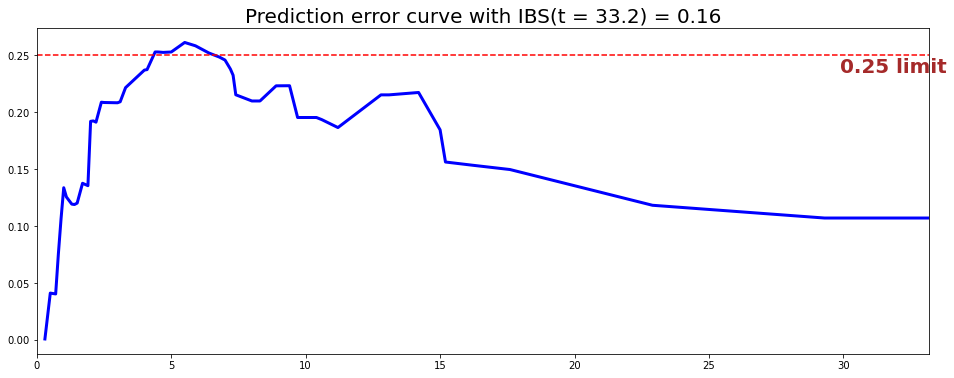

C-index: 0.65
IBS: 0.16


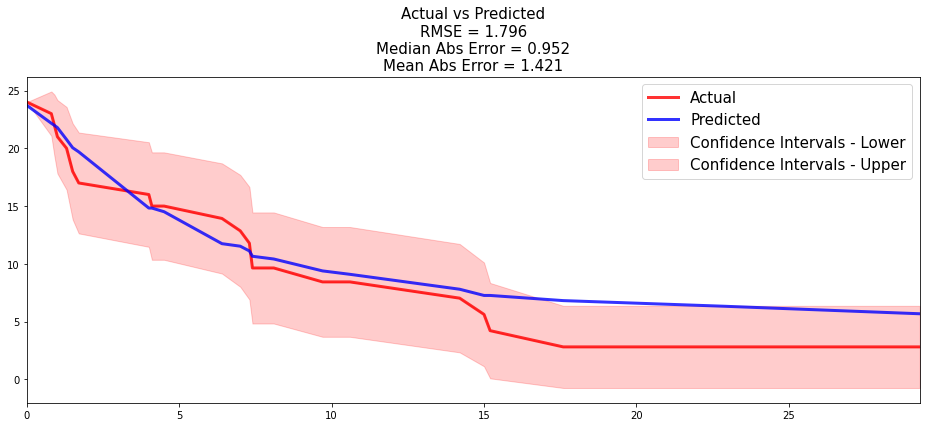

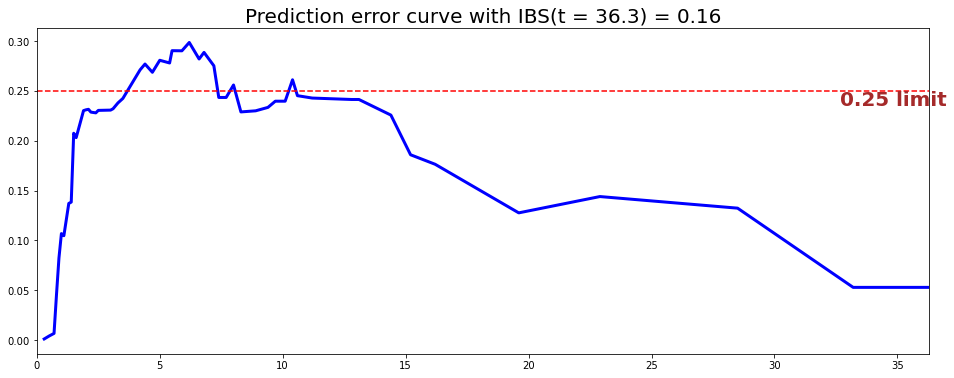

C-index: 0.51
IBS: 0.16


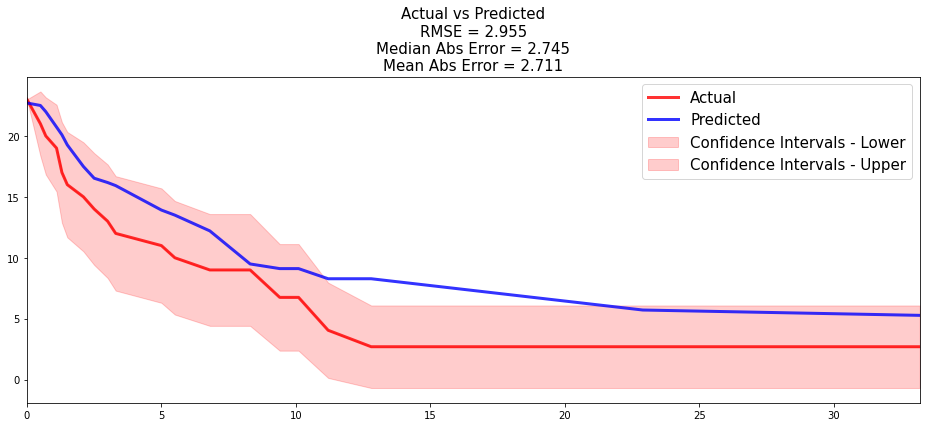

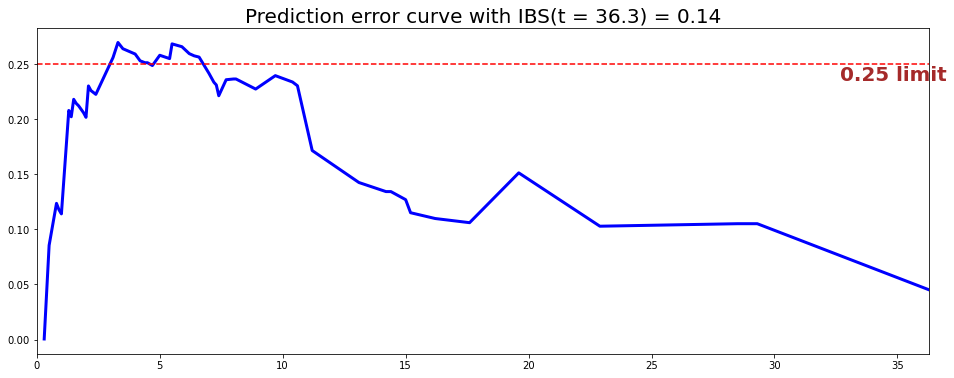

C-index: 0.59
IBS: 0.14


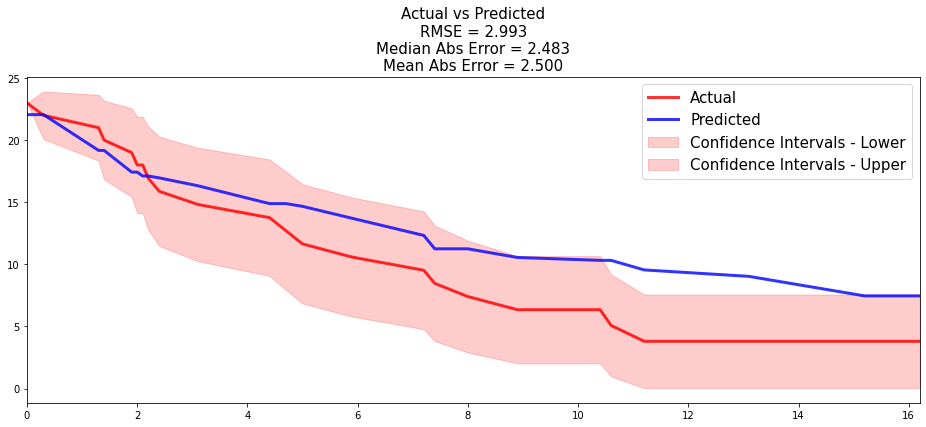

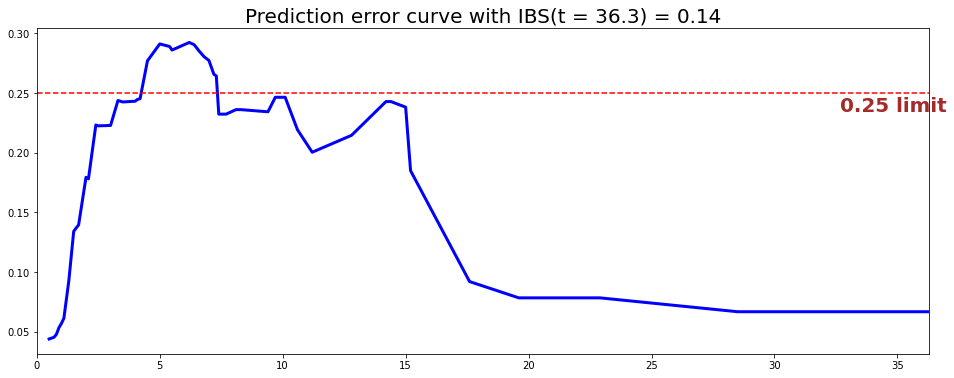

C-index: 0.55
IBS: 0.14
                       Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0                       CEAatRT  4.418942  1.633135  0.198868  0.127436
1                OtherSitesAtRT  4.877615  5.337681  0.163138  0.131921
2              LiverLocation2Tx  0.984963  1.671204  0.041576  0.062205
3                Lines of chemo  1.994638  1.261432  0.075402  0.038845
4                       CEAatDx  1.295746  3.181586  0.099630  0.129749
5                OtherSitesAtDx  0.763635  2.550581  0.046592  0.053975
6                  DosePainting  0.522550  1.279163  0.026987  0.026464
7                RFAtoRTlesions  0.499093  0.925686  0.034117  0.024535
8         NumLiverLesionsAtRT.1 -0.754028  0.992463  0.006537  0.013073
9   D95 (% of intended Rx dose) -0.740848  0.923470  0.005635  0.011270
10                         ReTx  0.875192  0.756476  0.030949  0.024713
11                  Lesion1Dim2  1.757218  2.256551  0.073838  0.087454
12              cM at diagnosis -0.33248

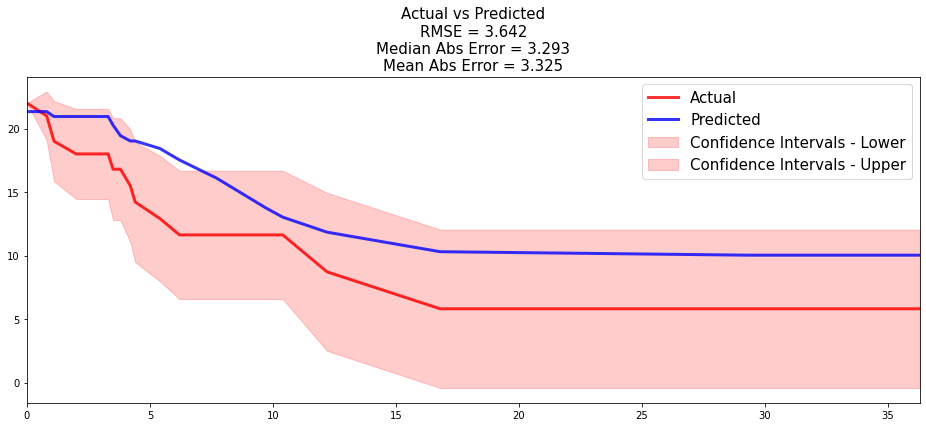

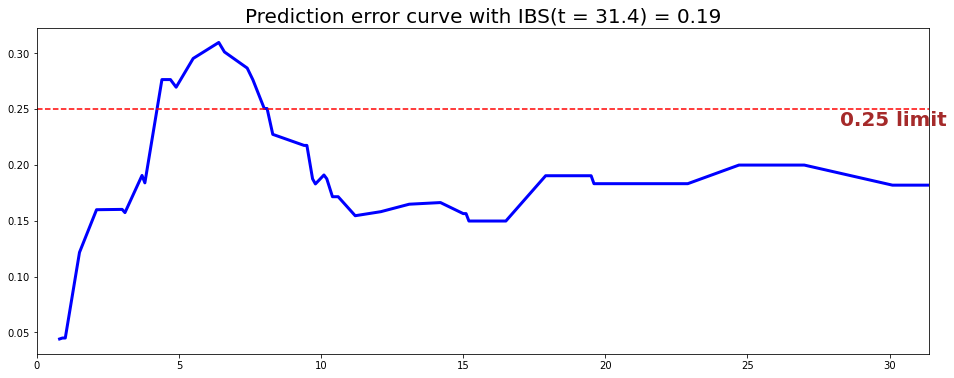

C-index: 0.66
IBS: 0.19


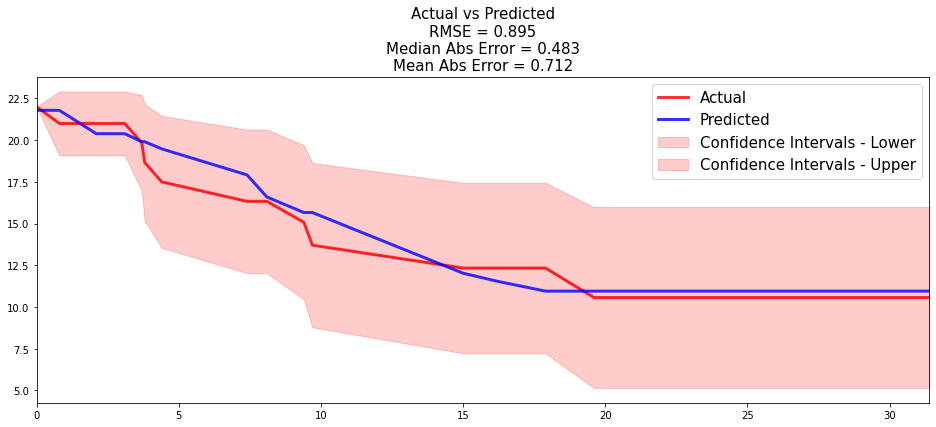

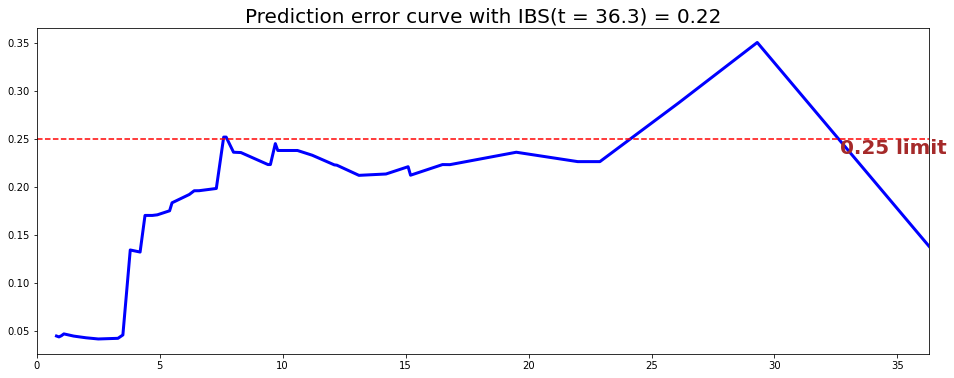

C-index: 0.68
IBS: 0.22


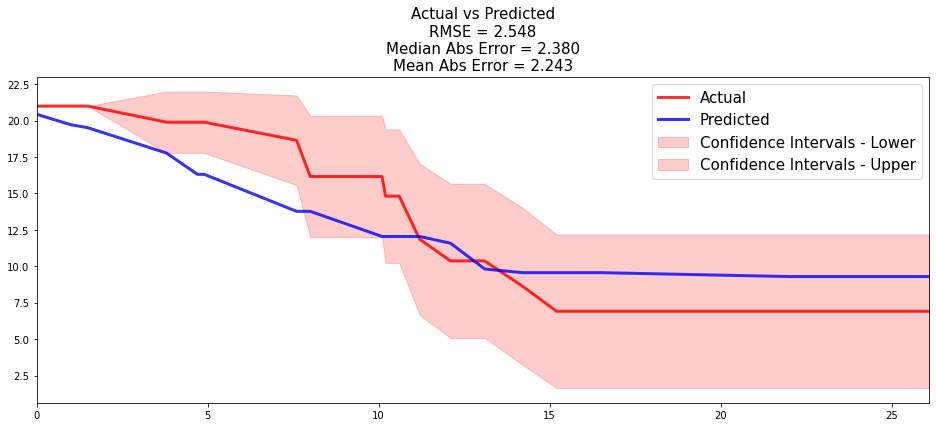

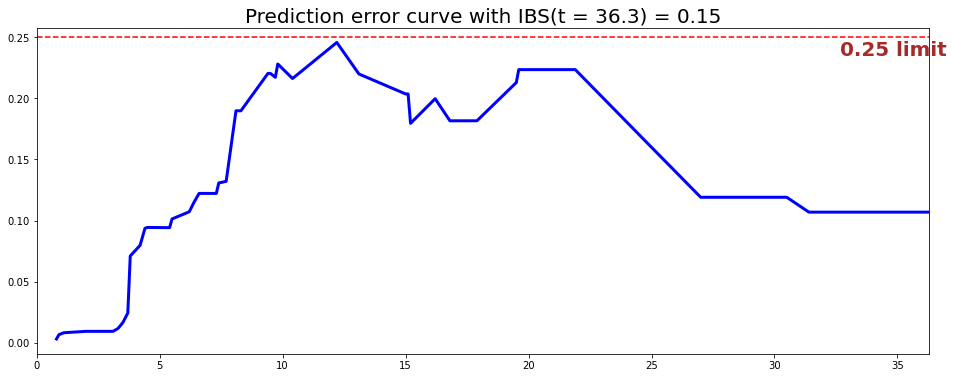

C-index: 0.64
IBS: 0.15


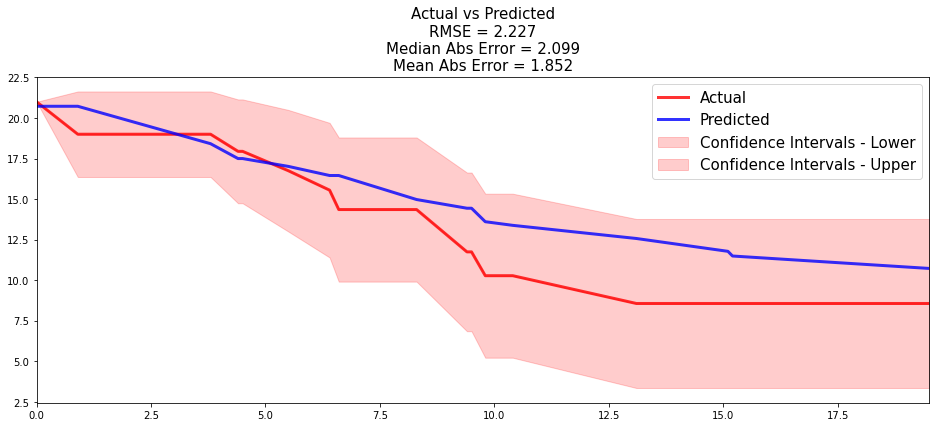

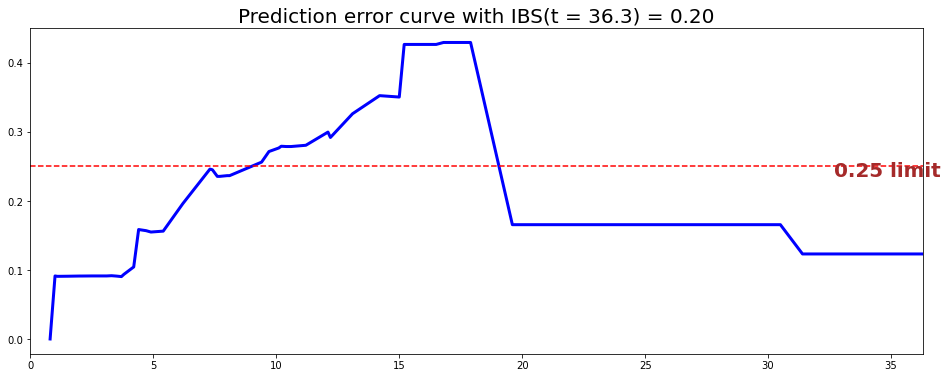

C-index: 0.59
IBS: 0.20
                                  Variable   Imp Avg   Imp Std   Pct Avg  \
0                               Dmax (cGy)  0.662521  1.165469  0.031384   
1                original_glcm_Correlation  0.725708  0.841275  0.023851   
2          original_gldm_DependenceEntropy  0.627944  0.743572  0.022448   
3                         MinDosePTV (cGy)  1.152403  0.196621  0.040876   
4                         original_glcm_Id  0.324834  0.649669  0.010466   
..                                     ...       ...       ...       ...   
141                            Lesion1Dim1 -0.263523  1.009217  0.010707   
142  original_gldm_LargeDependenceEmphasis  0.000000  0.860663  0.010707   
143  original_glszm_GrayLevelNonUniformity  0.263523  1.009217  0.018512   
144    original_shape_Maximum2DDiameterRow -0.114484  1.055923  0.009658   
145                                CEAatRT -0.033211  1.492441  0.023340   

      Pct Std  
0    0.021672  
1    0.027589  
2    0.025976  

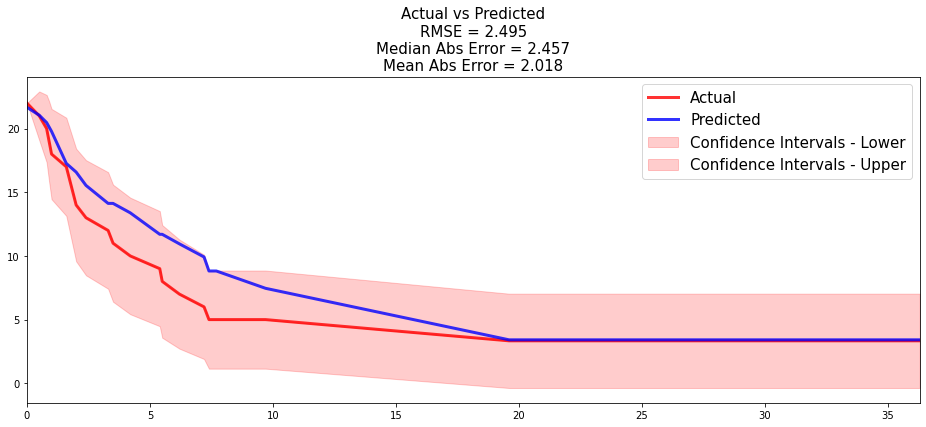

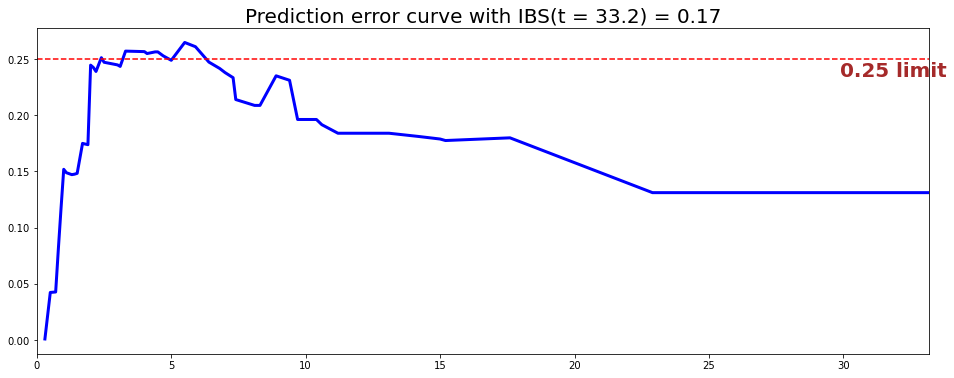

C-index: 0.50
IBS: 0.17


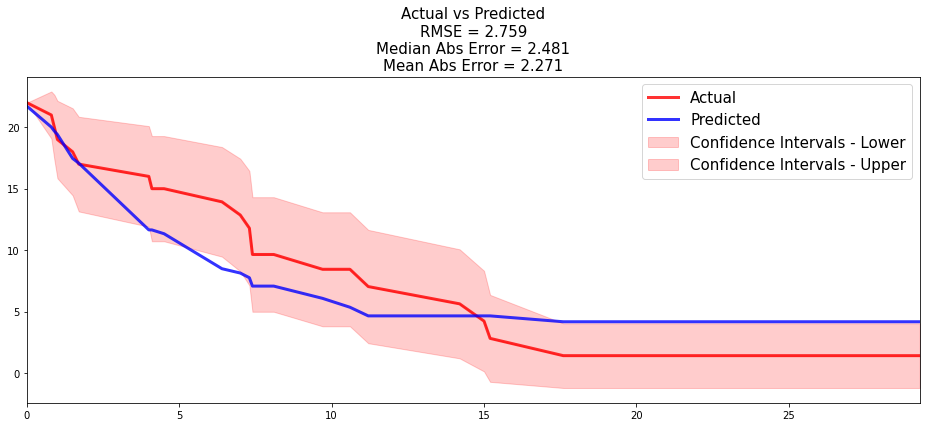

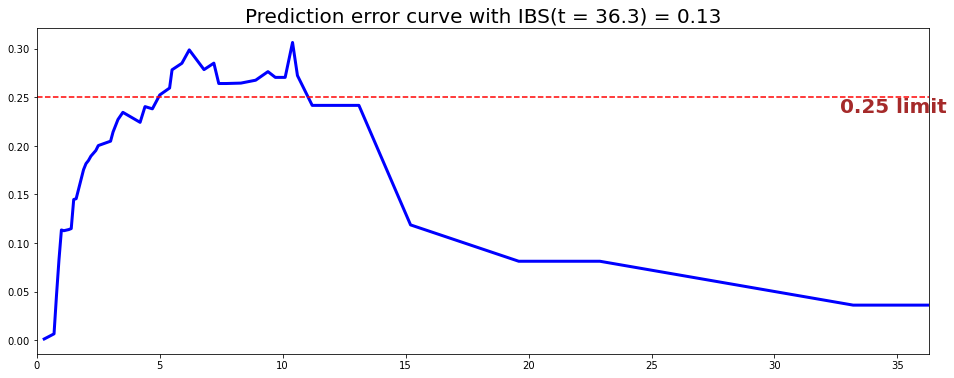

C-index: 0.54
IBS: 0.13


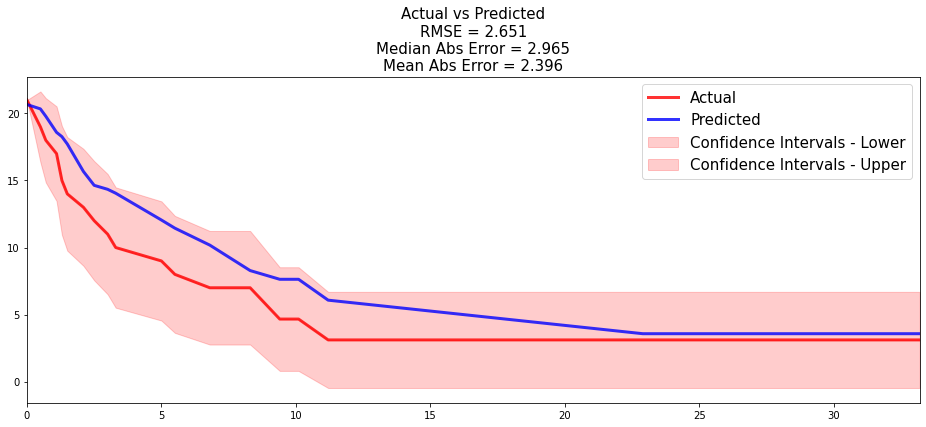

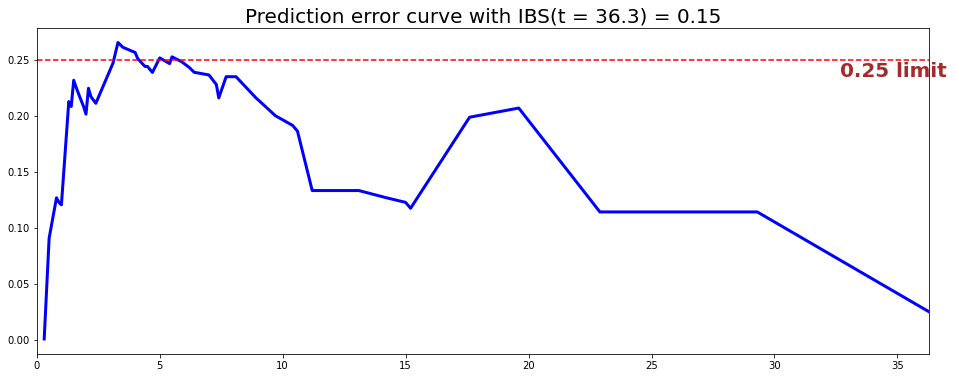

C-index: 0.63
IBS: 0.15


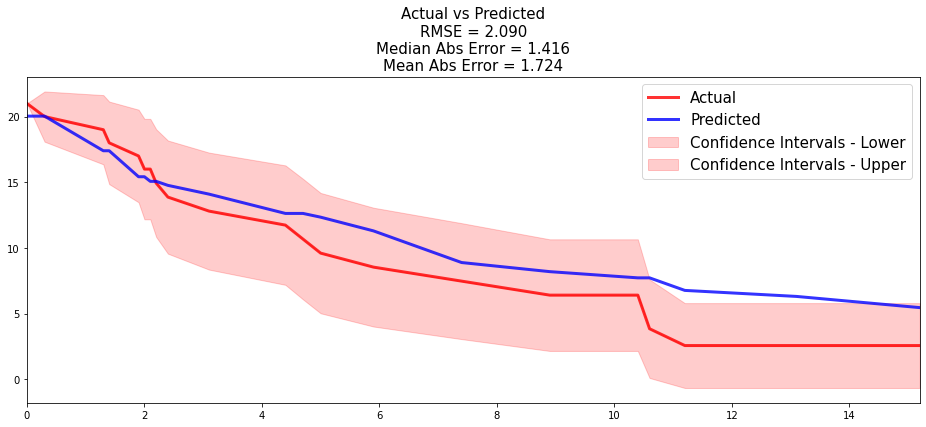

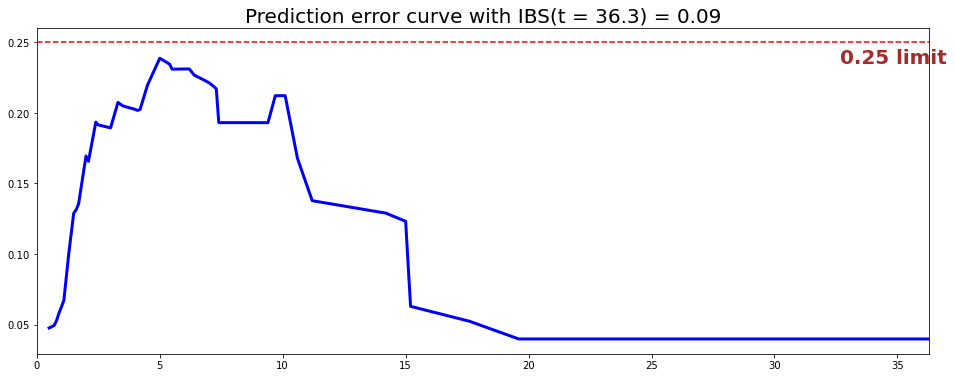

C-index: 0.69
IBS: 0.09
                                              Variable   Imp Avg   Imp Std  \
0                         original_firstorder_Kurtosis  2.849653  1.151077   
1                                              CEAatRT  1.410902  1.238250   
2                           original_glcm_ClusterShade  0.901888  0.896063   
3                                       Lines of chemo  0.125345  1.057965   
4                         original_firstorder_Skewness  2.245479  0.552247   
..                                                 ...       ...       ...   
141                   original_glszm_GrayLevelVariance -1.092968  0.509351   
142            original_glszm_LowGrayLevelZoneEmphasis -1.343727  0.248626   
143         original_glrlm_LongRunLowGrayLevelEmphasis -1.552337  0.391621   
144              original_shape_Maximum2DDiameterSlice -1.134483  0.606048   
145  original_gldm_LargeDependenceLowGrayLevelEmphasis -0.785105  0.845566   

      Pct Avg   Pct Std  
0    0.071024

In [26]:
#without feature selection

# iterating thought each dataset
# all results will be stored in a dataframe with columns "CI, CI STD, IBS, IBS"

results = []
    
for data_name in data_list:

    # Running feature selection on the data
    
    print('Processing: ' + data_name + '\n')
    processed_file_name = 'filtered_' + data_name 
    
    filtered_data = feature_select(data_name, 0)

    print('\n \n')

    # running gridsearch
    
    print('Running gridsearch on: ' + data_name + '\n')
    gridsearch_file_name = 'gridsearch_' + data_name 
    
    if(not(os.path.exists(gridsearch_file_name))):
        print('Computing gridsearch...\n')
        (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
        print((c_index_best, num_tree_best,max_depth_best, min_node_best))
    else:
        gridsearch_df = pd.read_csv(gridsearch_file_name)
        
        c_index_best = gridsearch_df['Values'][0]
        num_tree_best = gridsearch_df['Values'][1]
        max_depth_best = gridsearch_df['Values'][2]
        min_node_best = gridsearch_df['Values'][3]
        
        #print(c_index_best)
        print('Loading existing gridsearch hyperparameters...\n')
        
    # generating model form best gridsearch combination

    print('Evaluating K-folds with best hyperparameter combination...\n')
    (CIAvg, CIStd, IBSAvg, IBSStd, var_imps_list, predictions) = generate_survival_model(filtered_data, num_tree_best, max_depth_best, 
                                                                                        min_node_best,display=1 , s = 10)
    
    
    
    results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd])
    print('\n \n')

results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD'])

print(results_DF)

In [27]:
results_DF.to_csv('results_noFS.csv', index=False, header=False)
results_DF

Data  Best Gridsearch CI    CI Avg  \
0                               gtv.csv            0.675486  0.639708   
1                     liver_sub_gtv.csv            0.660133  0.609746   
2                    liver_plus_gtv.csv            0.675743  0.662248   
3                            gtv_hp.csv            0.614537  0.584840   
4                  liver_sub_gtv_hp.csv            0.586293  0.560278   
5                 liver_plus_gtv_hp.csv            0.597319  0.584341   
6       clin_variables_imaging_fflp.csv            0.667342  0.660035   
7   clin_variables_non_imaging_fflp.csv            0.662902  0.642186   
8    clin_variables_dosimetric_fflp.csv            0.717649  0.692763   
9         clin_variables_imaging_hp.csv            0.608929  0.585546   
10    clin_variables_non_imaging_hp.csv            0.603460  0.569247   
11     clin_variables_dosimetric_hp.csv            0.629773  0.555731   
12           rads_plus_imaging_fflp.csv            0.611448  0.610812   
13       rads_plus_non_imaging_fflp.csv            0.605703  0.650620   
14        rads_plus_dosimetric_fflp.csv            0.731730  0.661405   
15             rads_plus_imaging_hp.csv            0.620482  0.545493   
16         rads_plus_non_imaging_hp.csv            0.624740  0.605823   
17          rads_plus_dosimetric_hp.csv            0.652237  0.591565   
18          clin_variables_all_fflp.csv            0.624283  0.665786   
19            clin_variables_all_hp.csv            0.594437  0.574950   
20                         all_fflp.csv            0.594987  0.642113   
21                           all_hp.csv            0.587364  0.589942   

      CI STD   IBS Avg   IBS STD  
0   0.122164  0.179326  0.005559  
1   0.082343  0.208597  0.023169  
2   0.078095  0.195338  0.027300  
3   0.067334  0.167763  0.028812  
4   0.051805  0.143274  0.034707  
5   0.056882  0.156748  0.033634  
6   0.046956  0.169990  0.030427  
7   0.104155  0.181914  0.033543  
8   0.074244  0.173533  0.029470  
9   0.032782  0.172482  0.020646  
10  0.040398  0.158220  0.003493  
11  0.055910  0.139962  0.019965  
12  0.038173  0.192943  0.048648  
13  0.103912  0.180743  0.034772  
14  0.072970  0.193473  0.011923  
15  0.038838  0.144593  0.019859  
16  0.054408  0.135401  0.033110  
17  0.070745  0.147869  0.042379  
18  0.083415  0.163126  0.015160  
19  0.061870  0.151132  0.012726  
20  0.041495  0.188298  0.030213  
21  0.081762  0.136528  0.032400

In [11]:
#making figures
# iterating thought each dataset
# all results will be stored in a dataframe with columns "CI, CI STD, IBS, IBS"

results = []
  
data_list = list()
data_list.extend((liver_plus_gtv_fflp, clin_variables_all_fflp, clin_variables_imaging_fflp , clin_variables_non_imaging_fflp, 
                clin_variables_dosimetric_fflp, rads_plus_dosimetric_fflp, all_fflp))
for data_name in data_list:

    # Running feature selection on the data
    
    print('Processing: ' + data_name + '\n')
    processed_file_name = 'filtered_' + data_name 
    
    print('Feature Selecting... \n')
    if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
    else:
        filtered_data = pd.read_csv(processed_file_name)
        print('Loading existing selected features...\n')
    print('\n \n')

    # running gridsearch
    
    print('Running gridsearch on: ' + data_name + '\n')
    gridsearch_file_name = 'gridsearch_' + data_name 
    
    if(not(os.path.exists(gridsearch_file_name))):
        print('Computing gridsearch...\n')
        (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
        print((c_index_best, num_tree_best,max_depth_best, min_node_best))
    else:
        gridsearch_df = pd.read_csv(gridsearch_file_name)
        
        c_index_best = gridsearch_df['Values'][0]
        num_tree_best = gridsearch_df['Values'][1]
        max_depth_best = gridsearch_df['Values'][2]
        min_node_best = gridsearch_df['Values'][3]
        
        #print(c_index_best)
        print('Loading existing gridsearch hyperparameters...\n')
        
    # generating model form best gridsearch combination

    print('Evaluating K-folds with best hyperparameter combination...\n')
    (CIAvg, CIStd, IBSAvg, IBSStd, var_imps_list, predictions) = generate_survival_model(filtered_data,
                                                                                         num_tree_best, max_depth_best, 
                                                                                         min_node_best,display=0)
    
    results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd])
    
    survName = data_name + '_preds.mat'
    impsName = data_name + '_imps.csv'
    scipy.io.savemat(survName, mdict={'data': predictions})
    impDF = pd.DataFrame(var_imps_list)
    impDF.to_csv(impsName, index=False, header=False)
    print('\n \n')

results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD'])

print(results_DF)


Processing: liver_plus_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 

Processing: clin_variables_all_fflp.csv

Feature Selecting... 

Computing feature selection...

dropping 'Histology' at index: 1
dropping 'RTPlanDose' at index: 8
dropping 'Intended Rx dose' at index: 10
dropping 'D95 (dose in cGy)' at index: 15
dropping 'Dmax (cGy)' at index: 14
dropping 'NumLiverLesionsAtRT.1' at index: 29
dropping 'D95 (% of intended Rx dose)' at index: 14
dropping 'BED (in Gy)' at index: 11
dropping 'RTnumFx' at index: 6
dropping 'SystemicBeforeRT' at index: 15
dropping 'Lesion1Dim1' at index: 26
dropping 'MinDosePTV (cGy)' at index: 11
dropping 'RTDoseDeliv' at index: 7
dropping 'Gender' at index: 0
Remaining variables:
Index(['HistologyGranular', 'cM at diagnosis', 'NumLiverLesionsAtDx',
       'OtherSitesAtDx', 'R

Final dataset: 
     KRASmutation  EmbolizationBeforeRT  RFAtoRTlesions  NumLiverLesionsAtRT  \
0              0                     0               0                    1   
1              0                     0               0                    1   
2              0                     0               0                    1   
3              0                     0               1                    2   
4              0                     0               1                    2   
..           ...                   ...             ...                  ...   
89             0                     0               0                    4   
90             0                     0               0                    2   
91             0                     0               1                    2   
92             1                     0               0                    1   
93             0                     0               0                    3   

    RTtoOtherSites  LiverLocation2


 

Processing: clin_variables_imaging_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_imaging_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 

Processing: clin_variables_non_imaging_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_non_imaging_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 

Processing: clin_variables_dosimetric_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_dosimetric_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 

Processing: rads_plus_dosimetric_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: rads_plus_dos

Final dataset: 
     original_glszm_SmallAreaLowGrayLevelEmphasis  \
0                                       0.002809   
1                                       0.009660   
2                                       0.004906   
3                                       0.004906   
4                                       0.004717   
..                                           ...   
81                                      0.001541   
82                                      0.003584   
83                                      0.004079   
84                                      0.004642   
85                                      0.002826   

    original_glszm_GrayLevelNonUniformityNormalized  \
0                                          0.050434   
1                                          0.034676   
2                                          0.035906   
3                                          0.035906   
4                                          0.042461   
..                          

100 12 5 0.5359366616539468
100 12 10 0.5718403668291473
200 2 1 0.553950477648771
200 2 2 0.5522348894864764
200 2 3 0.5560662516203618
200 2 4 0.5398203449329249
200 2 5 0.535847336397878
200 2 10 0.5812039929950925
200 3 1 0.5595210836946906
200 3 2 0.5697763304265446
200 3 3 0.5606304678375876
200 3 4 0.5560818734280728
200 3 5 0.5377109024737095
200 3 10 0.5830998482711952
200 5 1 0.5457631207594635
200 5 2 0.5589816078250835
200 5 3 0.5467090224803831
200 5 4 0.5421879100155139
200 5 5 0.5352241010461541
200 5 10 0.5830998482711952
200 7 1 0.5510348934546172
200 7 2 0.5570131633181596
200 7 3 0.5358935216864535
200 7 4 0.5431623890295625
200 7 5 0.5376212558868613
200 7 10 0.5830998482711952
200 10 1 0.5414602793976009
200 10 2 0.5538685385792135
200 10 3 0.5372863949505289
200 10 4 0.5431623890295625
200 10 5 0.5376212558868613
200 10 10 0.5830998482711952
200 12 1 0.5433561346737037
200 12 2 0.5538685385792135
200 12 3 0.5372863949505289
200 12 4 0.5431623890295625
200 12 5 0.5

In [14]:
# SCRATCHPAD

# getting some figures for liver_plus_gtv


data_name = 'clin_variables_dosimetric_fflp.csv'
processed_file_name = 'filtered_' + data_name
if(not(os.path.exists(processed_file_name))):
    print('Computing feature selection...\n')
    filtered_data = feature_select(data_name)
else:
    filtered_data = pd.read_csv(processed_file_name)
    print('Loading existing selected features...\n')
print('\n \n')

        
# making survival model
time_column='time column'
event_column='event column'

features=np.setdiff1d(filtered_data.columns, [time_column, event_column]).tolist()
X = filtered_data[features]
newX=np.setdiff1d(filtered_data.columns, [event_column]).tolist()

X=filtered_data[newX]
E=filtered_data['event column']

CI = []
IBS = []

k_folds = 4
i=1
kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=False)

max_depth_best = 3
num_tree_best = 200
min_node_best = 1

for train_index, test_index in kf.split(X,E):

    # gridsearch within CV loop, takes a long while, comment if doing gridsearch outside of CV
    # gridsearch_data = pd.concat([X,E], axis=1)
    # (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(gridsearch_data, "garbageFile")

    print('\n {} of kfold {}'.format(i,kf.n_splits)) 
    X1_train, X1_test=X.loc[train_index], X.loc[test_index]
    X_train, X_test=X1_train[features], X1_test[features]
    T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
    E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
    xst = RandomSurvivalForestModel(num_trees=num_tree_best) 

    xst.fit(X_train, T_train, E_train, max_features = 'all', max_depth = max_depth_best,
        min_node_size = min_node_best, num_threads = -1, 
        sample_size_pct = 0.63, importance_mode = 'impurity_corrected',
        seed = 42, save_memory=False )

    c_index = concordance_index(xst, X_test, T_test, E_test)
    #results = compare_to_actual(xst, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
    #                        metrics = ['rmse', 'mean', 'median'])
    ibs = integrated_brier_score(xst, X_test, T_test, E_test, t_max=100)
    CI.append(c_index)
    IBS.append(ibs)
    print('C-index: {:.2f}'.format(c_index))
    print('IBS: {:.2f}'.format(ibs))           
    i=i+1
    
    #print(xst.variable_importance_table)
CIAvg = mean(CI)
CIStd = statistics.stdev(CI)
IBSAvg = mean(IBS)
IBSStd = statistics.stdev(IBS)

risk = xst.predict_risk(X_test).tolist()
test_preds = [risk, T_test.tolist(), E_test.tolist()]
preds_DF = pd.DataFrame(test_preds).transpose()
preds_DF.to_csv('preds.csv', index=False, header=False)


subprocess.run(cmd)
RResults = pd.read_csv(ciFileName)
CI = RResults['ci'][0]
std = RResults['std'][0]

print(CIAvg)
print(CI)
print(std)
print(X_test)

Loading existing selected features...


 


 1 of kfold 4
C-index: 0.55
IBS: 0.23

 2 of kfold 4
C-index: 0.78
IBS: 0.20

 3 of kfold 4
C-index: 0.73
IBS: 0.16

 4 of kfold 4
C-index: 0.72
IBS: 0.16
0.6947001481085672
0.687022900763359
0.07860322418722901
    CEAatRT  Dmax (cGy)  Lines of chemo  PumpBeforeRT
64     16.2      9554.7               2             1
67      4.7      7830.0               3             1
68      6.7      4328.7               2             0
69    206.4      5511.6               4             1
70     24.8      7803.3               4             0
74     70.1      6495.3               3             0
76     88.4      6592.2               4             1
78     48.6      7950.4               2             1
79      1.8      7680.0               1             1
80    231.6     10125.5               2             1
81      1.1      7629.5               3             1
82      2.6      9437.9               1             1
83     18.7      7613.1               2   